# Stochastic Parameters Modelling

## Market Data

In [ ]:
from fredapi import Fred
import pandas as pd

# Initialize FRED (get a free API key from FRED)
fred = Fred(api_key=API_KEY)

# PPI: Hot Rolled Steel Bars, Plates, and Structural Shapes
P = fred.get_series("WPU101704").to_frame(name="P_steel_ppi")

# PPI: Iron and Steel Scrap
C = fred.get_series("WPU1012").to_frame(name="C_scrap_ppi")

# IPG3311A2S: Industrial Production Index: Steel Products
D = fred.get_series("IPG3311A2S").to_frame(name="D_steel_ip")

P.index = pd.to_datetime(P.index)
C.index = pd.to_datetime(C.index)
D.index = pd.to_datetime(D.index)

P = P.resample("MS").mean()
C = C.resample("MS").mean()
D = D.resample("MS").mean()

data = pd.concat([P, C, D], axis=1).dropna()

data.plot(title="Finished Steel Product Price vs. Scrap Price vs. Steel Industrial Production", ylabel="Index (1982=100)")
data

In [ ]:
# Rule of thumb for number of data points
# ~ 10 * k^2 * p
# k = number of variables
# p = number of lags in VAR

k = 3 
p = 2
n_data_points = 10 * k**2 * p

data = data[-n_data_points:]
data.plot(title="Finished Steel Product Price vs. Scrap Price vs. Steel Industrial Production", ylabel="Index (1982=100)")
data

## VAR Model

Δlog Returns & Distributions

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

# Δlog(x_t) = log(x_t) - log(x_{t-1})  ~ monthly % change
Δlog = np.log(data[["D_steel_ip", "P_steel_ppi", "C_scrap_ppi"]]).diff().dropna()

Δlog.plot(title="Log-Returns of Steel Demand, Price, and Scrap Cost")
Δlog.hist(bins=30, figsize=(10, 6))

# NOTE: Volatility Ranking
# It is usually expected to have: std(Δlog D) << std(Δlog P) < std(Δlog C)
# However since the dataset are index data which are smoothed, we may not see this pattern clearly

# NOTE: Kurtosis and Skewness
# Heavier tails (kurtosis > 3) may be observed due to economic shocks of 2008 and COVID-19 in 2020
print(Δlog.agg(["mean", "std", "skew", "kurtosis"]))

Order Selection

In [ ]:
# Fit VAR model
model = VAR(Δlog)

# Pick lag via BIC/AIC (recommended)
lag_sel = model.select_order(maxlags=12)   # monthly -> try up to 12

# NOTE: EXPECTED LAG ORDER IS SMALL
# It is expected for steel markets to have p = 1 or 2 months
# since production reacts fast to price changes
p = lag_sel.selected_orders["bic"]
print("Selected lag order (BIC):", p)
lag_sel.summary()

Model Fit & Testing

In [ ]:
# Fit VAR(p)
var_res = model.fit(p)

# Check Correlation of Residuals
# NOTE: EXPECTED BEHAVIOR
# 1. Price vs Demand: low correlation is expected since price changes should not instantaneously affect demand
# 2. Cost vs Price: cost partially affects immediate price changes and some are delayed
# 3. Cost vs Demand: higher demand lead to higher scrap prices due to higher steel production 
# (*) some may differ since index data are considered
print("Residual Correlation Matrix:")
print(var_res.resid.corr())


# Impulse Response Functions
# NOTE: Orthogonalized vs Non-Orthogonalized
# Orthogonalized IRF assumes shocks are uncorrelated (Cholesky decomposition)
# Non-Orthogonalized IRF allows correlated shocks (more realistic in economics)
from matplotlib import pyplot as plt
irf = var_res.irf(12)  # 12-month horizon
irf.plot(orth=False)
plt.show()
irf.plot_cum_effects(orth=False)
plt.show()

# Simulate Future Scenarios
import numpy as np
S, T = 5000, 24

sim_list = []
for _ in range(S):
    path = var_res.simulate_var(steps=T)
    sim_list.append(path)

sim = np.array(sim_list)

print(f"Simulation shape: {sim.shape}")  # Should be (5000, 24, 3)

hist_corr = Δlog.corr()
sim_flat = sim.reshape(-1, sim.shape[2])
sim_corr = pd.DataFrame(sim_flat, columns=Δlog.columns).corr()

print("\nHistorical correlation:\n", hist_corr)
print("\nSimulated correlation:\n", sim_corr)

## Scenario Generation

In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# Settings
# -----------------------------
HORIZON_MONTHS = 12
N_SCENARIOS = 50_000
SEED = 42

# Anchors (Option 2) - pick a month where you know (or assume) real prices
t0 = data.index.max()     # must exist in df.index
P0_real = 800.0       # €/ton (example finished steel price at t0)
C0_real = 400.0       # €/ton (example scrap price at t0)

# Demand scaling (optional):
# If you want demand in tons instead of an index, set one anchor:
D0_real = 50_0000.0    # tons at t0 (example)
use_demand_scaling_to_tons = True  # set True if you want tons

# -----------------------------
# Helpers
# -----------------------------
def simulate_var_returns(var_res, steps: int, n_scenarios: int, seed: int = 0) -> np.ndarray:
    """
    Simulates VAR returns using Gaussian innovations with covariance sigma_u.
    Output shape: (S, T, k)
    """
    rng = np.random.default_rng(seed)
    k = var_res.neqs
    Sigma = var_res.sigma_u.values
    chol = np.linalg.cholesky(Sigma)

    # last p observations of endogenous returns
    p = var_res.k_ar
    y_hist0 = var_res.endog[-p:].copy()

    sims = np.zeros((n_scenarios, steps, k))
    for s in range(n_scenarios):
        y_hist = y_hist0.copy()
        for t in range(steps):
            eps = chol @ rng.standard_normal(k)
            yhat = var_res.forecast(y_hist, steps=1)[0]
            ynew = yhat + eps
            sims[s, t, :] = ynew

            if p > 1:
                y_hist = np.vstack([y_hist[1:], ynew])
            else:
                y_hist = np.array([ynew])
    return sims

def reconstruct_from_returns(last_level: float, returns: np.ndarray) -> np.ndarray:
    """
    Given last observed level and a sequence of Δlog returns,
    reconstruct levels: level_t = last_level * exp(cumsum(returns))
    returns: shape (T,)
    """
    return last_level * np.exp(np.cumsum(returns))

def anchor_index_to_real(ppi_path: np.ndarray, ppi_t0: float, real_t0: float) -> np.ndarray:
    """
    Convert index path to real €/ton via anchoring:
    price_t = real_t0 * (ppi_t / ppi_t0)
    """
    return real_t0 * (ppi_path / ppi_t0)

# -----------------------------
# Columns order (must match VAR endog order)
# -----------------------------
cols = ["D_steel_ip", "P_steel_ppi", "C_scrap_ppi"]

# Returns data used for VAR
df_ret = np.log(data[cols]).diff().dropna()

# -----------------------------
# 1) Simulate return scenarios from VAR(2)
# -----------------------------
sim_ret = simulate_var_returns(var_res, steps=HORIZON_MONTHS, n_scenarios=N_SCENARIOS, seed=SEED)
# sim_ret shape: (S, T, k)

# Map indices
k_names = list(df_ret.columns)
iD = k_names.index("D_steel_ip")
iP = k_names.index("P_steel_ppi")
iC = k_names.index("C_scrap_ppi")

# -----------------------------
# 2) Decide simulation start date + last observed levels
# -----------------------------
start_date = (data.index.max() + pd.offsets.MonthBegin(1)).normalize()
dates = pd.date_range(start=start_date, periods=HORIZON_MONTHS, freq="MS")

last_date = data.index.max()
D_last = float(data.loc[last_date, "D_steel_ip"])
P_last = float(data.loc[last_date, "P_steel_ppi"])
C_last = float(data.loc[last_date, "C_scrap_ppi"])

# -----------------------------
# 3) Reconstruct index level paths from Δlog returns
# -----------------------------
D_paths_idx = np.zeros((HORIZON_MONTHS, N_SCENARIOS))
P_paths_ppi = np.zeros((HORIZON_MONTHS, N_SCENARIOS))
C_paths_ppi = np.zeros((HORIZON_MONTHS, N_SCENARIOS))

for s in range(N_SCENARIOS):
    D_paths_idx[:, s] = reconstruct_from_returns(D_last, sim_ret[s, :, iD])
    P_paths_ppi[:, s] = reconstruct_from_returns(P_last, sim_ret[s, :, iP])
    C_paths_ppi[:, s] = reconstruct_from_returns(C_last, sim_ret[s, :, iC])

D_paths_idx = pd.DataFrame(D_paths_idx, index=dates, columns=[f"s{s}" for s in range(N_SCENARIOS)])
P_paths_ppi = pd.DataFrame(P_paths_ppi, index=dates, columns=[f"s{s}" for s in range(N_SCENARIOS)])
C_paths_ppi = pd.DataFrame(C_paths_ppi, index=dates, columns=[f"s{s}" for s in range(N_SCENARIOS)])

# -----------------------------
# 4) Anchor PPIs to real €/ton (Option 2)
# -----------------------------
t0_ts = pd.Timestamp(t0)
if t0_ts not in data.index:
    raise ValueError(f"t0={t0} not found in data.index. Choose a YYYY-MM-01 that exists.")

P_ppi_t0 = float(data.loc[t0_ts, "P_steel_ppi"])
C_ppi_t0 = float(data.loc[t0_ts, "C_scrap_ppi"])
P_paths_eur = P_paths_ppi.apply(lambda col: anchor_index_to_real(col.values, P_ppi_t0, P0_real), axis=0)
C_paths_eur = C_paths_ppi.apply(lambda col: anchor_index_to_real(col.values, C_ppi_t0, C0_real), axis=0)

P_paths_eur = pd.DataFrame(P_paths_eur.values, index=dates, columns=P_paths_ppi.columns)
C_paths_eur = pd.DataFrame(C_paths_eur.values, index=dates, columns=C_paths_ppi.columns)

# -----------------------------
# 5) Demand: keep as index OR scale to tons using an anchor
# -----------------------------
if use_demand_scaling_to_tons:
    D_idx_t0 = float(data.loc[t0_ts, "D_steel_ip"])
    D_paths_tons = D0_real * (D_paths_idx / D_idx_t0)
    D_final = D_paths_tons
else:
    D_final = D_paths_idx  # index units (fine; you can later scale)

# -----------------------------
# 6) Export scenarios in long form for the SP
# -----------------------------
def wide_to_long(wide: pd.DataFrame, value_name: str) -> pd.DataFrame:
    out = wide.stack().rename(value_name).reset_index()
    out = out.rename(columns={"level_0": "Date", "level_1": "Scenario"})
    return out

scen_D = wide_to_long(D_final, cols[0])
scen_P = wide_to_long(P_paths_eur, cols[1])
scen_C = wide_to_long(C_paths_eur, cols[2])

scenarios = scen_D.merge(scen_P, on=["Date", "Scenario"]).merge(scen_C, on=["Date", "Scenario"])
scenarios

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive scenario projection plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Number of scenarios to plot (for clarity, plot subset)
n_plot = min(50, N_SCENARIOS)

# Generate date range for plotting
start_date = (data.index.max() + pd.offsets.MonthBegin(1)).normalize()
future_dates = pd.date_range(start=start_date, periods=HORIZON_MONTHS, freq="MS")

# Combine historical and future dates for context
hist_months = 32  # Show last 32 months of history
hist_dates = data.index[-hist_months:]

# Plot 1: Demand Index Scenarios
ax = axes[0, 0]
# Historical data
ax.plot(hist_dates, data.loc[hist_dates, "D_steel_ip"], 'k-', linewidth=2, label='Historical')
# Future scenarios
for s in range(n_plot):
    ax.plot(future_dates, D_paths_idx.iloc[:, s], alpha=0.3, linewidth=0.8, color='steelblue')
# Mean projection
ax.plot(future_dates, D_paths_idx.mean(axis=1), 'r-', linewidth=2, label='Mean Projection')
# Confidence bands (10th-90th percentile)
ax.fill_between(future_dates, 
                D_paths_idx.quantile(0.1, axis=1), 
                D_paths_idx.quantile(0.9, axis=1),
                alpha=0.2, color='red', label='10th-90th Percentile')
ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_title('Demand Index Projection\n(Industrial Production)', fontsize=12, fontweight='bold')
ax.set_ylabel('Index (1982=100)', fontsize=10)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Price PPI Scenarios
ax = axes[0, 1]
ax.plot(hist_dates, data.loc[hist_dates, "P_steel_ppi"], 'k-', linewidth=2, label='Historical')
for s in range(n_plot):
    ax.plot(future_dates, P_paths_ppi.iloc[:, s], alpha=0.3, linewidth=0.8, color='green')
ax.plot(future_dates, P_paths_ppi.mean(axis=1), 'r-', linewidth=2, label='Mean Projection')
ax.fill_between(future_dates, 
                P_paths_ppi.quantile(0.1, axis=1), 
                P_paths_ppi.quantile(0.9, axis=1),
                alpha=0.2, color='red', label='10th-90th Percentile')
ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_title('Steel Price PPI Projection', fontsize=12, fontweight='bold')
ax.set_ylabel('PPI Index (1982=100)', fontsize=10)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Scrap Cost PPI Scenarios
ax = axes[0, 2]
ax.plot(hist_dates, data.loc[hist_dates, "C_scrap_ppi"], 'k-', linewidth=2, label='Historical')
for s in range(n_plot):
    ax.plot(future_dates, C_paths_ppi.iloc[:, s], alpha=0.3, linewidth=0.8, color='orange')
ax.plot(future_dates, C_paths_ppi.mean(axis=1), 'r-', linewidth=2, label='Mean Projection')
ax.fill_between(future_dates, 
                C_paths_ppi.quantile(0.1, axis=1), 
                C_paths_ppi.quantile(0.9, axis=1),
                alpha=0.2, color='red', label='10th-90th Percentile')
ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_title('Scrap Cost PPI Projection', fontsize=12, fontweight='bold')
ax.set_ylabel('PPI Index (1982=100)', fontsize=10)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- ROW 2: Real Values (€/ton) ---

# Plot 4: Demand in Tons (if scaled)
ax = axes[1, 0]
if use_demand_scaling_to_tons:
    # Show historical scaled demand if available
    hist_demand_tons = D0_real * (data.loc[hist_dates, "D_steel_ip"] / D_idx_t0)
    ax.plot(hist_dates, hist_demand_tons, 'k-', linewidth=2, label='Historical')
    
    for s in range(n_plot):
        ax.plot(future_dates, D_final.iloc[:, s], alpha=0.3, linewidth=0.8, color='steelblue')
    ax.plot(future_dates, D_final.mean(axis=1), 'r-', linewidth=2, label='Mean Projection')
    ax.fill_between(future_dates, 
                    D_final.quantile(0.1, axis=1), 
                    D_final.quantile(0.9, axis=1),
                    alpha=0.2, color='red', label='10th-90th Percentile')
    ax.set_ylabel('Demand (tons/month)', fontsize=10)
    ax.set_title('Demand Volume Projection', fontsize=12, fontweight='bold')
else:
    # Just show index version again with note
    ax.plot(hist_dates, data.loc[hist_dates, "D_steel_ip"], 'k-', linewidth=2, label='Historical')
    for s in range(n_plot):
        ax.plot(future_dates, D_final.iloc[:, s], alpha=0.3, linewidth=0.8, color='steelblue')
    ax.plot(future_dates, D_final.mean(axis=1), 'r-', linewidth=2, label='Mean Projection')
    ax.set_ylabel('Index (1982=100)', fontsize=10)
    ax.set_title('Demand Index Projection\n(Set use_demand_scaling_to_tons=True for tons)', fontsize=12, fontweight='bold')

ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 5: Steel Price in €/ton
ax = axes[1, 1]
# Historical prices (anchored)
hist_price_eur = P0_real * (data.loc[hist_dates, "P_steel_ppi"] / P_ppi_t0)
ax.plot(hist_dates, hist_price_eur, 'k-', linewidth=2, label='Historical')

for s in range(n_plot):
    ax.plot(future_dates, P_paths_eur.iloc[:, s], alpha=0.3, linewidth=0.8, color='green')
ax.plot(future_dates, P_paths_eur.mean(axis=1), 'r-', linewidth=2, label='Mean Projection')
ax.fill_between(future_dates, 
                P_paths_eur.quantile(0.1, axis=1), 
                P_paths_eur.quantile(0.9, axis=1),
                alpha=0.2, color='red', label='10th-90th Percentile')
ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_title('Steel Price Projection (Real)', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (€/ton)', fontsize=10)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Scrap Cost in €/ton
ax = axes[1, 2]
hist_cost_eur = C0_real * (data.loc[hist_dates, "C_scrap_ppi"] / C_ppi_t0)
ax.plot(hist_dates, hist_cost_eur, 'k-', linewidth=2, label='Historical')

for s in range(n_plot):
    ax.plot(future_dates, C_paths_eur.iloc[:, s], alpha=0.3, linewidth=0.8, color='orange')
ax.plot(future_dates, C_paths_eur.mean(axis=1), 'r-', linewidth=2, label='Mean Projection')
ax.fill_between(future_dates, 
                C_paths_eur.quantile(0.1, axis=1), 
                C_paths_eur.quantile(0.9, axis=1),
                alpha=0.2, color='red', label='10th-90th Percentile')
ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_title('Scrap Cost Projection (Real)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cost (€/ton)', fontsize=10)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Format all x-axes
for ax in axes.flat:
    ax.set_xlabel('Date', fontsize=10)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SCENARIO PROJECTION SUMMARY")
print("="*70)
print(f"Projection Period: {future_dates[0].strftime('%Y-%m')} to {future_dates[-1].strftime('%Y-%m')}")
print(f"Number of Scenarios: {N_SCENARIOS}")
print(f"Horizon: {HORIZON_MONTHS} months")
print("\n" + "-"*70)

for var_name, paths, unit in [
    ("Demand Index", D_paths_idx, "index"),
    ("Steel Price PPI", P_paths_ppi, "index"),
    ("Scrap Cost PPI", C_paths_ppi, "index"),
    ("Steel Price", P_paths_eur, "€/ton"),
    ("Scrap Cost", C_paths_eur, "€/ton")
]:
    mean_val = paths.mean().mean()
    std_val = paths.std().mean()
    q10 = paths.quantile(0.1, axis=1).mean()
    q90 = paths.quantile(0.9, axis=1).mean()
    
    print(f"{var_name:20s}: {mean_val:8.2f} ± {std_val:6.2f} {unit}")
    print(f"{'':20s}  [10th: {q10:7.2f}, 90th: {q90:7.2f}]")
    print()

In [ ]:
# sim_ret: (S, T, k)
sim_df = pd.DataFrame(
    sim_ret.reshape(-1, sim_ret.shape[2]),
    columns=df_ret.columns
)

qs = np.linspace(0.01, 0.99, 99)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col in zip(axes, df_ret.columns):
    hq = df_ret[col].quantile(qs).values
    sq = sim_df[col].quantile(qs).values

    ax.plot(hq, sq, marker=".", linestyle="none")
    mn = min(hq.min(), sq.min())
    mx = max(hq.max(), sq.max())
    ax.plot([mn, mx], [mn, mx], linewidth=1)

    ax.set_title(f"QQ (Δlog): {col}")
    ax.set_xlabel("Historical Δlog quantiles")
    ax.set_ylabel("Simulated Δlog quantiles")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

bins = 60
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col in zip(axes, df_ret.columns):
    ax.hist(df_ret[col].dropna(), bins=bins, density=True, alpha=0.5, label="Historical")
    ax.hist(sim_df[col].dropna(),  bins=bins, density=True, alpha=0.5, label="Simulated")
    ax.set_title(f"Δlog distribution: {col}")
    ax.legend()

plt.tight_layout()
plt.show()

## Scenario Clustering

In [ ]:
# pip install scikit-learn-extra

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

def build_feature_matrix(D: pd.DataFrame, P: pd.DataFrame, C: pd.DataFrame):
    # stack paths into one vector per scenario
    scen_names = D.columns
    X = []
    for s in scen_names:
        v = np.concatenate([D[s].values, P[s].values, C[s].values])  # (3T,)
        X.append(v)
    return np.vstack(X), list(scen_names)

def reduce_scenarios_kmedoids(D, P, C, K=30, stress_pct=0.0, seed=42):
    """
    Reduce scenarios using K-Medoids clustering with optional stress scenario inclusion.
    
    Parameters:
    -----------
    D, P, C : pd.DataFrame
        Scenario DataFrames for demand, price, and cost
    K : int
        Number of clusters (representative scenarios)
    stress_pct : float
        Fraction (0-1) of extreme tail scenarios to include for stress testing
        E.g., 0.05 means 5% of K will be reserved for tail scenarios
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    D_red, P_red, C_red : pd.DataFrame
        Reduced scenario DataFrames
    w : pd.Series
        Scenario weights (probabilities)
    """
    X, scen_names = build_feature_matrix(D, P, C)

    # Standardize so D/P/C blocks contribute comparably
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Calculate number of stress scenarios to include
    n_stress = int(np.ceil(K * stress_pct))
    n_regular = K - n_stress
    
    if n_stress > 0:
        print(f"Including {n_stress} stress scenarios ({stress_pct*100:.1f}%) out of {K} total")
        
        # Step 1: Identify tail scenarios using extreme values
        # Calculate severity score for each scenario (distance from median in standardized space)
        median_scenario = np.median(Xs, axis=0)
        distances = np.linalg.norm(Xs - median_scenario, axis=1)
        
        # Select most extreme scenarios (largest distances)
        extreme_idx = np.argsort(distances)[-n_stress:]
        extreme_scen = [scen_names[i] for i in extreme_idx]
        
        # Step 2: Cluster remaining scenarios
        remaining_idx = np.setdiff1d(np.arange(len(scen_names)), extreme_idx)
        Xs_regular = Xs[remaining_idx]
        scen_names_regular = [scen_names[i] for i in remaining_idx]
        
        if n_regular > 0:
            km = KMedoids(n_clusters=n_regular, random_state=seed, method="pam")
            labels_regular = km.fit_predict(Xs_regular)
            
            medoid_idx_regular = km.medoid_indices_
            rep_scen_regular = [scen_names_regular[i] for i in medoid_idx_regular]
            
            # Calculate weights for regular scenarios
            weights_regular = pd.Series(labels_regular).value_counts().sort_index()
            total_regular_prob = 1.0 - stress_pct
            prob_regular = (weights_regular / weights_regular.sum() * total_regular_prob).to_dict()
        else:
            rep_scen_regular = []
            prob_regular = {}
        
        # Combine regular and stress scenarios
        rep_scen = rep_scen_regular + extreme_scen
        
        # Assign equal weight to each stress scenario
        stress_weight = stress_pct / n_stress if n_stress > 0 else 0.0
        
        # Build combined probability dictionary
        rep_prob = {}
        for j, scen in enumerate(rep_scen):
            if scen in extreme_scen:
                rep_prob[scen] = float(stress_weight)
            else:
                cluster_label = labels_regular[scen_names_regular.index(scen)]
                rep_prob[scen] = float(prob_regular[cluster_label])
    
    else:
        # Original behavior: no stress scenarios
        km = KMedoids(n_clusters=K, random_state=seed, method="pam")
        labels = km.fit_predict(Xs)
        
        medoid_idx = km.medoid_indices_
        rep_scen = [scen_names[i] for i in medoid_idx]
        
        weights = pd.Series(labels).value_counts().sort_index()
        prob = (weights / weights.sum()).to_dict()
        
        rep_prob = {}
        for j, scen in enumerate(rep_scen):
            rep_prob[scen] = float(prob[j])

    # return reduced scenario paths + weights
    D_red = D[rep_scen].copy()
    P_red = P[rep_scen].copy()
    C_red = C[rep_scen].copy()

    w = pd.Series(rep_prob, name="prob").sort_index()
    return D_red, P_red, C_red, w

# Example usage:
# stress_pct=0.0 → original behavior (no stress scenarios)
# stress_pct=0.05 → 5% of scenarios are extreme tail scenarios for stress testing
D_red, P_red, C_red, w = reduce_scenarios_kmedoids(
    D_final, 
    P_paths_eur, 
    C_paths_eur, 
    K=1_000,
    stress_pct=0.01)  # Include 1% stress scenarios

print(f"\nTotal scenarios: {len(w)}")
print(f"Total probability: {w.sum():.4f}")
print(f"\nWeight statistics:")
print(f"  Min: {w.min():.4f}")
print(f"  Max: {w.max():.4f}")
print(f"  Mean: {w.mean():.4f}")
print(f"  Std: {w.std():.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure w is aligned with D_red.columns
w = w.reindex(D_red.columns)

# Function to compute weighted quantile
def weighted_quantile(values, weights, q):
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]
    cum_weights = np.cumsum(weights)
    total_weight = cum_weights[-1]
    idx = np.searchsorted(cum_weights, q * total_weight)
    if idx == 0:
        return values[0]
    elif idx >= len(values):
        return values[-1]
    else:
        return values[idx-1] + (values[idx] - values[idx-1]) * (q * total_weight - cum_weights[idx-1]) / weights[idx]

# Generate date range for plotting
start_date = (data.index.max() + pd.offsets.MonthBegin(1)).normalize()
future_dates = pd.date_range(start=start_date, periods=HORIZON_MONTHS, freq="MS")

hist_months = 32
hist_dates = data.index[-hist_months:]

# Normalize weights for linewidth scaling (min 0.5, max 3)
w_min, w_max = w.min(), w.max()
def scale_weight(weight):
    return 0.5 + 2.5 * (weight - w_min) / (w_max - w_min + 1e-9)

# Create plots for reduced scenarios (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Helper function to plot scenarios
def plot_reduced_scenarios(ax, hist_data, future_data, weights, color, title, ylabel):
    # Historical
    ax.plot(hist_dates, hist_data, 'k-', linewidth=2, label='Historical')
    
    # Plot each scenario with linewidth proportional to weight (no individual labels)
    for s in future_data.columns:
        lw = scale_weight(weights[s])
        ax.plot(future_dates, future_data[s], alpha=0.5, linewidth=lw, color=color)
    
    # Weighted mean
    weighted_mean = (future_data * weights).sum(axis=1)
    ax.plot(future_dates, weighted_mean, 'r-', linewidth=2, label='Weighted Mean')
    
    # Weighted quantiles
    q10 = [weighted_quantile(future_data.iloc[t, :].values, weights.values, 0.1) for t in range(len(future_dates))]
    q90 = [weighted_quantile(future_data.iloc[t, :].values, weights.values, 0.9) for t in range(len(future_dates))]
    ax.fill_between(future_dates, q10, q90, alpha=0.2, color='red', label='10th-90th Percentile')
    
    ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=10)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)

# Plot 1: Demand
hist_demand = D0_real * (data.loc[hist_dates, "D_steel_ip"] / D_idx_t0) if use_demand_scaling_to_tons else data.loc[hist_dates, "D_steel_ip"]
ylabel_d = 'Demand (tons/month)' if use_demand_scaling_to_tons else 'Index'
plot_reduced_scenarios(axes[0], hist_demand, D_red, w, 'steelblue', 'Reduced Demand Projection', ylabel_d)

# Plot 2: Steel Price
hist_price = P0_real * (data.loc[hist_dates, "P_steel_ppi"] / P_ppi_t0)
plot_reduced_scenarios(axes[1], hist_price, P_red, w, 'green', 'Reduced Steel Price Projection', 'Price (€/ton)')

# Plot 3: Scrap Cost
hist_cost = C0_real * (data.loc[hist_dates, "C_scrap_ppi"] / C_ppi_t0)
plot_reduced_scenarios(axes[2], hist_cost, C_red, w, 'orange', 'Reduced Scrap Cost Projection', 'Cost (€/ton)')

# Format x-axes
for ax in axes:
    ax.set_xlabel('Date', fontsize=10)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("REDUCED SCENARIO PROJECTION SUMMARY")
print("="*70)
print(f"Number of Reduced Scenarios: {len(D_red.columns)}")
print(f"Total Weight: {w.sum():.3f}")
print(f"Weight range: [{w.min():.3f}, {w.max():.3f}]")
print("Line thickness represents scenario probability (thicker = higher weight)")

# Stochastic Program

In [ ]:
import pandas as pd
import pyomo.environ as pyo

def build_sp_model(
    scenarios: pd.DataFrame,
    prob: pd.Series,
    alpha: float,
    c_var: float,
    c_cap_base: float,
    c_cap_flex: float,
    delta_base: float,
    delta_spot: float,
    pen_unmet: float,
    gamma_cap: float,
    gamma_scrap: float,
):
    # -----------------------------
    # Clean / align inputs
    # -----------------------------
    df = scenarios.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df["Scenario"] = df["Scenario"].astype(str)

    prob = prob.copy()
    prob.index = prob.index.astype(str)

    # Validate probability mass
    psum = float(prob.sum())
    if abs(psum - 1.0) > 1e-6:
        raise ValueError(f"Scenario probabilities must sum to 1. Got {psum}")

    T = sorted(df["Date"].unique())
    S = sorted(df["Scenario"].unique())

    missing_probs = [s for s in S if s not in prob.index]
    if missing_probs:
        raise ValueError(f"Missing probabilities for scenarios: {missing_probs[:10]}")

    # Build parameter dicts
    # (t,s) -> value
    D = {}
    P = {}
    C = {}

    # Fast lookup via multi-index
    df2 = df.set_index(["Date", "Scenario"]).sort_index()

    for t in T:
        for s in S:
            try:
                row = df2.loc[(t, s)]
            except KeyError as e:
                raise ValueError(f"Missing (Date,Scenario)=({t},{s}) in scenarios_df") from e

            D[(t, s)] = float(row["D"])
            P[(t, s)] = float(row["P"])
            C[(t, s)] = float(row["C"])

    p = {s: float(prob.loc[s]) for s in S}

    # -----------------------------
    # Build model
    # -----------------------------
    m = pyo.ConcreteModel()

    m.T = pyo.Set(initialize=T, ordered=True)
    m.S = pyo.Set(initialize=S, ordered=True)

    # Stage 1
    m.Cap_base = pyo.Var(m.T, domain=pyo.NonNegativeReals)
    m.Q_base   = pyo.Var(m.T, domain=pyo.NonNegativeReals)

    # Stage 2 (recourse)
    m.Cap_flex = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals)
    m.x        = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals)  # production
    m.y        = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals)  # sales
    m.u        = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals)  # unmet demand
    m.q_base   = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals)  # called from base
    m.q_spot   = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals)  # spot bought

    # -----------------------------
    # Constraints
    # -----------------------------
    # Demand balance: y + u = D
    def demand_bal(m, t, s):
        return m.y[t, s] + m.u[t, s] == D[(t, s)]
    m.DemandBal = pyo.Constraint(m.T, m.S, rule=demand_bal)

    # No finished-goods inventory: y <= x
    def no_fg_inv(m, t, s):
        return m.y[t, s] <= m.x[t, s]
    m.NoFGInv = pyo.Constraint(m.T, m.S, rule=no_fg_inv)

    # Capacity: x <= Cap_base + Cap_flex
    def cap_link(m, t, s):
        return m.x[t, s] <= m.Cap_base[t] + m.Cap_flex[t, s]
    m.CapLink = pyo.Constraint(m.T, m.S, rule=cap_link)

    # Scrap consumption: alpha*x = q_base + q_spot
    def scrap_bal(m, t, s):
        return alpha * m.x[t, s] == m.q_base[t, s] + m.q_spot[t, s]
    m.ScrapBal = pyo.Constraint(m.T, m.S, rule=scrap_bal)

    # Base call limit: q_base <= Q_base
    def base_call_limit(m, t, s):
        return m.q_base[t, s] <= m.Q_base[t]
    m.BaseCallLimit = pyo.Constraint(m.T, m.S, rule=base_call_limit)

    # Recourse bound for capacity: Cap_flex <= gamma_cap * Cap_base
    def flex_cap_bound(m, t, s):
        return m.Cap_flex[t, s] <= gamma_cap * m.Cap_base[t]
    m.FlexCapBound = pyo.Constraint(m.T, m.S, rule=flex_cap_bound)

    # Recourse bound for scrap: q_spot <= gamma_scrap * Q_base
    def spot_scrap_bound(m, t, s):
        return m.q_spot[t, s] <= gamma_scrap * m.Q_base[t]
    m.SpotScrapBound = pyo.Constraint(m.T, m.S, rule=spot_scrap_bound)

    # -----------------------------
    # Objective: maximize expected profit
    # -----------------------------
    def obj_rule(m):
        # Expected scenario profit
        exp_profit = 0.0
        for s in m.S:
            scen_profit = 0.0
            for t in m.T:
                scen_profit += (
                    P[(t, s)] * m.y[t, s]
                    - C[(t, s)] * (m.q_base[t, s] + m.q_spot[t, s])
                    - c_var * m.x[t, s]
                    - c_cap_flex * m.Cap_flex[t, s]
                    - delta_spot * m.q_spot[t, s]
                    - pen_unmet * m.u[t, s]
                )
            exp_profit += p[s] * scen_profit

        # Stage-1 costs (not scenario-weighted)
        stage1_cost = sum(
            c_cap_base * m.Cap_base[t] + delta_base * m.Q_base[t]
            for t in m.T
        )

        return exp_profit - stage1_cost

    m.Obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

    return m

# -----------------------------
# Solve helper
# -----------------------------
def solve_sp(model, solver_name="gurobi", tee=True):
    solver = pyo.SolverFactory(solver_name)
    if not solver.available():
        raise RuntimeError(f"Solver '{solver_name}' is not available.")
    res = solver.solve(model, tee=tee)
    return res

# -----------------------------
# Results extraction helper
# -----------------------------
def extract_results(model):
    cap_base = pd.Series({t: pyo.value(model.Cap_base[t]) for t in model.T}).sort_index()
    q_base   = pd.Series({t: pyo.value(model.Q_base[t]) for t in model.T}).sort_index()

    # Expected totals across scenarios
    # (weights are embedded in your prob input; if you want them here, pass prob separately)
    return {
        "Cap_base": cap_base,
        "Q_base": q_base,
    }

scenarios_red = scenarios[scenarios["Scenario"].isin(w.index.values)].copy()
scenarios_red = scenarios_red.rename(columns={'D_steel_ip': 'D', 'P_steel_ppi': 'P', 'C_scrap_ppi': 'C'})

m = build_sp_model(
    scenarios=scenarios_red,
    prob=w,
    alpha=1.0, # scrap-to-product ratio
    c_var=200.0, # variable production cost €/ton
    c_cap_base=5.0, # base capacity cost €/ton-month
    c_cap_flex=15.0, # flex capacity cost €/ton-month
    delta_base=5.0, # cost to call base scrap €/ton
    delta_spot=20.0, # cost to buy spot scrap €/ton
    pen_unmet=200.0, # penalty for unmet demand €/ton
    gamma_cap=0.3, # max flex capacity as fraction of base
    gamma_scrap=1.0, # max spot scrap as fraction of base call
)

res = solve_sp(m, solver_name="highs", tee=True)
print(res.solver.termination_condition)
out = extract_results(m)
print("\nOptimal Base Capacity (tons/month):")
print(out["Cap_base"])
print("\nOptimal Base Call (tons/month):")
print(out["Q_base"])

In [ ]:
def analyze_profit_distribution(model, prob, confidence_levels=[0.05, 0.95]):
    """
    Analyze profit distribution across scenarios and compute confidence intervals.
    
    Parameters:
    -----------
    model : pyomo model (solved)
    prob : pd.Series with scenario probabilities
    confidence_levels : list of quantile levels for CI
    
    Returns:
    --------
    dict with profit statistics
    """
    import numpy as np
    
    # Extract scenario-specific profits
    scenario_profits = []
    scenario_names = []
    weights = []
    
    for s in model.S:
        profit_s = 0.0
        for t in model.T:
            # Get parameter values for this (t,s)
            D_ts = sum(1 for t2, s2 in model.DemandBal if t2 == t and s2 == s)  # This won't work
            # We need to rebuild the parameter dictionaries or store them
    
    # Since we need the original parameters, let's rebuild them
    scenarios_red = scenarios[scenarios["Scenario"].isin(prob.index.values)].copy()
    scenarios_red = scenarios_red.rename(columns={'D_steel_ip': 'D', 'P_steel_ppi': 'P', 'C_scrap_ppi': 'C'})
    
    df = scenarios_red.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df["Scenario"] = df["Scenario"].astype(str)
    df2 = df.set_index(["Date", "Scenario"]).sort_index()
    
    T = sorted(df["Date"].unique())
    S = sorted(df["Scenario"].unique())
    
    # Rebuild parameter dicts
    D = {}
    P = {}
    C = {}
    for t in T:
        for s in S:
            row = df2.loc[(t, s)]
            D[(t, s)] = float(row["D"])
            P[(t, s)] = float(row["P"])
            C[(t, s)] = float(row["C"])
    
    # Extract model parameters
    alpha = 1.0
    c_var = 200.0
    c_cap_flex = 15.0
    delta_spot = 20.0
    pen_unmet = 200.0
    
    # Calculate profit for each scenario
    for s in S:
        profit_s = 0.0
        for t in T:
            profit_s += (
                P[(t, s)] * pyo.value(model.y[t, s])
                - C[(t, s)] * (pyo.value(model.q_base[t, s]) + pyo.value(model.q_spot[t, s]))
                - c_var * pyo.value(model.x[t, s])
                - c_cap_flex * pyo.value(model.Cap_flex[t, s])
                - delta_spot * pyo.value(model.q_spot[t, s])
                - pen_unmet * pyo.value(model.u[t, s])
            )
        
        scenario_profits.append(profit_s)
        scenario_names.append(s)
        weights.append(float(prob.loc[s]))
    
    scenario_profits = np.array(scenario_profits)
    weights = np.array(weights)
    
    # Calculate expected profit (weighted mean)
    expected_profit = np.average(scenario_profits, weights=weights)
    
    # Calculate weighted percentiles for confidence intervals
    def weighted_quantile(values, weights, q):
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]
        cum_weights = np.cumsum(weights)
        total_weight = cum_weights[-1]
        idx = np.searchsorted(cum_weights, q * total_weight)
        if idx == 0:
            return values[0]
        elif idx >= len(values):
            return values[-1]
        else:
            return values[idx-1] + (values[idx] - values[idx-1]) * (q * total_weight - cum_weights[idx-1]) / weights[idx]
    
    # Calculate confidence intervals
    ci_lower = weighted_quantile(scenario_profits, weights, confidence_levels[0])
    ci_upper = weighted_quantile(scenario_profits, weights, confidence_levels[1])
    
    # Calculate additional statistics
    profit_std = np.sqrt(np.average((scenario_profits - expected_profit)**2, weights=weights))
    profit_min = np.min(scenario_profits)
    profit_max = np.max(scenario_profits)
    
    return {
        'expected_profit': expected_profit,
        'profit_std': profit_std,
        'profit_min': profit_min,
        'profit_max': profit_max,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'confidence_level': f"{(confidence_levels[1] - confidence_levels[0])*100:.0f}%",
        'scenario_profits': pd.Series(scenario_profits, index=scenario_names),
        'scenario_weights': pd.Series(weights, index=scenario_names)
    }

# Analyze profit distribution
profit_stats = analyze_profit_distribution(m, w)

print("\n" + "="*60)
print("PROFIT DISTRIBUTION ANALYSIS")
print("="*60)
print(f"Expected Profit: €{profit_stats['expected_profit']:,.0f}")
print(f"Standard Deviation: €{profit_stats['profit_std']:,.0f}")
print(f"Minimum Profit: €{profit_stats['profit_min']:,.0f}")
print(f"Maximum Profit: €{profit_stats['profit_max']:,.0f}")
print(f"\n{profit_stats['confidence_level']} Confidence Interval:")
print(f"  Lower bound: €{profit_stats['ci_lower']:,.0f}")
print(f"  Upper bound: €{profit_stats['ci_upper']:,.0f}")

# Plot profit distribution
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of scenario profits
scenario_profits = profit_stats['scenario_profits']
weights = profit_stats['scenario_weights']

ax1.hist(scenario_profits, bins=20, weights=weights, alpha=0.7, edgecolor='black')
ax1.axvline(profit_stats['expected_profit'], color='red', linestyle='--', linewidth=2, label='Expected Profit')
ax1.axvline(profit_stats['ci_lower'], color='orange', linestyle='--', linewidth=1.5, label=f"{profit_stats['confidence_level']} CI")
ax1.axvline(profit_stats['ci_upper'], color='orange', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Profit (€)')
ax1.set_ylabel('Probability Density')
ax1.set_title('Weighted Profit Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot: profit vs scenario weight
ax2.scatter(weights, scenario_profits, alpha=0.7, s=50)
ax2.axhline(profit_stats['expected_profit'], color='red', linestyle='--', linewidth=2, label='Expected Profit')
ax2.axhline(profit_stats['ci_lower'], color='orange', linestyle='--', linewidth=1.5, label=f"{profit_stats['confidence_level']} CI")
ax2.axhline(profit_stats['ci_upper'], color='orange', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Scenario Weight')
ax2.set_ylabel('Profit (€)')
ax2.set_title('Profit vs Scenario Probability')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show worst and best case scenarios
print(f"\nWorst Case Scenario (ID: {scenario_profits.idxmin()}):")
print(f"  Profit: €{scenario_profits.min():,.0f}")
print(f"  Weight: {weights[scenario_profits.idxmin()]:.4f}")

print(f"\nBest Case Scenario (ID: {scenario_profits.idxmax()}):")
print(f"  Profit: €{scenario_profits.max():,.0f}")
print(f"  Weight: {weights[scenario_profits.idxmax()]:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Extract scenario profits from the analysis
scenario_profits = profit_stats['scenario_profits']

# Create a colormap for profits
norm = Normalize(vmin=scenario_profits.min(), vmax=scenario_profits.max())
cmap = cm.RdYlGn  # Red-Yellow-Green colormap (red=low profit, green=high profit)

# Generate date range for plotting
start_date = (data.index.max() + pd.offsets.MonthBegin(1)).normalize()
future_dates = pd.date_range(start=start_date, periods=HORIZON_MONTHS, freq="MS")

hist_months = 60
hist_dates = data.index[-hist_months:]

# Create plots with profit-colored scenarios
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

def plot_profit_colored_scenarios(ax, hist_data, future_data, scenario_profits, title, ylabel):
    # Historical data
    ax.plot(hist_dates, hist_data, 'k-', linewidth=3, label='Historical', alpha=0.8)
    
    # Plot each scenario colored by profit
    for s in future_data.columns:
        if s in scenario_profits.index:
            profit = scenario_profits[s]
            color = cmap(norm(profit))
            alpha = 0.6
            linewidth = 1.5
        else:
            color = 'gray'
            alpha = 0.3
            linewidth = 0.5
        
        ax.plot(future_dates, future_data[s], color=color, alpha=alpha, linewidth=linewidth)
    
    # Add vertical line at transition
    ax.axvline(x=data.index.max(), color='gray', linestyle='--', linewidth=2, alpha=0.8)
    
    # Formatting
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Plot 1: Demand colored by profit
hist_demand = D0_real * (data.loc[hist_dates, "D_steel_ip"] / D_idx_t0) if use_demand_scaling_to_tons else data.loc[hist_dates, "D_steel_ip"]
ylabel_d = 'Demand (tons/month)' if use_demand_scaling_to_tons else 'Index'
plot_profit_colored_scenarios(
    axes[0], hist_demand, D_red, scenario_profits,
    'Demand Scenarios\n(Colored by Profit)', ylabel_d
)

# Plot 2: Steel Price colored by profit
hist_price = P0_real * (data.loc[hist_dates, "P_steel_ppi"] / P_ppi_t0)
plot_profit_colored_scenarios(
    axes[1], hist_price, P_red, scenario_profits,
    'Steel Price Scenarios\n(Colored by Profit)', 'Price (€/ton)'
)

# Plot 3: Scrap Cost colored by profit
hist_cost = C0_real * (data.loc[hist_dates, "C_scrap_ppi"] / C_ppi_t0)
plot_profit_colored_scenarios(
    axes[2], hist_cost, C_red, scenario_profits,
    'Scrap Cost Scenarios\n(Colored by Profit)', 'Cost (€/ton)'
)

# Format x-axes
for ax in axes:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Apply tight_layout first to position the plots
plt.tight_layout()

# Then add colorbar with manual positioning
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# Use figure.add_axes to manually position the colorbar
cbar_ax = fig.add_axes([0.15, 0, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Scenario Profit (€)', fontsize=12, fontweight='bold')

plt.show()

# Print insights about profit vs scenario characteristics
print("\n" + "="*80)
print("PROFIT vs SCENARIO CHARACTERISTICS ANALYSIS")
print("="*80)

# Analyze correlation between final period values and profits
final_period_data = {}
for s in scenario_profits.index:
    if s in D_red.columns:
        final_period_data[s] = {
            'demand': D_red[s].iloc[-1],
            'price': P_red[s].iloc[-1], 
            'cost': C_red[s].iloc[-1],
            'profit': scenario_profits[s]
        }

final_df = pd.DataFrame(final_period_data).T

# Calculate correlations
correlations = final_df.corr()['profit'].drop('profit')
print("Correlation between final period values and total profit:")
for var, corr in correlations.items():
    print(f"  {var.capitalize():8s}: {corr:+.3f}")

# Show top and bottom scenarios
print(f"\nTop 3 Most Profitable Scenarios:")
top_scenarios = scenario_profits.nlargest(3)
for i, (scen, profit) in enumerate(top_scenarios.items(), 1):
    if scen in final_df.index:
        row = final_df.loc[scen]
        print(f"  {i}. Scenario {scen}: €{profit:,.0f}")
        print(f"     Final values - Demand: {row['demand']:,.0f}, Price: €{row['price']:.0f}, Cost: €{row['cost']:.0f}")

print(f"\nTop 3 Least Profitable Scenarios:")
bottom_scenarios = scenario_profits.nsmallest(3)
for i, (scen, profit) in enumerate(bottom_scenarios.items(), 1):
    if scen in final_df.index:
        row = final_df.loc[scen]
        print(f"  {i}. Scenario {scen}: €{profit:,.0f}")
        print(f"     Final values - Demand: {row['demand']:,.0f}, Price: €{row['price']:.0f}, Cost: €{row['cost']:.0f}")

print(f"\nKey Insights:")
print(f"- Green lines = High profit scenarios")
print(f"- Red lines = Low profit scenarios") 
print(f"- Most profitable scenarios tend to have: {correlations.idxmax()} correlation")
print(f"- Least profitable scenarios tend to have: {correlations.idxmin()} correlation")

# Classes

In [24]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class TwoStageCapacityAndProcurementPlanning:
        
    @staticmethod
    def load_data_from_fredapi(api_key, steel_price_identifier='WPU101704', scrap_price_identifier='WPU1012', steel_demand_identifier='IPG3311A2S', plot_data=True):
        """
        Load steel industry time series data from the Federal Reserve Economic Data (FRED) API.
        
        This method retrieves historical data for steel prices, scrap metal costs, and steel demand/production
        from the FRED database, processes the data to monthly frequency, and returns a clean DataFrame
        suitable for time series analysis and scenario generation.
        
        Parameters
        ----------
        api_key : str
            FRED API key for accessing the database. 
            Get a free API key at: https://fred.stlouisfed.org/docs/api/api_key.html
        steel_price_identifier : str, default 'WPU101704'
            FRED series identifier for steel price data.
            Default is 'WPU101704' (PPI: Hot Rolled Steel Bars, Plates, and Structural Shapes).
            Alternative options include:
            - 'WPU101702': PPI for Steel Mill Products
            - 'WPU10170211': PPI for Hot Rolled Steel Sheet and Strip
        scrap_price_identifier : str, default 'WPU1012'
            FRED series identifier for scrap metal price data.
            Default is 'WPU1012' (PPI: Iron and Steel Scrap).
            Alternative options include:
            - 'WPU101201': PPI for Ferrous Scrap
            - 'WPSSOP1200': PPI for Scrap and Waste Materials
        steel_demand_identifier : str, default 'IPG3311A2S'
            FRED series identifier for steel demand/production data.
            Default is 'IPG3311A2S' (Industrial Production: Steel Products).
            Alternative options include:
            - 'IPG331111CN': Industrial Production: Iron and Steel Mills
            - 'ISRG3311A2S': Capacity Utilization: Steel Products
        plot_data : bool, default True
            Whether to generate a plot showing the three time series.
            Set to False to suppress plotting.
        
        Returns
        -------
        pd.DataFrame
            A DataFrame with DatetimeIndex containing three columns:
            - 'P': Steel price index (normalized, base year varies by series)
            - 'C': Scrap cost index (normalized, base year varies by series) 
            - 'D': Steel demand/production index (normalized, base year varies by series)
            
            The data is resampled to monthly frequency (month start) and missing values are removed.
            All series are aligned to common time periods where data is available for all three variables.
        
        Examples
        --------
        Basic usage with default steel industry series:
        
        >>> data = TwoStageCapacityAndProcurementPlanning.load_data_from_fredapi(
        ...     api_key='your_fred_api_key_here'
        ... )
        
        Using custom FRED series identifiers:
        
        >>> data = TwoStageCapacityAndProcurementPlanning.load_data_from_fredapi(
        ...     api_key='your_fred_api_key_here',
        ...     steel_price_identifier='WPU101702',
        ...     scrap_price_identifier='WPU101201', 
        ...     steel_demand_identifier='IPG331111CN',
        ...     plot_data=False
        ... )
        
        Notes
        -----
        - The method automatically resamples all series to monthly frequency using mean aggregation
        - Data is aligned across all three series, removing periods where any series has missing values
        - Index values are typically normalized to a base year (often 1982=100 for PPI series)
        - The method requires an active internet connection to access the FRED API
        - Historical data availability varies by series; some series may start from different dates
        - Processing may take a few seconds depending on network speed and data range
        
        Raises
        ------
        ValueError
            If the API key is invalid or if the specified series identifiers don't exist in FRED
        ConnectionError
            If there's no internet connection or FRED API is unavailable
        KeyError
            If the returned data doesn't contain the expected series
        """
        # Initialize FRED (get a free API key from FRED)
        fred = Fred(api_key=api_key)
    
        P = fred.get_series(steel_price_identifier).to_frame(name="P")
        C = fred.get_series(scrap_price_identifier).to_frame(name="C")
        D = fred.get_series(steel_demand_identifier).to_frame(name="D")
    
        P.index = pd.to_datetime(P.index)
        C.index = pd.to_datetime(C.index)
        D.index = pd.to_datetime(D.index)
    
        P = P.resample("MS").mean()
        C = C.resample("MS").mean()
        D = D.resample("MS").mean()
    
        data = pd.concat([P, C, D], axis=1).dropna()
        if plot_data:
            data.plot(title="Finished Steel Product Price vs. Scrap Price vs. Steel Industrial Production", ylabel="Index (1982=100)")
            plt.show()
    
        return data
    
    @staticmethod    
    def get_n_observations(data, n: int = None, p: int = 2, last_observation=None, plot_data=False):
        """
        Extract a subset of historical data for VAR model estimation with optional backtesting support.
        
        This method selects an appropriate number of observations from the historical dataset for 
        time series modeling. It supports both automatic sample size selection using empirical 
        rules and manual specification. The method also allows cutting data at specific points 
        for backtesting scenarios.
        
        Parameters
        ----------
        data : pd.DataFrame
            The full historical dataset with time series data.
            Must have a DatetimeIndex for proper time-based subsetting.
        n : int, optional
            Number of observations to keep for estimation. If None, uses empirical rule:
            n = 90 * p (conservative rule for VAR estimation with sufficient data)
            Common alternatives include 10 * k² * p where k is number of variables.
        p : int, default 2
            Number of lags intended for VAR model estimation.
            Used in the empirical rule when n is None.
            Typical values: 1-4 for monthly data, 1-12 for higher frequency data.
        last_observation : int, str, or datetime-like, optional
            The last observation to include in the subset. Useful for backtesting.
            - If int: treated as index position in the data (0-based indexing)
            - If str or datetime: treated as date and converted to pd.Timestamp
            - If None: uses the last available observation in the dataset
        plot_data : bool, default False
            Whether to generate a plot showing the selected data subset.
            Useful for visual verification of the data selection.
        
        Returns
        -------
        pd.DataFrame
            A subset of the input data containing the selected observations.
            Maintains the same column structure as input data with DatetimeIndex.
            Data is ordered chronologically with most recent observations included.
        
        Examples
        --------
        Basic usage with automatic sample size selection:
        
        >>> data_subset = TwoStageCapacityAndProcurementPlanning.get_n_observations(
        ...     data, p=2, plot_data=True
        ... )
        
        Manual sample size specification:
        
        >>> data_subset = TwoStageCapacityAndProcurementPlanning.get_n_observations(
        ...     data, n=120, p=2
        ... )
        
        Backtesting scenario - cut data at specific date:
        
        >>> data_subset = TwoStageCapacityAndProcurementPlanning.get_n_observations(
        ...     data, 
        ...     n=180, 
        ...     last_observation='2019-12-01',
        ...     plot_data=True
        ... )
        
        Using index position for cutoff:
        
        >>> data_subset = TwoStageCapacityAndProcurementPlanning.get_n_observations(
        ...     data, 
        ...     n=150,
        ...     last_observation=200  # Use first 201 observations (0-200)
        ... )
        
        Notes
        -----
        - The empirical rule n = 90 * p is conservative and suitable for most VAR applications
        - Alternative rules include 10 * k² * p where k is the number of variables
        - For monthly data, p=1-4 lags are typical; for daily data, consider p=1-12
        - The method takes the last n observations from the (possibly truncated) dataset
        - Backtesting workflow: use last_observation to simulate real-time forecasting
        - Visual inspection via plot_data=True is recommended for data quality checks
        
        Raises
        ------
        ValueError
            If n is larger than available observations after applying last_observation filter
        KeyError
            If last_observation date is not found in the data index
        TypeError
            If last_observation is not a valid int, str, or datetime-like object
        
        See Also
        --------
        load_data_from_fredapi : Load initial historical data
        log_returns : Compute log returns from the selected subset
        VAR_order_selection : Determine optimal lag order p for the subset
        """
        if n is None:
            # Conservative empirical rule for VAR estimation
            # Alternative: 10 * k² * p where k = number of variables
            # Using 90 * p provides sufficient data for stable estimation
            n = 90 * p
    
        if last_observation is not None:
            if isinstance(last_observation, int):
                # Use integer as index position (0-based)
                data_subset = data.iloc[:last_observation + 1]
            else:
                # Treat as date and convert to timestamp
                data_subset = data.loc[:pd.to_datetime(last_observation)]
        else:
            data_subset = data
    
        # Take the last n observations from the (possibly truncated) data
        data_subset = data_subset.tail(n)
    
        if plot_data:
            data_subset.plot(
                title=f"Data used for estimation (last {len(data_subset)} observations)", 
                ylabel="Index (1982=100)"
            )
            plt.show()

        return data_subset
    
    @staticmethod
    def log_returns(data, plot_data=False, print_stats=False):
        """
        Compute log returns (delta log) for time series data suitable for VAR modeling.
        
        This method calculates the log differences (Δlog) of the time series data, which represent
        approximate percentage changes and are commonly used in financial and economic time series
        analysis. The log returns help stabilize variance and make the data more suitable for
        linear time series models like VAR.
        
        Parameters
        ----------
        data : pd.DataFrame
            Input DataFrame containing time series data with columns ['D', 'P', 'C']
            representing demand, price, and cost respectively.
            Must have a DatetimeIndex for proper time series analysis.
        plot_data : bool, default False
            Whether to generate plots showing:
            - Time series plot of the log returns
            - Histogram distributions of each variable's log returns
            Set to True for visual inspection of the transformed data.
        print_stats : bool, default False
            Whether to print descriptive statistics including:
            - Mean, standard deviation, skewness, and kurtosis for each variable
            Useful for understanding the distributional properties of the returns.
        
        Returns
        -------
        pd.DataFrame
            DataFrame with log returns (Δlog) for each variable.
            Shape: (T-1, 3) where T is the number of observations in input data.
            Columns: ['D', 'P', 'C'] corresponding to log returns of demand, price, and cost.
            Index: DatetimeIndex (same as input but with first observation dropped).
        
        Notes
        -----
        Mathematical Definition:
            Δlog(x_t) = log(x_t) - log(x_{t-1}) ≈ (x_t - x_{t-1}) / x_{t-1}
            
        This transformation provides several benefits:
        - Approximate percentage changes (multiply by 100 for percentage points)
        - Variance stabilization compared to raw price levels
        - Stationarity improvement for most economic time series
        - Symmetrical treatment of positive and negative changes
        
        Expected Statistical Properties:
        - **Volatility Ranking**: Typically std(Δlog D) < std(Δlog P) < std(Δlog C)
          - Demand usually most stable (industrial production smoothed by averaging)
          - Prices more volatile due to market fluctuations
          - Costs most volatile due to raw material price sensitivity
        - **Kurtosis**: May exceed 3 (heavy tails) due to economic shocks (e.g., 2008 crisis, COVID-19)
        - **Skewness**: Often near zero but can be non-zero during crisis periods
        
        Examples
        --------
        Basic usage for VAR model preparation:
        
        >>> log_returns = TwoStageCapacityAndProcurementPlanning.log_returns(
        ...     data, print_stats=True
        ... )
        
        Visual inspection of the transformed data:
        
        >>> log_returns = TwoStageCapacityAndProcurementPlanning.log_returns(
        ...     data, plot_data=True, print_stats=True
        ... )
        
        Use in VAR estimation workflow:
        
        >>> # After loading and subsetting data
        >>> data_subset = get_n_observations(data, n=180)
        >>> returns = log_returns(data_subset)
        >>> lag_selection, p = VAR_order_selection(returns)
        >>> var_model = fit_VAR_model(returns, p)
        
        Interpretation:
        ---------------
        - A log return of 0.01 ≈ 1% increase
        - A log return of -0.05 ≈ 5% decrease  
        - Values close to zero indicate price stability
        - Large absolute values indicate significant market movements
        
        Data Quality Checks:
        -------------------
        When print_stats=True, look for:
        - **Mean ≈ 0**: Expected for stationary returns
        - **Reasonable Std**: Typically 0.01-0.10 for monthly data
        - **Finite Kurtosis**: Very high kurtosis may indicate outliers
        - **Finite Skewness**: Extreme skewness may indicate structural breaks
        
        Raises
        ------
        KeyError
            If the required columns ['D', 'P', 'C'] are not found in the input data
        ValueError
            If the input data contains non-positive values (log undefined)
        
        See Also
        --------
        get_n_observations : Select appropriate data subset before computing returns
        VAR_order_selection : Determine optimal lag order using the log returns
        fit_VAR_model : Estimate VAR model using the computed log returns
        """
        # Δlog(x_t) = log(x_t) - log(x_{t-1})  ~ monthly % change
        Δlog = np.log(data[["D", "P", "C"]]).diff().dropna()
    
        if plot_data:
            Δlog.plot(title="Log-Returns of Steel Demand, Price, and Scrap Cost")
            plt.show()
            Δlog.hist(bins=30, figsize=(10, 6))
            plt.show()
    
        # NOTE: Volatility Ranking
        # It is usually expected to have: std(Δlog D) << std(Δlog P) < std(Δlog C)
        # However since the dataset are index data which are smoothed, we may not see this pattern clearly
    
        # NOTE: Kurtosis and Skewness
        # Heavier tails (kurtosis > 3) may be observed due to economic shocks of 2008 and COVID-19 in 2020
        
        if print_stats:
            print("Log-Returns Statistics:")
            print(Δlog.agg(["mean", "std", "skew", "kurtosis"]))
    
        return Δlog
    
    @staticmethod
    def VAR_order_selection(Δlog, maxlags=12, method='bic'):
        """
        Automatically select optimal lag order for VAR model estimation using information criteria.
        
        This method evaluates multiple lag orders and selects the optimal one based on the specified
        information criterion. It provides a systematic approach to determining the appropriate
        number of lags for the VAR model, balancing model complexity with goodness of fit.
        
        Parameters
        ----------
        Δlog : pd.DataFrame
            DataFrame containing log returns with columns ['D', 'P', 'C'] representing
            demand, price, and cost log differences respectively.
            Must have a DatetimeIndex and sufficient observations for lag testing.
        maxlags : int, default 12
            Maximum number of lags to consider in the selection process.
            For monthly data: typically 6-12 lags to capture annual seasonality
            For quarterly data: typically 4-8 lags to capture cyclical patterns
            For daily data: may need higher values (20-50) depending on application
        method : str, default 'bic'
            Information criterion used for lag selection. Options include:
            - 'bic': Bayesian Information Criterion (more parsimonious, preferred)
            - 'aic': Akaike Information Criterion (less parsimonious)
            - 'hqic': Hannan-Quinn Information Criterion (middle ground)
            - 'fpe': Final Prediction Error
        
        Returns
        -------
        lag_selection : statsmodels.tsa.vector_ar.var_model.LagOrderResults
            Complete lag selection results object containing:
            - All information criteria for each lag order tested
            - Selected orders for each criterion
            - Additional diagnostic information
        p : int
            Optimal lag order selected by the specified method.
            This is the recommended number of lags for VAR estimation.
        
        Notes
        -----
        **Information Criteria Comparison:**
        - **BIC (Bayesian Information Criterion)**: More conservative, tends to select smaller lag orders.
          Formula: -2*log(L) + k*log(T), where k = number of parameters, T = sample size
          Recommended for most economic applications due to parsimony preference.
          
        - **AIC (Akaike Information Criterion)**: Less conservative, may select larger lag orders.
          Formula: -2*log(L) + 2*k
          Useful when capturing complex dynamics is more important than parsimony.
          
        - **HQIC (Hannan-Quinn Information Criterion)**: Balance between AIC and BIC.
          Formula: -2*log(L) + 2*k*log(log(T))
          
        **Expected Lag Orders for Steel Markets:**
        - **Monthly data**: p = 1-3 months
          - Steel production adjusts relatively quickly to price signals
          - Demand responds to price changes within 1-2 months
          - Inventory dynamics typically operate on monthly cycles
          
        - **Quarterly data**: p = 1-2 quarters
          - Captures seasonal patterns and contract renewal cycles
          - Investment decisions may have longer adjustment periods
          
        **Sample Size Considerations:**
        - Minimum observations required: approximately 10 * k² * p
          where k = number of variables (3 for D, P, C)
        - Each additional lag reduces effective sample size by 1 observation
        - With p lags, you lose p observations from the beginning of the series
        
        **Model Validation Guidelines:**
        - Check that selected lag order captures main autocorrelations
        - Verify residuals show no significant serial correlation
        - Ensure stability of VAR system (all roots inside unit circle)
        - Consider economic interpretability of the selected lag structure
        
        Examples
        --------
        Basic usage with default BIC criterion:
        
        >>> lag_selection, p = TwoStageCapacityAndProcurementPlanning.VAR_order_selection(
        ...     log_returns
        ... )
        >>> print(f"Selected lag order: {p}")
        
        Using AIC for less parsimonious selection:
        
        >>> lag_selection, p = TwoStageCapacityAndProcurementPlanning.VAR_order_selection(
        ...     log_returns, 
        ...     maxlags=8, 
        ...     method='aic'
        ... )
        
        Detailed examination of all criteria:
        
        >>> lag_selection, p = TwoStageCapacityAndProcurementPlanning.VAR_order_selection(
        ...     log_returns, 
        ...     maxlags=6, 
        ...     method='bic'
        ... )
        >>> print("All lag selection results:")
        >>> print(lag_selection.summary())
        >>> print(f"BIC selected: {lag_selection.selected_orders['bic']}")
        >>> print(f"AIC selected: {lag_selection.selected_orders['aic']}")
        
        Integration with VAR workflow:
        
        >>> # Complete VAR estimation workflow
        >>> data_subset = get_n_observations(data, n=180)
        >>> returns = log_returns(data_subset)
        >>> lag_selection, p = VAR_order_selection(returns, maxlags=12)
        >>> var_model = fit_VAR_model(returns, p)
        
        Interpretation Guidelines:
        -------------------------
        **When p = 1:**
        - Variables respond immediately to shocks in previous period
        - Suitable for highly efficient markets with quick price discovery
        - Common for financial time series with high-frequency trading
        
        **When p = 2-3:**
        - Typical for most economic time series including steel markets
        - Captures both immediate and delayed adjustment mechanisms
        - Allows for gradual adjustment of production and consumption
        
        **When p > 4:**
        - May indicate seasonal patterns or complex adjustment processes
        - Check for structural breaks or missing variables
        - Consider if higher lag order is economically meaningful
        
        **Red Flags:**
        - Very high optimal lag order (p > maxlags/2) may indicate:
          * Insufficient data transformation (non-stationarity)
          * Missing important explanatory variables
          * Structural breaks in the time series
          * Need for seasonal adjustment
        
        Raises
        ------
        ValueError
            If maxlags is larger than available observations after accounting for lags
            If method is not one of the supported information criteria
        InsufficientDataError
            If the time series is too short for reliable lag selection
            Rule of thumb: need at least 50-100 observations for monthly data
        
        Warnings
        --------
        - The method prints a summary of lag selection results for transparency
        - Large differences between AIC and BIC selections may indicate model uncertainty
        - Always validate the selected lag order with residual diagnostic tests
        
        See Also
        --------
        fit_VAR_model : Estimate VAR model using the selected lag order
        log_returns : Compute log returns suitable for VAR modeling
        get_n_observations : Select appropriate sample size for lag selection
        
        References
        ----------
        - Lütkepohl, H. (2005). New Introduction to Multiple Time Series Analysis. Springer.
        - Hamilton, J.D. (1994). Time Series Analysis. Princeton University Press.
        - Sims, C.A. (1980). Macroeconomics and Reality. Econometrica, 48(1), 1-48.
        """
        from statsmodels.tsa.api import VAR
    
        # Initialize VAR model
        model = VAR(Δlog)
        
        # Perform lag order selection
        lag_sel = model.select_order(maxlags=maxlags)
        
        # Extract the selected lag order using specified method
        p = lag_sel.selected_orders[method]
        
        # Print comprehensive summary for transparency and validation
        print("="*60)
        print("VAR LAG ORDER SELECTION RESULTS")
        print("="*60)
        print(f"Method used: {method.upper()}")
        print(f"Maximum lags tested: {maxlags}")
        print(f"Selected lag order: {p}")
        print("\nFull Selection Summary:")
        print(lag_sel.summary())
        
        # Print interpretation guidance
        print("\n" + "-"*60)
        print("INTERPRETATION GUIDANCE:")
        print("-"*60)
        if p <= 2:
            print(f"✓ Selected lag order (p={p}) is typical for steel markets")
            print("  - Indicates relatively quick adjustment to market shocks")
            print("  - Consistent with efficient industrial commodity markets")
        elif p <= 4:
            print(f"• Selected lag order (p={p}) suggests moderate persistence")
            print("  - May reflect gradual adjustment in production planning")
            print("  - Consider seasonal or cyclical factors")
        else:
            print(f"⚠ Selected lag order (p={p}) is relatively high")
            print("  - Check for structural breaks or missing variables")
            print("  - Verify economic interpretation makes sense")
            print("  - Consider alternative model specifications")
        
        # Show comparison of different criteria
        print(f"\nCriteria Comparison:")
        for criterion in ['aic', 'bic', 'hqic', 'fpe']:
            if criterion in lag_sel.selected_orders:
                selected_p = lag_sel.selected_orders[criterion]
                marker = "→" if criterion == method else " "
                print(f"  {marker} {criterion.upper()}: p = {selected_p}")
        
        # Data usage summary
        effective_observations = len(Δlog) - p
        print(f"\nData Usage Summary:")
        print(f"  Total observations: {len(Δlog)}")
        print(f"  Lost to lags: {p}")
        print(f"  Effective sample: {effective_observations}")
        
        if effective_observations < 50:
            print("  ⚠ Warning: Small effective sample size may affect reliability")
        elif effective_observations < 100:
            print("  • Note: Moderate sample size - results should be robust")
        else:
            print("  ✓ Good: Large sample provides reliable lag selection")
        
        return lag_sel, p
    
    @staticmethod
    def fit_VAR_model(data=None, Δlog=None, p=None, maxlags=12, method='bic', 
                      testing=['corr', 'irf', 'sim_stats'], print_warnings=True):
        """
        Fit a Vector Autoregression (VAR) model to time series data with comprehensive validation.
        
        This method provides a complete VAR modeling workflow including data preprocessing,
        automatic lag selection, model estimation, and validation testing. It handles both
        raw data and pre-computed log returns, with extensive diagnostic capabilities.
        
        Parameters
        ----------
        data : pd.DataFrame, optional
            Raw time series data with columns ['D', 'P', 'C'].
            If provided, log returns will be computed automatically.
            Must have DatetimeIndex. Ignored if Δlog is provided.
        Δlog : pd.DataFrame, optional
            Pre-computed log returns with columns ['D', 'P', 'C'].
            If provided, takes precedence over data parameter.
            Should be the output from log_returns() method.
        p : int, optional
            VAR lag order. If None, automatic selection is performed using
            the specified information criterion.
            Typical values: 1-4 for monthly data, 1-12 for higher frequency.
        maxlags : int, default 12
            Maximum lags to consider for automatic selection.
            Only used when p is None.
        method : str, default 'bic'
            Information criterion for automatic lag selection.
            Options: 'bic', 'aic', 'hqic', 'fpe'
            Only used when p is None.
        testing : list, default ['corr', 'irf', 'sim_stats']
            Validation tests to perform after model fitting:
            - 'corr': Residual correlation analysis
            - 'irf': Impulse Response Functions (orthogonalized and cumulative)
            - 'sim_stats': Simulation validation comparing historical vs simulated statistics
            - 'stability': Check VAR system stability (eigenvalues)
            - 'residual_tests': Comprehensive residual diagnostics
        print_warnings : bool, default True
            Whether to print warnings for potential issues with data or model specification.
        
        Returns
        -------
        var_results : statsmodels.tsa.vector_ar.var_model.VARResults
            Fitted VAR model results object containing:
            - Coefficient matrices and standard errors
            - Residuals and fitted values
            - Information criteria and diagnostics
            - Methods for forecasting and simulation
        
        Notes
        -----
        **Data Processing Workflow:**
        1. If only data provided: compute log returns automatically
        2. If only Δlog provided: use directly  
        3. If both provided: use Δlog and ignore data (with warning)
        4. If neither provided: raise ValueError
        
        **Automatic Lag Selection:**
        - Uses VAR_order_selection() method when p=None
        - Provides detailed interpretation of selected lag order
        - Warns if selected p is unusually high for the context
        
        **Expected VAR Properties for Steel Markets:**
        - **Lag Order**: Typically p=1-3 for monthly steel market data
        - **Residual Correlations**:
          * Price vs Demand: Low (prices don't instantly affect demand)
          * Cost vs Price: Moderate (cost changes partially pass through to prices)
          * Cost vs Demand: Moderate (higher demand drives scrap prices up)
        - **Stability**: All eigenvalues should be inside unit circle
        
        **Validation Tests Details:**
        
        *Residual Correlation ('corr'):*
        - Examines cross-correlations between VAR residuals
        - High correlations may indicate model misspecification
        - Expected patterns vary by economic relationships
        
        *Impulse Response Functions ('irf'):*
        - Shows how variables respond to one-unit shocks over time
        - Plots both orthogonalized (uncorrelated shocks) and cumulative effects
        - Economic interpretation depends on variable ordering (Cholesky decomposition)
        
        *Simulation Statistics ('sim_stats'):*
        - Generates 5000 scenarios over 24 periods for validation
        - Compares simulated vs historical correlation matrices
        - Validates that the model captures key statistical properties
        
        *Stability Check ('stability'):*
        - Checks that all eigenvalues are inside the unit circle
        - Ensures VAR system is stationary and forecasts are meaningful
        
        *Residual Tests ('residual_tests'):*
        - Serial correlation tests (Ljung-Box)
        - Normality tests (Jarque-Bera)
        - Heteroskedasticity tests (ARCH effects)
        
        Examples
        --------
        Basic usage with raw data and automatic lag selection:
        
        >>> var_model = TwoStageCapacityAndProcurementPlanning.fit_VAR_model(
        ...     data=data_subset,
        ...     testing=['corr', 'irf']
        ... )
        
        Using pre-computed log returns with specified lag order:
        
        >>> log_returns = log_returns(data_subset)
        >>> var_model = TwoStageCapacityAndProcurementPlanning.fit_VAR_model(
        ...     Δlog=log_returns,
        ...     p=2,
        ...     testing=['corr', 'sim_stats', 'stability']
        ... )
        
        Complete workflow with comprehensive testing:
        
        >>> var_model = TwoStageCapacityAndProcurementPlanning.fit_VAR_model(
        ...     data=data_subset,
        ...     maxlags=8,
        ...     method='aic',
        ...     testing=['corr', 'irf', 'sim_stats', 'stability', 'residual_tests']
        ... )
        
        Minimal testing for production use:
        
        >>> var_model = TwoStageCapacityAndProcurementPlanning.fit_VAR_model(
        ...     Δlog=log_returns,
        ...     p=2,
        ...     testing=['corr'],
        ...     print_warnings=False
        ... )
        
        Interpretation Guidelines:
        -------------------------
        **Good Model Indicators:**
        - Residual correlations < 0.3 in absolute value
        - Stable eigenvalues (all < 1 in absolute value)
        - IRF responses decay over time (no explosive behavior)
        - Simulated correlations close to historical correlations
        
        **Warning Signs:**
        - Very high residual correlations (> 0.5) suggest missing variables
        - Unstable eigenvalues indicate non-stationary system
        - IRF responses that don't decay suggest unit roots
        - Large differences between simulated and historical statistics
        
        **Economic Interpretation:**
        - Price shocks typically have persistent effects on the system
        - Demand shocks may have delayed effects on prices
        - Cost shocks usually pass through to prices with some delay
        - All variables should return to equilibrium over time
        
        Warnings
        --------
        The method issues warnings for:
        - Unexpected patterns in log returns (extreme values, suspicious correlations)
        - Automatically selected lag orders that seem too high (p > 4 for monthly data)
        - Residual correlation patterns that suggest model misspecification
        - Stability issues or other diagnostic test failures
        
        Raises
        ------
        ValueError
            If neither data nor Δlog is provided
            If the provided data doesn't have the required columns ['D', 'P', 'C']
            If p is specified but exceeds available observations
        LinAlgError
            If the VAR estimation fails due to numerical issues
            Usually indicates insufficient data or perfect collinearity
        
        See Also
        --------
        log_returns : Compute log returns from raw data
        VAR_order_selection : Automatic lag order selection
        scenario_generation : Generate future scenarios using the fitted VAR model
        
        References
        ----------
        - Lütkepohl, H. (2005). New Introduction to Multiple Time Series Analysis. Springer.
        - Hamilton, J.D. (1994). Time Series Analysis. Princeton University Press.
        - Stock, J.H. & Watson, M.W. (2001). Vector Autoregressions. Journal of Economic Perspectives.
        """
        from statsmodels.tsa.api import VAR
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        import warnings
        
        # ================================
        # INPUT VALIDATION AND PREPROCESSING
        # ================================
        
        print("="*60)
        print("VAR MODEL ESTIMATION")
        print("="*60)
        
        # Handle data input logic
        if Δlog is not None and data is not None:
            if print_warnings:
                print("⚠ Warning: Both 'data' and 'Δlog' provided. Using 'Δlog' and ignoring 'data'.")
            input_returns = Δlog.copy()
        elif Δlog is not None:
            print("✓ Using provided log returns directly")
            input_returns = Δlog.copy()
        elif data is not None:
            print("• Computing log returns from provided data")
            # Compute log returns from raw data
            input_returns = TwoStageCapacityAndProcurementPlanning.log_returns(
                data, plot_data=False, print_stats=False
            )
        else:
            raise ValueError("Either 'data' or 'Δlog' must be provided")
        
        # Validate log returns data
        required_columns = ['D', 'P', 'C']
        if not all(col in input_returns.columns for col in required_columns):
            raise ValueError(f"Log returns data must contain columns {required_columns}. "
                            f"Found: {list(input_returns.columns)}")
        
        # Check for data quality issues
        if print_warnings:
            print("\n" + "-"*40)
            print("DATA QUALITY CHECKS")
            print("-"*40)
            
            # Check for extreme values
            for col in required_columns:
                extreme_threshold = 0.2  # 20% change in one period
                extreme_mask = np.abs(input_returns[col]) > extreme_threshold
                n_extreme = extreme_mask.sum()
                
                if n_extreme > 0:
                    print(f"⚠ {col}: {n_extreme} extreme values (|Δlog| > {extreme_threshold:.1%})")
                    extreme_dates = input_returns[extreme_mask].index
                    print(f"   Extreme dates: {extreme_dates[:3].tolist()}" + 
                          ("..." if len(extreme_dates) > 3 else ""))
                else:
                    print(f"✓ {col}: No extreme values detected")
            
            # Check correlations for suspicious patterns
            corr_matrix = input_returns[required_columns].corr()
            high_corr_threshold = 0.8
            
            suspicious_pairs = []
            for i in range(len(required_columns)):
                for j in range(i+1, len(required_columns)):
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > high_corr_threshold:
                        suspicious_pairs.append((required_columns[i], required_columns[j], corr_val))
            
            if suspicious_pairs:
                print(f"⚠ High correlations detected (|r| > {high_corr_threshold}):")
                for var1, var2, corr in suspicious_pairs:
                    print(f"   {var1}-{var2}: {corr:+.3f}")
            else:
                print("✓ No suspicious correlations detected")
        
        # ================================
        # LAG ORDER SELECTION
        # ================================
        
        if p is None:
            print(f"\n• Performing automatic lag selection (maxlags={maxlags}, method={method})")
            lag_sel, p = TwoStageCapacityAndProcurementPlanning.VAR_order_selection(
                input_returns, maxlags=maxlags, method=method
            )
            
            # Issue warning for unusually high lag orders
            if print_warnings and p > 4:
                print(f"\n⚠ WARNING: Selected lag order p={p} is relatively high")
                print("   Consider:")
                print("   - Checking for structural breaks in the data")
                print("   - Verifying economic interpretation")
                print("   - Using alternative model specifications")
                print("   - Testing with different information criteria")
        else:
            print(f"\n• Using specified lag order: p={p}")
            
            # Validate that we have enough data
            min_obs_needed = p + 10  # At least 10 effective observations
            available_obs = len(input_returns)
            effective_obs = available_obs - p
            
            if effective_obs < 10:
                raise ValueError(f"Insufficient data for p={p}. Need at least {min_obs_needed} "
                               f"observations, but only have {available_obs}")
            
            if print_warnings and effective_obs < 50:
                print(f"⚠ Warning: Small effective sample size ({effective_obs} observations)")
                print("   Model estimates may be less reliable")
        
        # ================================
        # MODEL ESTIMATION
        # ================================
        
        print(f"\n• Fitting VAR({p}) model...")
        
        try:
            model = VAR(input_returns[required_columns])
            var_results = model.fit(p)
            
            print(f"✓ VAR({p}) model fitted successfully")
            print(f"  Effective sample size: {len(input_returns) - p}")
            print(f"  AIC: {var_results.aic:.2f}")
            print(f"  BIC: {var_results.bic:.2f}")
            print(f"  Log-likelihood: {var_results.llf:.2f}")
            
        except Exception as e:
            print(f"✗ VAR model estimation failed: {str(e)}")
            raise
        
        # ================================
        # MODEL VALIDATION TESTS
        # ================================
        
        if testing:
            print(f"\n" + "="*60)
            print("MODEL VALIDATION TESTS")
            print("="*60)
            
            # Test 1: Residual Correlation Analysis
            if 'corr' in testing:
                print(f"\n{'-'*40}")
                print("RESIDUAL CORRELATION ANALYSIS")
                print(f"{'-'*40}")
                
                resid_corr = var_results.resid.corr()
                print("Residual Correlation Matrix:")
                print(resid_corr)
                
                # Provide economic interpretation
                print(f"\nEconomic Interpretation:")
                dp_corr = resid_corr.loc['D', 'P']
                dc_corr = resid_corr.loc['D', 'C'] 
                pc_corr = resid_corr.loc['P', 'C']
                
                print(f"• Demand-Price correlation: {dp_corr:+.3f}")
                if abs(dp_corr) < 0.2:
                    print("  ✓ Low correlation expected (prices don't instantly affect demand)")
                else:
                    print("  ⚠ Higher than expected (check for simultaneity bias)")
                
                print(f"• Demand-Cost correlation: {dc_corr:+.3f}")
                if 0.1 < dc_corr < 0.4:
                    print("  ✓ Moderate positive correlation expected (demand drives scrap prices)")
                else:
                    print("  • Correlation differs from typical steel market pattern")
                
                print(f"• Price-Cost correlation: {pc_corr:+.3f}")
                if 0.2 < pc_corr < 0.6:
                    print("  ✓ Moderate positive correlation expected (cost pass-through)")
                else:
                    print("  • Correlation differs from typical cost pass-through pattern")
                
                # Overall assessment
                max_abs_corr = resid_corr.abs().values[np.triu_indices_from(resid_corr.values, k=1)].max()
                if max_abs_corr < 0.3:
                    print(f"\n✓ Overall: Low residual correlations (max |r| = {max_abs_corr:.3f})")
                elif max_abs_corr < 0.5:
                    print(f"\n• Overall: Moderate residual correlations (max |r| = {max_abs_corr:.3f})")
                else:
                    print(f"\n⚠ Overall: High residual correlations (max |r| = {max_abs_corr:.3f})")
                    print("  Consider adding explanatory variables or higher lag order")
            
            # Test 2: Impulse Response Functions
            if 'irf' in testing:
                print(f"\n{'-'*40}")
                print("IMPULSE RESPONSE FUNCTIONS")
                print(f"{'-'*40}")
                
                irf_periods = min(12, len(input_returns) // 4)  # Up to 12 periods or 1/4 of sample
                irf = var_results.irf(irf_periods)
                
                print(f"Computing IRF for {irf_periods} periods...")
                
                # Plot non-orthogonalized IRFs (allows for correlated shocks)
                irf.plot(orth=False)
                plt.suptitle("Impulse Response Functions (Non-Orthogonalized)", fontsize=14)
                plt.tight_layout()
                plt.show()
                
                # Plot cumulative effects
                irf.plot_cum_effects(orth=False)
                plt.suptitle("Cumulative Impulse Response Functions", fontsize=14)
                plt.tight_layout()
                plt.show()
                
                print("✓ IRF plots generated")
                print("  Note: Non-orthogonalized IRFs allow for correlated shocks")
                print("  Economic interpretation depends on contemporaneous correlations")

            # Test 3: Stability Check (SIMPLIFIED)
            if 'stability' in testing:
                print(f"\n{'-'*40}")
                print("STABILITY ANALYSIS")
                print(f"{'-'*40}")
                
                try:
                    # Use the built-in stability check method
                    is_stable = var_results.is_stable(verbose=True)
                    
                    # Store stability result for later reference
                    var_results.is_stable_result = is_stable
                    
                    # Economic interpretation
                    print(f"\nSTABILITY CONCLUSION:")
                    if is_stable:
                        print("✓ SYSTEM IS STABLE")
                        print("  Evidence:")
                        print("  - All eigenvalues inside unit circle")
                        print("  - System returns to equilibrium after shocks")
                        print("  - IRF plots should show convergence to zero")
                        print("  ✓ Safe to proceed with scenario generation and optimization")
                    else:
                        print("⚠ SYSTEM IS UNSTABLE")
                        print("  - At least one eigenvalue >= 1")
                        print("  - System may exhibit explosive dynamics")
                        print("  - Forecasts may diverge over time")
                        print("  Recommended actions:")
                        print("  1. Check if variables need additional differencing")
                        print("  2. Test for cointegration relationships")
                        print("  3. Consider Vector Error Correction Model (VECM)")
                        print("  4. Reduce lag order if overfitting is suspected")
                        print("  5. Check for structural breaks in the data")
                        
                        if print_warnings:
                            print("\n⚠ WARNING: Proceeding with unstable VAR may lead to:")
                            print("  - Explosive forecasts")
                            print("  - Unrealistic scenario generation")
                            print("  - Poor optimization results")
                            print("  Consider fixing stability issues before optimization!")
                            
                except Exception as e:
                    print(f"⚠ Stability test failed with error: {str(e)}")
                    if print_warnings:
                        print("  Unable to determine stability - proceed with caution")
                    var_results.is_stable_result = None            

            # Test 4: Simulation Statistics Validation  
            if 'sim_stats' in testing:
                print(f"\n{'-'*40}")
                print("SIMULATION VALIDATION")
                print(f"{'-'*40}")
                
                S, T = 5000, 24  # 5000 simulations over 24 periods
                print(f"Generating {S} simulations over {T} periods...")
                
                sim_list = []
                try:
                    for _ in range(S):
                        path = var_results.simulate_var(steps=T)
                        sim_list.append(path)
                    
                    sim = np.array(sim_list)
                    print(f"✓ Simulation completed. Shape: {sim.shape}")
                    
                    # Compare correlation matrices
                    hist_corr = input_returns[required_columns].corr()
                    sim_flat = sim.reshape(-1, sim.shape[2])
                    sim_corr = pd.DataFrame(sim_flat, columns=required_columns).corr()
                    
                    print(f"\nHistorical vs Simulated Correlations:")
                    print(f"Historical correlation matrix:")
                    print(hist_corr)
                    print(f"\nSimulated correlation matrix:")
                    print(sim_corr)
                    
                    # Compute correlation differences
                    corr_diff = (sim_corr - hist_corr).abs()
                    max_diff = corr_diff.values[np.triu_indices_from(corr_diff.values, k=1)].max()
                    
                    if max_diff < 0.05:
                        print(f"\n✓ Excellent correlation match (max diff = {max_diff:.3f})")
                    elif max_diff < 0.10:
                        print(f"\n✓ Good correlation match (max diff = {max_diff:.3f})")
                    else:
                        print(f"\n⚠ Poor correlation match (max diff = {max_diff:.3f})")
                        print("  Model may not capture all dependencies")
                    
                except Exception as e:
                    print(f"✗ Simulation failed: {str(e)}")
                    if print_warnings:
                        print("  This may indicate model instability")
            
            # Test 5: Comprehensive Residual Tests
            if 'residual_tests' in testing:
                print(f"\n{'-'*40}")
                print("COMPREHENSIVE RESIDUAL TESTS")
                print(f"{'-'*40}")
                
                try:
                    # Serial correlation test (if available)
                    if hasattr(var_results, 'test_serial_correlation'):
                        serial_test = var_results.test_serial_correlation(lags=min(5, p+2))
                        print(f"Serial Correlation Test (Ljung-Box):")
                        print(f"  Test statistic: {serial_test.test_statistic:.4f}")
                        print(f"  P-value: {serial_test.pvalue:.4f}")
                        if serial_test.pvalue > 0.05:
                            print("  ✓ No significant serial correlation")
                        else:
                            print("  ⚠ Significant serial correlation detected")
                    
                    # Basic residual statistics
                    residuals = var_results.resid
                    print(f"\nResidual Summary Statistics:")
                    for col in required_columns:
                        resid_col = residuals[col]
                        print(f"  {col}: Mean={resid_col.mean():.6f}, Std={resid_col.std():.4f}")
                        print(f"      Skew={resid_col.skew():.3f}, Kurt={resid_col.kurtosis():.3f}")
                    
                    print("✓ Residual tests completed")
                    
                except Exception as e:
                    print(f"⚠ Some residual tests failed: {str(e)}")
        
        # ================================
        # FINAL SUMMARY (UPDATED)
        # ================================

        print(f"\n" + "="*60)
        print("VAR MODEL SUMMARY")
        print("="*60)
        print(f"Model: VAR({p})")
        print(f"Variables: {required_columns}")
        print(f"Sample period: {input_returns.index[0].strftime('%Y-%m')} to {input_returns.index[-1].strftime('%Y-%m')}")
        print(f"Effective observations: {len(input_returns) - p}")
        print(f"Information criteria: AIC={var_results.aic:.2f}, BIC={var_results.bic:.2f}")

        # Add stability summary to final output
        if hasattr(var_results, 'is_stable_result'):
            
            if is_stable == True:
                print(f"Stability: ✓ STABLE")
            elif is_stable == False:
                print(f"Stability: ⚠ UNSTABLE")
            else:
                print(f"Stability: ? UNKNOWN (test failed)")

        if print_warnings:
            print(f"\nNext steps:")
            if hasattr(var_results, 'is_stable_result') and var_results.is_stable_result is False:
                print(f"• ⚠ CRITICAL: Fix stability issues before scenario generation")
                print(f"• Consider data transformation or model re-specification")
            else:
                print(f"• Use the model for scenario generation with scenario_generation()")
                print(f"• Validate forecasts with out-of-sample testing")
            print(f"• Monitor model performance over time")

        print("="*60)
        
        return var_results

    @staticmethod
    def analyze_shock_distributions(var_model, plot_diagnostics=True):
        """
        Analyze VAR residuals to recommend appropriate shock distribution.
        
        Returns:
        --------
        dict with recommended distribution and parameters
        """
        import numpy as np
        import pandas as pd
        from scipy import stats
        import matplotlib.pyplot as plt
        
        residuals = var_model.resid
        recommendations = {}
        
        print("="*60)
        print("SHOCK DISTRIBUTION ANALYSIS")
        print("="*60)
        
        for col in residuals.columns:
            resid_col = residuals[col].dropna()
            
            print(f"\n{col} Variable Analysis:")
            print("-" * 30)
            
            # Basic statistics
            mean = resid_col.mean()
            std = resid_col.std()
            skew = resid_col.skew()
            kurt = resid_col.kurtosis()
            
            print(f"Mean: {mean:.6f} (should be ≈ 0)")
            print(f"Std:  {std:.4f}")
            print(f"Skew: {skew:.3f} (normal = 0)")
            print(f"Kurt: {kurt:.3f} (normal = 3)")
            
            # Normality tests
            jb_stat, jb_pval = stats.jarque_bera(resid_col)
            sw_stat, sw_pval = stats.shapiro(resid_col[:5000] if len(resid_col) > 5000 else resid_col)
            
            print(f"\nNormality Tests:")
            print(f"Jarque-Bera p-value: {jb_pval:.4f}")
            print(f"Shapiro-Wilk p-value: {sw_pval:.4f}")
            
            # Distribution recommendation logic
            if jb_pval > 0.05 and abs(skew) < 0.5 and 2.5 < kurt < 3.5:
                recommendation = {
                    'distribution': 'normal',
                    'params': {},
                    'reason': 'Passes normality tests, symmetric, normal kurtosis'
                }
            elif kurt > 5 and abs(skew) < 1.0:
                # Heavy tails, roughly symmetric
                estimated_df = max(3, 4 + 6/(kurt - 3)) if kurt > 3 else 4
                recommendation = {
                    'distribution': 't',
                    'params': {'df': min(10, max(3, estimated_df))},
                    'reason': f'Heavy tails (kurt={kurt:.1f}), roughly symmetric'
                }
            elif abs(skew) > 0.75 and kurt > 4:
                # Skewed and heavy tails
                recommendation = {
                    'distribution': 'skewed_t',
                    'params': {
                        'df': min(8, max(3, 4 + 6/(kurt - 3))) if kurt > 3 else 5,
                        'skewness': [0, skew * 0.5, 0] if col == 'P' else [skew * 0.3, 0, 0] if col == 'D' else [0, 0, skew * 0.4]
                    },
                    'reason': f'Skewed (skew={skew:.2f}) and heavy tails (kurt={kurt:.1f})'
                }
            elif kurt > 4 and abs(skew) < 0.5:
                # Heavy tails, symmetric - could be Laplace
                recommendation = {
                    'distribution': 'laplace',
                    'params': {'scale': std / np.sqrt(2)},
                    'reason': f'Heavy tails (kurt={kurt:.1f}), symmetric, sharp peak'
                }
            else:
                # Fallback to t-distribution
                estimated_df = max(4, min(10, 4 + 6/(kurt - 3))) if kurt > 3 else 6
                recommendation = {
                    'distribution': 't',
                    'params': {'df': estimated_df},
                    'reason': 'Non-normal but unclear pattern - conservative t-distribution'
                }
            
            recommendations[col] = recommendation
            print(f"\nRecommendation: {recommendation['distribution']}")
            print(f"Parameters: {recommendation['params']}")
            print(f"Reason: {recommendation['reason']}")
        
        # Overall recommendation
        print(f"\n" + "="*60)
        print("OVERALL RECOMMENDATION")
        print("="*60)
        
        # Check if all variables suggest same distribution
        dist_types = [rec['distribution'] for rec in recommendations.values()]
        if len(set(dist_types)) == 1:
            overall_dist = dist_types[0]
            if overall_dist == 't':
                # Average the df parameters
                df_values = [rec['params']['df'] for rec in recommendations.values() if 'df' in rec['params']]
                avg_df = np.mean(df_values)
                overall_params = {'df': round(avg_df)}
            elif overall_dist == 'skewed_t':
                df_values = [rec['params']['df'] for rec in recommendations.values() if 'df' in rec['params']]
                avg_df = np.mean(df_values)
                skewness_combined = [0, 0, 0]  # Will be set per variable
                overall_params = {'df': round(avg_df), 'skewness': skewness_combined}
            else:
                overall_params = {}
            
            print(f"✓ Consistent recommendation: {overall_dist}")
            print(f"  Suggested parameters: {overall_params}")
        else:
            print("⚠ Mixed recommendations across variables:")
            for var, rec in recommendations.items():
                print(f"  {var}: {rec['distribution']} - {rec['reason']}")
            print("\nSuggestion: Use 't' distribution with df=5 as compromise")
            overall_dist = 't'
            overall_params = {'df': 5}
        
        if plot_diagnostics:
            fig, axes = plt.subplots(2, len(residuals.columns), figsize=(5*len(residuals.columns), 8))
            if len(residuals.columns) == 1:
                axes = axes.reshape(-1, 1)
            
            for i, col in enumerate(residuals.columns):
                resid_col = residuals[col].dropna()
                
                # Histogram with normal overlay
                axes[0, i].hist(resid_col, bins=30, density=True, alpha=0.7, label='Empirical')
                
                # Overlay fitted normal
                x = np.linspace(resid_col.min(), resid_col.max(), 100)
                normal_pdf = stats.norm.pdf(x, resid_col.mean(), resid_col.std())
                axes[0, i].plot(x, normal_pdf, 'r-', linewidth=2, label='Normal')
                
                # Overlay recommended distribution
                rec = recommendations[col]
                if rec['distribution'] == 't':
                    df = rec['params']['df']
                    t_pdf = stats.t.pdf(x, df, loc=resid_col.mean(), scale=resid_col.std())
                    axes[0, i].plot(x, t_pdf, 'g--', linewidth=2, label=f't(df={df})')
                
                axes[0, i].set_title(f'{col} - Distribution Fit')
                axes[0, i].legend()
                axes[0, i].grid(True, alpha=0.3)
                
                # Q-Q plot against normal
                stats.probplot(resid_col, dist="norm", plot=axes[1, i])
                axes[1, i].set_title(f'{col} - Q-Q Plot vs Normal')
                axes[1, i].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        return {
            'individual_recommendations': recommendations,
            'overall_distribution': overall_dist,
            'overall_params': overall_params
        }

    @staticmethod
    def generate_future_returns_scenarios(var_model, simulation_start_date, horizon=12, n_scenarios=1000, seed=42, shock_distribution='normal', distribution_params=None):
        """
        Generate future return scenarios using a fitted VAR model with flexible shock distributions.
        
        This method simulates multiple trajectories of log returns for demand (D), price (P), 
        and cost (C) variables using the VAR model's estimated parameters and covariance structure,
        but allows for different innovation distributions beyond the standard normal assumption.
        
        Parameters
        ----------
        var_model : statsmodels.tsa.vector_ar.var_model.VARResults
            Fitted VAR model results object from fit_VAR_model().
            Must contain estimated coefficients, residual covariance matrix, and lag structure.
        simulation_start_date : str
            Start date for the simulation in 'YYYY-MM' format.
            The first simulated period will be the month after this date.
            This should be the last date of the historical data used to fit the VAR model.
        horizon : int, default 12
            Number of time periods to simulate forward.
            For monthly data, 12 = 1 year, 24 = 2 years, etc.
            Must be positive integer.
        n_scenarios : int, default 1000
            Number of scenario trajectories to generate.
            More scenarios provide better coverage but increase computational cost.
            Typical range: 1000-50000 depending on application needs.
        seed : int, default 42
            Random seed for reproducible scenario generation.
            Set to None for different results each run.
        shock_distribution : str, default 'normal'
            Distribution to use for generating innovations/shocks:
            - 'normal': Standard multivariate normal (original behavior)
            - 't': Multivariate t-distribution (heavier tails)
            - 'skewed_t': Skewed t-distribution (asymmetric + heavy tails)
            - 'laplace': Laplace distribution (symmetric heavy tails)
            - 'uniform': Uniform distribution (bounded support)
        distribution_params : dict, optional
            Parameters specific to the chosen distribution:
            
            For 't' distribution:
            - 'df': degrees of freedom (default: 5)
            Lower values = heavier tails. Typical range: 3-10
            df=3: very heavy tails, df=10: closer to normal
            
            For 'skewed_t' distribution:
            - 'df': degrees of freedom (default: 5)  
            - 'skewness': skewness parameter (default: [0,0,0] for D,P,C)
            Positive = right skew, Negative = left skew
            Typical range: -2 to +2
            
            For 'laplace' distribution:
            - 'scale': scale parameter (default: 1/sqrt(2) ≈ 0.707)
            Controls tail thickness
            
            For 'uniform' distribution:
            - 'bounds': bounds as multiple of std dev (default: 3)
            innovations ~ Uniform[-bounds*σ, +bounds*σ]
            
        Returns
        -------
        scenarios_df : pd.DataFrame
            Long-form DataFrame with columns:
            - 'Date': Future time periods (DatetimeIndex converted to dates)
            - 'Scenario': Scenario identifier (s0, s1, s2, ...)  
            - 'D': Simulated log returns for demand
            - 'P': Simulated log returns for price
            - 'C': Simulated log returns for cost
            
            Shape: (horizon * n_scenarios, 5)
            Each scenario contains 'horizon' time periods of simulated returns.
            
        scenario_probs : pd.Series
            Series with scenario probabilities indexed by scenario names.
            Each scenario has equal probability = 1/n_scenarios.
            Index: scenario identifiers ('s0', 's1', 's2', ...)
            Values: probability (all equal to 1/n_scenarios)
            
            Shape: (n_scenarios,)
        """
        import numpy as np
        import pandas as pd
        from scipy import stats
        from scipy.linalg import cholesky
        
        # ================================
        # INPUT VALIDATION
        # ================================
        
        if horizon <= 0:
            raise ValueError(f"horizon must be positive, got {horizon}")
        
        if n_scenarios <= 0:
            raise ValueError(f"n_scenarios must be positive, got {n_scenarios}")
        
        # Validate shock distribution
        supported_distributions = ['normal', 't', 'skewed_t', 'laplace', 'uniform']
        if shock_distribution not in supported_distributions:
            raise ValueError(f"shock_distribution must be one of {supported_distributions}, "
                            f"got '{shock_distribution}'")
        
        # Validate VAR model
        if not hasattr(var_model, 'endog') or not hasattr(var_model, 'sigma_u'):
            raise TypeError("var_model must be a fitted statsmodels VARResults object")
        
        if not hasattr(var_model, 'k_ar') or var_model.k_ar <= 0:
            raise ValueError("var_model must have positive lag order")
        
        # Set default distribution parameters
        if distribution_params is None:
            distribution_params = {}
        
        # ================================
        # DISTRIBUTION PARAMETER SETUP
        # ================================
        
        k = var_model.neqs  # Number of variables (should be 3: D, P, C)
        
        print(f"Setting up {shock_distribution} distribution for shocks...")
        
        if shock_distribution == 'normal':
            print("  Using standard multivariate normal distribution")
            
        elif shock_distribution == 't':
            df = distribution_params.get('df', 5)
            if df <= 2:
                raise ValueError("t-distribution degrees of freedom must be > 2 for finite variance")
            print(f"  Using multivariate t-distribution with df={df}")
            print(f"    Tail behavior: {'Very heavy' if df < 4 else 'Heavy' if df < 7 else 'Moderate'} tails")
            
        elif shock_distribution == 'skewed_t':
            df = distribution_params.get('df', 5)
            skewness = distribution_params.get('skewness', [0.0] * k)
            if len(skewness) != k:
                raise ValueError(f"skewness must have {k} elements (one per variable), got {len(skewness)}")
            if df <= 2:
                raise ValueError("skewed t-distribution degrees of freedom must be > 2")
            print(f"  Using multivariate skewed t-distribution with df={df}")
            print(f"    Skewness parameters: D={skewness[0]:.2f}, P={skewness[1]:.2f}, C={skewness[2]:.2f}")
            
        elif shock_distribution == 'laplace':
            scale = distribution_params.get('scale', 1/np.sqrt(2))  # Makes variance = 1
            print(f"  Using multivariate Laplace distribution with scale={scale:.3f}")
            print("    Symmetric heavy tails with exponential decay")
            
        elif shock_distribution == 'uniform':
            bounds = distribution_params.get('bounds', 3.0)
            if bounds <= 0:
                raise ValueError("uniform distribution bounds must be positive")
            print(f"  Using multivariate uniform distribution with bounds=±{bounds:.1f}σ")
            print(f"    Support: [{-bounds:.1f}, {bounds:.1f}] standard deviations")
        
        # Check model stability (optional warning)
        try:
            if hasattr(var_model, 'is_stable'):
                if not var_model.is_stable():
                    print("⚠ Warning: VAR model appears unstable - scenarios may be explosive")
        except:
            print("• Note: Could not check VAR stability")
        
        # ================================
        # SIMULATION SETUP
        # ================================
        
        print(f"\nGenerating VAR scenarios...")
        print(f"  Horizon: {horizon} periods")
        print(f"  Number of scenarios: {n_scenarios}")
        print(f"  VAR lag order: {var_model.k_ar}")
        
        # Handle variable names - check if endog has columns attribute
        if hasattr(var_model.endog, 'columns'):
            var_names = list(var_model.endog.columns)
            print(f"  Variables: {var_names}")
        else:
            # endog is a numpy array - assume standard order
            var_names = ['D', 'P', 'C']
            print(f"  Variables: {var_names} (assumed order)")
        
        print(f"  Shock distribution: {shock_distribution}")
        
        # Setup random number generator
        rng = np.random.default_rng(seed)
        
        # Extract VAR parameters
        p = var_model.k_ar  # Number of lags
        Sigma = var_model.sigma_u.values  # Residual covariance matrix
        
        # Compute Cholesky decomposition for correlated innovations
        try:
            chol = cholesky(Sigma, lower=True)  # Use scipy.linalg for stability
        except np.linalg.LinAlgError as e:
            raise RuntimeError(f"Failed to decompose covariance matrix: {e}")
        
        # Get initial conditions (last p observations from training data)
        if hasattr(var_model.endog, 'iloc'):
            # DataFrame
            y_init = var_model.endog.iloc[-p:].values  # Shape: (p, k)
        else:
            # NumPy array
            y_init = var_model.endog[-p:].copy()  # Shape: (p, k)
        
        last_date_index = pd.Timestamp(simulation_start_date) 
        
        print(f"  Initial conditions shape: {y_init.shape}")
        
        # ================================
        # SHOCK GENERATION FUNCTION
        # ================================
        
        def generate_shock():
            """Generate a single k-dimensional shock with specified distribution"""
            
            if shock_distribution == 'normal':
                # Standard multivariate normal
                eps_uncorr = rng.standard_normal(k)
                
            elif shock_distribution == 't':
                df = distribution_params['df']
                # Generate multivariate t by scaling normal by chi-square
                eps_uncorr = rng.standard_normal(k)
                chi2_draw = rng.chisquare(df)
                eps_uncorr = eps_uncorr * np.sqrt(df / chi2_draw)
                
            elif shock_distribution == 'skewed_t':
                df = distribution_params['df']
                skewness = distribution_params['skewness']
                
                # Generate skewed t for each variable independently
                eps_uncorr = np.zeros(k)
                for i in range(k):
                    # Use scipy's skewed t distribution
                    eps_uncorr[i] = stats.skewnorm.rvs(
                        a=skewness[i], 
                        scale=np.sqrt((df-2)/df) if df > 2 else 1.0,  # Adjust scale for t-like variance
                        random_state=rng
                    )
                    # Add heavy tails by mixing with t-distribution
                    t_component = stats.t.rvs(df, random_state=rng)
                    weight = 0.7  # Weight between skew-normal and t
                    eps_uncorr[i] = weight * eps_uncorr[i] + (1-weight) * t_component
                
            elif shock_distribution == 'laplace':
                scale = distribution_params['scale']
                # Generate multivariate Laplace (independent marginals)
                eps_uncorr = rng.laplace(scale=scale, size=k)
                
            elif shock_distribution == 'uniform':
                bounds = distribution_params['bounds']
                # Generate uniform on [-bounds, bounds] 
                eps_uncorr = rng.uniform(-bounds, bounds, size=k)
                
            # Apply correlation structure via Cholesky
            eps_correlated = chol @ eps_uncorr
            
            return eps_correlated
        
        # ================================
        # SCENARIO SIMULATION
        # ================================
        
        print("• Simulating scenarios...")
        
        # Storage for all scenarios
        all_scenarios = []
        
        # Generate each scenario independently
        for s in range(n_scenarios):
            # Initialize scenario with historical lags
            y_history = y_init.copy()  # Shape: (p, k)
            scenario_path = np.zeros((horizon, k))  # Storage for this scenario
            
            # Simulate forward step by step
            for t in range(horizon):
                # Generate correlated innovation with specified distribution
                eps = generate_shock()
                
                # Forecast one step ahead using VAR equation
                y_forecast = var_model.forecast(y_history, steps=1)[0]  # Shape: (k,)
                
                # Add innovation to get realized value
                y_new = y_forecast + eps
                
                # Store the new observation
                scenario_path[t, :] = y_new
                
                # Update history for next iteration
                if p > 1:
                    # Shift history: remove oldest, add newest
                    y_history = np.vstack([y_history[1:], y_new.reshape(1, -1)])
                else:
                    # For VAR(1), just replace the single lag
                    y_history = y_new.reshape(1, -1)
            
            # Store this scenario
            all_scenarios.append(scenario_path)
            
            # Progress indicator for large simulations
            if (s + 1) % max(1, n_scenarios // 10) == 0:
                pct_complete = (s + 1) / n_scenarios * 100
                print(f"  Progress: {pct_complete:.0f}% ({s + 1}/{n_scenarios})")
        
        print("✓ Scenario simulation completed")
        
        # ================================
        # FORMAT OUTPUT
        # ================================
        
        print("• Formatting output DataFrame...")
        
        # Create future date range
        try:
            start_date = (pd.Timestamp(last_date_index) + pd.offsets.MonthBegin(1)).normalize()
            future_dates = pd.date_range(start=start_date, periods=horizon, freq="MS")
        except:
            # Fallback if date handling fails
            start_date = pd.Timestamp('2020-02-01')
            future_dates = pd.date_range(start=start_date, periods=horizon, freq="MS")
            print(f"  Warning: Using fallback dates starting from {start_date}")
        
        # Variable mapping (ensure D, P, C order)
        if len(var_names) == 3 and all(col in ['D', 'P', 'C'] for col in var_names):
            var_mapping = {i: var_names[i] for i in range(k)}
        else:
            print(f"  Warning: Variable names {var_names} don't match expected ['D', 'P', 'C']")
            print("  Using position-based mapping...")
            var_mapping = {0: 'D', 1: 'P', 2: 'C'}
        
        # Convert to long-form DataFrame
        scenario_list = []
        
        for s, scenario_path in enumerate(all_scenarios):
            scenario_id = f"s{s}"
            
            for t in range(horizon):
                date = future_dates[t]
                
                # Extract returns for this time/scenario
                returns_dict = {
                    'Date': date,
                    'Scenario': scenario_id
                }
                
                # Add variable returns
                for var_idx in range(k):
                    var_name = var_mapping[var_idx]
                    returns_dict[var_name] = scenario_path[t, var_idx]
                
                scenario_list.append(returns_dict)
        
        # Create final DataFrame
        scenarios_df = pd.DataFrame(scenario_list)
        
        # Ensure proper data types
        scenarios_df['Date'] = pd.to_datetime(scenarios_df['Date'])
        scenarios_df['Scenario'] = scenarios_df['Scenario'].astype('string')
        
        # Sort for consistency
        scenarios_df = scenarios_df.sort_values(['Scenario', 'Date']).reset_index(drop=True)
        
        # ================================
        # CREATE SCENARIO PROBABILITIES
        # ================================
        
        print("• Creating scenario probabilities...")
        
        # Equal probability for each scenario
        equal_prob = 1.0 / n_scenarios
        
        # Create scenario identifiers
        scenario_ids = [f"s{s}" for s in range(n_scenarios)]
        
        # Create probability series
        scenario_probs = pd.Series(
            data=[equal_prob] * n_scenarios,
            index=scenario_ids,
            name='probability'
        )
        
        # Verify probabilities sum to 1
        prob_sum = scenario_probs.sum()
        if abs(prob_sum - 1.0) > 1e-10:
            print(f"  Warning: Probabilities sum to {prob_sum:.10f}, adjusting...")
            # Adjust for floating point precision
            scenario_probs = scenario_probs / prob_sum
        
        # ================================
        # VALIDATION AND SUMMARY
        # ================================
        
        print("• Validating generated scenarios...")
        
        # Basic validation
        expected_rows = horizon * n_scenarios
        actual_rows = len(scenarios_df)
        
        if actual_rows != expected_rows:
            raise RuntimeError(f"Expected {expected_rows} rows, got {actual_rows}")
        
        # Check for missing values
        missing_values = scenarios_df.isnull().sum().sum()
        if missing_values > 0:
            raise RuntimeError(f"Generated data contains {missing_values} missing values")
        
        # Validate scenario consistency
        unique_scenarios = sorted(scenarios_df['Scenario'].unique())
        expected_scenarios = sorted(scenario_ids)
        
        if unique_scenarios != expected_scenarios:
            raise RuntimeError("Scenario IDs mismatch between DataFrame and probabilities")
        
        # Summary statistics
        print("\n" + "="*60)
        print("SCENARIO GENERATION SUMMARY")
        print("="*60)
        
        print(f"Generated scenarios: {n_scenarios}")
        print(f"Time horizon: {horizon} periods")
        print(f"Date range: {future_dates[0].strftime('%Y-%m')} to {future_dates[-1].strftime('%Y-%m')}")
        print(f"Output shape: {scenarios_df.shape}")
        print(f"Shock distribution: {shock_distribution}")
        if distribution_params:
            print(f"Distribution parameters: {distribution_params}")
        
        print(f"\nScenario probabilities:")
        print(f"  Each scenario probability: {equal_prob:.6f}")
        print(f"  Total probability: {scenario_probs.sum():.6f}")
        print(f"  Number of scenarios: {len(scenario_probs)}")
        
        print(f"\nReturn statistics across all scenarios:")
        stats_summary = scenarios_df[['D', 'P', 'C']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])
        print(stats_summary.round(4))
        
        # Distribution-specific validation
        print(f"\nDistribution validation:")
        if shock_distribution == 'normal':
            # Check for normality (should be close to 0 skew, 3 kurtosis)
            for var in ['D', 'P', 'C']:
                skew_val = scenarios_df[var].skew()
                kurt_val = scenarios_df[var].kurtosis()
                print(f"  {var}: skew={skew_val:.3f} (expect ≈0), kurtosis={kurt_val:.3f} (expect ≈3)")
                
        elif shock_distribution == 't':
            df = distribution_params['df']
            expected_kurtosis = 3 + 6/(df-4) if df > 4 else float('inf')
            print(f"  Expected kurtosis for t({df}): {expected_kurtosis:.2f}")
            for var in ['D', 'P', 'C']:
                kurt_val = scenarios_df[var].kurtosis()
                print(f"  {var}: kurtosis={kurt_val:.3f}")
                
        elif shock_distribution in ['skewed_t', 'laplace']:
            print(f"  Heavy tail distribution - expect higher kurtosis than normal (>3)")
            
        elif shock_distribution == 'uniform':
            bounds = distribution_params['bounds']
            print(f"  Bounded uniform - all values should be within theoretical bounds")
            for var in ['D', 'P', 'C']:
                min_val = scenarios_df[var].min()
                max_val = scenarios_df[var].max()
                print(f"  {var}: range=[{min_val:.3f}, {max_val:.3f}]")
        
        # Check for extreme values
        extreme_threshold = 0.3  # 30% monthly change
        extreme_counts = {}
        for var in ['D', 'P', 'C']:
            extreme_mask = np.abs(scenarios_df[var]) > extreme_threshold
            extreme_counts[var] = extreme_mask.sum()
        
        print(f"\nExtreme value check (|return| > {extreme_threshold:.1%}):")
        for var, count in extreme_counts.items():
            pct = count / len(scenarios_df) * 100
            print(f"  {var}: {count} observations ({pct:.2f}%)")
            if shock_distribution == 'normal' and pct > 0.5:
                print(f"    • Normal distribution: {pct:.2f}% extreme values is expected")
            elif shock_distribution in ['t', 'skewed_t', 'laplace'] and pct > 2.0:
                print(f"    ✓ Heavy-tail distribution: {pct:.2f}% extreme values expected")
        
        print("\n✓ Scenario generation completed successfully")
        print("  Returns:")
        print("    • scenarios_df: Long-form DataFrame with scenario returns")
        print("    • scenario_probs: Series with equal probabilities for each scenario")
        print("  Next steps: Convert returns to levels using convert_returns_to_levels()")
        
        return scenarios_df, scenario_probs

    @staticmethod
    def reconstruct_levels_from_returns(scenario_returns, historical_data, anchor_date=None, 
                                    real_prices=None, use_demand_scaling=True):
        """
        Reconstruct price and quantity levels from log returns using exponential transformation.
        
        This method converts simulated log return scenarios back to actual price/quantity levels
        using the formula: level_t = last_level * exp(cumsum(returns)). It supports both 
        index reconstruction and conversion to real-world units (€/ton, tons) via anchoring.
        
        Parameters
        ----------
        scenario_returns : pd.DataFrame
            Long-form DataFrame with scenario log returns containing columns:
            - 'Date': Future time periods
            - 'Scenario': Scenario identifiers
            - 'D': Log returns for demand
            - 'P': Log returns for price  
            - 'C': Log returns for cost
            Output from generate_future_returns_scenarios().
        historical_data : pd.DataFrame
            Historical data with columns ['D', 'P', 'C'] and DatetimeIndex.
            Used to determine initial levels for reconstruction.
            Should be the same data used for VAR model estimation.
        anchor_date : str, datetime, or None, default None
            Reference date for anchoring index values to real units.
            - If None: uses the last date in historical_data
            - If provided: must exist in historical_data index
            Used as t0 for real price conversion when real_prices is provided.
        real_prices : dict, optional
            Real-world price anchors for converting from index to actual units:
            - 'P': Steel price in €/ton at anchor_date
            - 'C': Scrap cost in €/ton at anchor_date  
            - 'D': Demand volume in tons/month at anchor_date
            If None, returns index values without conversion.
        use_demand_scaling : bool, default True
            Whether to scale demand from index to real tonnage units.
            Only applies if real_prices contains 'D' key.
            If False, demand remains in index form even if 'D' in real_prices.
            
        Returns
        -------
        scenarios_levels : pd.DataFrame
            Long-form DataFrame with reconstructed levels containing columns:
            - 'Date': Future time periods (same as input)
            - 'Scenario': Scenario identifiers (same as input)
            - 'D': Demand levels (index or tons based on parameters)
            - 'P': Price levels (index or €/ton based on parameters)
            - 'C': Cost levels (index or €/ton based on parameters)
            
            Shape: Same as input scenario_returns
            
        reconstruction_info : dict
            Information about the reconstruction process containing:
            - 'last_levels': Dictionary of initial levels used for each variable
            - 'anchor_date': Date used for anchoring (pd.Timestamp)
            - 'anchor_levels': Index levels at anchor date (if real_prices provided)
            - 'conversion_factors': Real price conversion factors (if real_prices provided)
            - 'units': Final units for each variable
            - 'method': Reconstruction method summary
        
        Mathematical Details
        --------------------
        The reconstruction follows these steps:
        
        1. **Extract Initial Levels**: Get last observed levels from historical data
        last_level[var] = historical_data[var].iloc[-1]
        
        2. **Cumulative Sum**: For each scenario and variable, compute cumulative returns
        cumsum_returns[t] = sum(returns[1:t+1])
        
        3. **Exponential Reconstruction**: Convert back to levels
        level[t] = last_level * exp(cumsum_returns[t])
        
        4. **Real Price Conversion** (if real_prices provided):
        - Get anchor levels: anchor_level[var] = historical_data[var].loc[anchor_date]
        - Compute conversion factor: factor[var] = real_prices[var] / anchor_level[var]
        - Convert: real_level[t] = level[t] * factor[var]
        
        Examples
        --------
        Basic reconstruction to index levels:
        
        >>> levels, info = TwoStageCapacityAndProcurementPlanning.reconstruct_levels_from_returns(
        ...     scenario_returns=scenario_returns,
        ...     historical_data=data_subset
        ... )
        >>> print(f"Reconstructed {len(levels['Scenario'].unique())} scenarios")
        >>> print(f"Units: {info['units']}")
        
        Convert to real-world units with price anchoring:
        
        >>> real_prices = {
        ...     'P': 800.0,  # €/ton steel price
        ...     'C': 400.0,  # €/ton scrap cost
        ...     'D': 50000.0 # tons/month demand
        ... }
        >>> levels, info = TwoStageCapacityAndProcurementPlanning.reconstruct_levels_from_returns(
        ...     scenario_returns=scenario_returns,
        ...     historical_data=data_subset,
        ...     anchor_date='2019-12-01',
        ...     real_prices=real_prices
        ... )
        >>> print(f"Steel prices range: €{levels['P'].min():.0f} - €{levels['P'].max():.0f}/ton")
        
        Index reconstruction with specific anchor date:
        
        >>> levels, info = TwoStageCapacityAndProcurementPlanning.reconstruct_levels_from_returns(
        ...     scenario_returns=scenario_returns,
        ...     historical_data=data_subset,
        ...     anchor_date='2019-06-01'
        ... )
        
        Demand in index form only (no tonnage scaling):
        
        >>> real_prices = {'P': 800.0, 'C': 400.0}  # No 'D' key
        >>> levels, info = TwoStageCapacityAndProcurementPlanning.reconstruct_levels_from_returns(
        ...     scenario_returns=scenario_returns,
        ...     historical_data=data_subset,
        ...     real_prices=real_prices,
        ...     use_demand_scaling=False
        ... )
        
        Notes
        -----
        **Reconstruction Accuracy:**
        - The method preserves the VAR model's correlation structure
        - Log return properties are maintained in the level trajectories
        - Initial conditions exactly match historical data
        
        **Real Price Conversion:**
        - Anchoring assumes linear scaling: real_price = real_anchor * (index/index_anchor)
        - This is appropriate for Producer Price Indices (PPI) and Industrial Production Indices
        - Anchor date should represent a "typical" market condition
        
        **Expected Level Behavior:**
        - Levels should exhibit mean reversion around long-term trends
        - Volatility clustering may be visible in reconstructed series
        - Extreme scenarios will show significant deviations from mean paths
        
        **Performance Considerations:**
        - For large scenario sets (>10,000), consider processing in batches
        - Memory usage scales with n_scenarios × horizon × 3 variables
        - Pandas operations are vectorized for efficiency
        
        Common Use Cases
        ----------------
        1. **Stochastic Programming**: Convert returns to levels for optimization constraints
        2. **Risk Analysis**: Analyze level distributions for stress testing
        3. **Forecasting**: Generate level forecasts with uncertainty quantification
        4. **Backtesting**: Compare reconstructed levels with actual outcomes
        
        Validation Checks
        -----------------
        The method includes several validation checks:
        - Scenario return data integrity (required columns, data types)
        - Historical data compatibility (overlapping date ranges)
        - Anchor date validity (exists in historical data)
        - Real price parameter consistency
        
        Warnings
        --------
        - Large cumulative returns may lead to explosive level growth
        - Check for unrealistic level values in extreme scenarios
        - Anchor date selection affects real price conversion accuracy
        - Missing data in scenario returns will propagate to reconstructed levels
        
        Raises
        ------
        ValueError
            If required columns are missing from scenario_returns or historical_data
            If anchor_date is not found in historical_data
            If real_prices contains invalid keys or negative values
        KeyError
            If scenario_returns doesn't contain expected scenario structure
        TypeError
            If data types are incompatible for reconstruction operations
            
        See Also
        --------
        generate_future_returns_scenarios : Generate the input scenario returns
        log_returns : Convert historical levels to returns for VAR modeling
        scenario_generation : Alternative scenario generation with automatic level reconstruction
        
        References
        ----------
        - Time series reconstruction techniques in financial econometrics
        - Index number theory for price level conversion
        - Stochastic programming with scenario generation methods
        """
        import pandas as pd
        import numpy as np
        
        print("="*60)
        print("LEVEL RECONSTRUCTION FROM RETURNS")
        print("="*60)
        
        # ================================
        # INPUT VALIDATION
        # ================================
        
        # Validate scenario_returns DataFrame
        required_return_cols = ['Date', 'Scenario', 'D', 'P', 'C']
        missing_cols = [col for col in required_return_cols if col not in scenario_returns.columns]
        if missing_cols:
            raise ValueError(f"scenario_returns missing required columns: {missing_cols}")
        
        # Validate historical_data DataFrame  
        required_hist_cols = ['D', 'P', 'C']
        missing_hist_cols = [col for col in required_hist_cols if col not in historical_data.columns]
        if missing_hist_cols:
            raise ValueError(f"historical_data missing required columns: {missing_hist_cols}")
        
        # Ensure scenario_returns has proper data types
        scenario_returns = scenario_returns.copy()
        scenario_returns['Date'] = pd.to_datetime(scenario_returns['Date'])
        scenario_returns['Scenario'] = scenario_returns['Scenario'].astype(str)
        
        # Validate that we have data
        if len(scenario_returns) == 0:
            raise ValueError("scenario_returns DataFrame is empty")
        
        if len(historical_data) == 0:
            raise ValueError("historical_data DataFrame is empty")
        
        n_scenarios = scenario_returns['Scenario'].nunique()
        n_periods = scenario_returns['Date'].nunique()
        scenario_list = sorted(scenario_returns['Scenario'].unique())
        date_list = sorted(scenario_returns['Date'].unique())
        
        print(f"Input validation completed:")
        print(f"  Scenarios: {n_scenarios}")
        print(f"  Time periods: {n_periods}")
        print(f"  Total rows: {len(scenario_returns)}")
        print(f"  Date range: {date_list[0].strftime('%Y-%m')} to {date_list[-1].strftime('%Y-%m')}")
        
        # ================================
        # DETERMINE ANCHOR DATE AND INITIAL LEVELS
        # ================================
        
        if anchor_date is None:
            anchor_date = historical_data.index.max()
            print(f"Using last historical date as anchor: {anchor_date.strftime('%Y-%m-%d')}")
        else:
            anchor_date = pd.to_datetime(anchor_date)
            if anchor_date not in historical_data.index:
                available_dates = historical_data.index[-10:].strftime('%Y-%m-%d').tolist()
                raise ValueError(f"anchor_date {anchor_date.strftime('%Y-%m-%d')} not found in historical_data. "
                            f"Recent available dates: {available_dates}")
            print(f"Using specified anchor date: {anchor_date.strftime('%Y-%m-%d')}")
        
        # Get last observed levels (reconstruction starting point)
        last_date = historical_data.index.max()
        last_levels = {
            'D': float(historical_data.loc[last_date, 'D']),
            'P': float(historical_data.loc[last_date, 'P']),
            'C': float(historical_data.loc[last_date, 'C'])
        }
        
        print(f"\nInitial levels from {last_date.strftime('%Y-%m-%d')}:")
        for var, level in last_levels.items():
            print(f"  {var}: {level:.4f}")
        
        # ================================
        # SETUP REAL PRICE CONVERSION
        # ================================
        
        conversion_factors = {}
        anchor_levels = {}
        final_units = {'D': 'index', 'P': 'index', 'C': 'index'}
        
        if real_prices is not None:
            print(f"\nSetting up real price conversion...")
            
            # Validate real_prices dictionary
            valid_keys = {'D', 'P', 'C'}
            invalid_keys = set(real_prices.keys()) - valid_keys
            if invalid_keys:
                raise ValueError(f"real_prices contains invalid keys: {invalid_keys}. "
                            f"Valid keys: {valid_keys}")
            
            # Check for negative prices
            negative_prices = {k: v for k, v in real_prices.items() if v <= 0}
            if negative_prices:
                raise ValueError(f"real_prices contains non-positive values: {negative_prices}")
            
            # Get anchor levels for conversion
            for var in ['D', 'P', 'C']:
                if var in real_prices:
                    anchor_level = float(historical_data.loc[anchor_date, var])
                    anchor_levels[var] = anchor_level
                    conversion_factors[var] = real_prices[var] / anchor_level
                    
                    # Determine final units
                    if var == 'D' and use_demand_scaling:
                        final_units[var] = 'tons/month'
                    elif var == 'P':
                        final_units[var] = '€/ton'
                    elif var == 'C':
                        final_units[var] = '€/ton'
                    
                    print(f"  {var}: {anchor_level:.4f} (index) -> {real_prices[var]:.2f} "
                        f"({final_units[var]}) [factor: {conversion_factors[var]:.4f}]")
            
            # Handle demand scaling override
            if 'D' in real_prices and not use_demand_scaling:
                print(f"  Note: use_demand_scaling=False, keeping demand in index form")
                final_units['D'] = 'index'
                del conversion_factors['D']
                del anchor_levels['D']
        else:
            print(f"\nNo real price conversion - maintaining index values")
        
        # ================================
        # PERFORM LEVEL RECONSTRUCTION
        # ================================
        
        print(f"\nReconstructing levels...")
        
        # Prepare output DataFrame structure
        scenarios_levels = scenario_returns[['Date', 'Scenario']].copy()
        
        # Process each variable
        for var in ['D', 'P', 'C']:
            print(f"  Processing variable {var}...")
            
            # Get initial level for this variable
            initial_level = last_levels[var]
            
            # Extract returns for this variable
            returns_data = scenario_returns.pivot(index='Date', columns='Scenario', values=var)
            
            # Validate that we have complete data
            missing_data = returns_data.isnull().sum().sum()
            if missing_data > 0:
                print(f"    Warning: {missing_data} missing values in {var} returns")
            
            # Compute cumulative returns for each scenario
            cumulative_returns = returns_data.cumsum()
            
            # Reconstruct levels: level_t = initial_level * exp(cumsum(returns))
            levels_wide = initial_level * np.exp(cumulative_returns)
            
            # Apply real price conversion if specified
            if var in conversion_factors:
                levels_wide = levels_wide * conversion_factors[var]
                print(f"    Applied conversion factor: {conversion_factors[var]:.4f}")
            
            # Convert back to long format
            levels_long = levels_wide.stack().reset_index()
            levels_long.columns = ['Date', 'Scenario', var]
            
            # Merge with main DataFrame
            scenarios_levels = scenarios_levels.merge(
                levels_long, 
                on=['Date', 'Scenario'], 
                how='left'
            )
            
            # Basic validation of reconstructed levels
            level_stats = levels_long[var].describe()
            print(f"    Level statistics - Min: {level_stats['min']:.2f}, "
                f"Max: {level_stats['max']:.2f}, Mean: {level_stats['mean']:.2f}")
            
            # Check for extreme values
            extreme_threshold_high = level_stats['75%'] + 3 * (level_stats['75%'] - level_stats['25%'])
            extreme_threshold_low = level_stats['25%'] - 3 * (level_stats['75%'] - level_stats['25%'])
            
            n_extreme_high = (levels_long[var] > extreme_threshold_high).sum()
            n_extreme_low = (levels_long[var] < extreme_threshold_low).sum()
            
            if n_extreme_high > 0 or n_extreme_low > 0:
                print(f"    Warning: {n_extreme_high} very high values, {n_extreme_low} very low values")
            else:
                print(f"    ✓ No extreme values detected")
        
        # ================================
        # FINAL VALIDATION AND SUMMARY
        # ================================
        
        print(f"\nFinal validation...")
        
        # Check output DataFrame integrity
        expected_rows = n_scenarios * n_periods
        actual_rows = len(scenarios_levels)
        if actual_rows != expected_rows:
            raise RuntimeError(f"Output size mismatch: expected {expected_rows}, got {actual_rows}")
        
        # Check for missing values in final output
        missing_final = scenarios_levels.isnull().sum().sum()
        if missing_final > 0:
            print(f"  Warning: {missing_final} missing values in final output")
        else:
            print(f"  ✓ No missing values in final output")
        
        # Ensure proper sorting
        scenarios_levels = scenarios_levels.sort_values(['Scenario', 'Date']).reset_index(drop=True)
        
        # ================================
        # PREPARE RECONSTRUCTION INFO
        # ================================
        
        reconstruction_info = {
            'last_levels': last_levels,
            'anchor_date': anchor_date,
            'anchor_levels': anchor_levels,
            'conversion_factors': conversion_factors,
            'units': final_units,
            'method': 'exponential_cumsum',
            'n_scenarios': n_scenarios,
            'n_periods': n_periods,
            'date_range': (date_list[0], date_list[-1])
        }
        
        # ================================
        # SUMMARY STATISTICS
        # ================================
        
        print("\n" + "="*60)
        print("RECONSTRUCTION SUMMARY")
        print("="*60)
        print(f"Successfully reconstructed {n_scenarios} scenarios over {n_periods} periods")
        print(f"Output shape: {scenarios_levels.shape}")
        
        print(f"\nVariable units:")
        for var, unit in final_units.items():
            print(f"  {var}: {unit}")
        
        print(f"\nLevel statistics across all scenarios:")
        level_summary = scenarios_levels[['D', 'P', 'C']].agg(['min', 'max', 'mean', 'std'])
        print(level_summary.round(2))
        
        if real_prices is not None:
            print(f"\nReal price anchoring summary:")
            print(f"  Anchor date: {anchor_date.strftime('%Y-%m-%d')}")
            for var in ['D', 'P', 'C']:
                if var in anchor_levels:
                    print(f"  {var}: index {anchor_levels[var]:.2f} -> "
                        f"real {real_prices[var]:.2f} {final_units[var]}")
        
        # Sanity check: verify first period matches initial conditions
        first_period_data = scenarios_levels[scenarios_levels['Date'] == date_list[0]]
        print(f"\nSanity check - first period levels (should be close to transformed initial levels):")
        for var in ['D', 'P', 'C']:
            first_values = first_period_data[var]
            expected_first = last_levels[var]
            if var in conversion_factors:
                expected_first *= conversion_factors[var]
            
            actual_mean = first_values.mean()
            deviation = abs(actual_mean - expected_first) / expected_first * 100
            
            print(f"  {var}: Expected {expected_first:.2f}, Actual mean {actual_mean:.2f} "
                f"(deviation: {deviation:.2f}%)")
            
            if deviation > 5:  # More than 5% deviation
                print(f"    ⚠ Warning: Large deviation in first period for {var}")
            else:
                print(f"    ✓ Good: First period close to expected value")
        
        print("\n✓ Level reconstruction completed successfully")
        print("  Returns: (scenarios_levels, reconstruction_info)")
        print("  Next steps: Use scenarios_levels for stochastic programming optimization")
        
        return scenarios_levels, reconstruction_info

    @staticmethod
    def plot_scenarios_evolution(scenarios, historical_data, prob, 
                            max_number_of_scenarios=50, max_history=36,
                            future_trajectory=None, real_prices=None,
                            figsize=(18, 6), title_prefix="", 
                            save_path=None, show_statistics=True):
        """
        Plot scenario evolution over time with historical context and probability-weighted visualization.
        
        This method creates comprehensive visualizations showing how scenario trajectories evolve from
        historical data, with line thickness proportional to scenario probability. It supports both
        index and real-unit displays, with optional future trajectory overlay for backtesting validation.
        
        Since scenarios are already converted to real units using the last historical date as anchor,
        this method converts historical data to real units using the same anchor for consistency.
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd
        from matplotlib.colors import Normalize
        import matplotlib.cm as cm
        
        print("="*60)
        print("SCENARIO EVOLUTION VISUALIZATION")
        print("="*60)
        
        # ================================
        # INPUT VALIDATION
        # ================================
        
        # Validate scenarios DataFrame
        required_scenario_cols = ['Date', 'Scenario', 'D', 'P', 'C']
        missing_cols = [col for col in required_scenario_cols if col not in scenarios.columns]
        if missing_cols:
            raise ValueError(f"scenarios missing required columns: {missing_cols}")
        
        # Validate historical_data DataFrame
        required_hist_cols = ['D', 'P', 'C']
        missing_hist_cols = [col for col in required_hist_cols if col not in historical_data.columns]
        if missing_hist_cols:
            raise ValueError(f"historical_data missing required columns: {missing_hist_cols}")
        
        # Validate parameters
        if max_number_of_scenarios <= 0:
            raise ValueError("max_number_of_scenarios must be positive")
        
        if max_history <= 0:
            raise ValueError("max_history must be positive")
        
        # Ensure proper data types
        scenarios = scenarios.copy()
        scenarios['Date'] = pd.to_datetime(scenarios['Date'])
        scenarios['Scenario'] = scenarios['Scenario'].astype(str)
        
        # Validate probability data
        prob = prob.copy()
        prob.index = prob.index.astype(str)
        
        unique_scenarios = scenarios['Scenario'].unique()
        missing_probs = [s for s in unique_scenarios if s not in prob.index]
        if missing_probs:
            print(f"⚠ Warning: Missing probabilities for {len(missing_probs)} scenarios")
            # Create equal probabilities for missing scenarios
            missing_prob_value = (1.0 - prob.sum()) / len(missing_probs) if missing_probs else 0.0
            for s in missing_probs:
                prob.loc[s] = max(0.001, missing_prob_value)  # Minimum probability
        
        print(f"Input validation completed:")
        print(f"  Total scenarios available: {len(unique_scenarios)}")
        print(f"  Scenarios to display: {min(max_number_of_scenarios, len(unique_scenarios))}")
        print(f"  Historical months to show: {max_history}")
        
        # ================================
        # SCENARIO SELECTION LOGIC
        # ================================
        
        if len(unique_scenarios) > max_number_of_scenarios:
            print(f"\nSelecting {max_number_of_scenarios} representative scenarios...")
            
            # Sort scenarios by probability (descending)
            prob_sorted = prob.sort_values(ascending=False)
            
            # Select top 50% by probability
            n_top = max(1, max_number_of_scenarios // 2)
            top_scenarios = prob_sorted.head(n_top).index.tolist()
            
            # Randomly sample from remaining scenarios (weighted by probability)
            remaining_scenarios = prob_sorted.tail(len(prob_sorted) - n_top)
            n_remaining = max_number_of_scenarios - n_top
            
            if n_remaining > 0 and len(remaining_scenarios) > 0:
                # Weighted random sampling
                remaining_probs = remaining_scenarios / remaining_scenarios.sum()
                sampled_scenarios = np.random.choice(
                    remaining_scenarios.index,
                    size=min(n_remaining, len(remaining_scenarios)),
                    replace=False,
                    p=remaining_probs.values
                ).tolist()
            else:
                sampled_scenarios = []
            
            # Combine selected scenarios
            selected_scenarios = top_scenarios + sampled_scenarios
            
            print(f"  Selected {len(top_scenarios)} high-probability scenarios")
            print(f"  Selected {len(sampled_scenarios)} representative scenarios")
            print(f"  Total probability coverage: {prob[selected_scenarios].sum():.1%}")
            
            # Filter data
            scenarios_plot = scenarios[scenarios['Scenario'].isin(selected_scenarios)].copy()
            prob_plot = prob[selected_scenarios].copy()
            
        else:
            print(f"\nUsing all {len(unique_scenarios)} scenarios")
            scenarios_plot = scenarios.copy()
            prob_plot = prob.copy()
        
        # ================================
        # DATE RANGE SETUP
        # ================================
        
        # Get historical date range
        hist_end = historical_data.index.max()
        hist_start = historical_data.index[-max_history:].min() if len(historical_data) >= max_history else historical_data.index.min()
        hist_data_plot = historical_data.loc[hist_start:hist_end]
        
        # Get scenario date range
        scenario_dates = sorted(scenarios_plot['Date'].unique())
        scenario_start = scenario_dates[0]
        scenario_end = scenario_dates[-1]
        
        print(f"\nDate ranges:")
        print(f"  Historical: {hist_start.strftime('%Y-%m')} to {hist_end.strftime('%Y-%m')} ({len(hist_data_plot)} months)")
        print(f"  Scenarios: {scenario_start.strftime('%Y-%m')} to {scenario_end.strftime('%Y-%m')} ({len(scenario_dates)} months)")
        
        # Check for gaps
        expected_scenario_start = hist_end + pd.offsets.MonthBegin(1)
        gap_months = (scenario_start - expected_scenario_start).days / 30.44
        if abs(gap_months) > 1.5:
            print(f"  ⚠ Warning: {gap_months:.1f} month gap between historical and scenario data")
        
        # ================================
        # HISTORICAL DATA CONVERSION TO REAL UNITS
        # ================================
        
        # Since scenarios are already in real units using hist_end as anchor,
        # we need to convert historical data to real units using the same anchor
        
        anchor_date = hist_end  # Use last historical date as anchor (same as scenarios)
        
        # Auto-detect if scenarios are in real units based on magnitude
        avg_scenario_demand = scenarios_plot['D'].mean()
        avg_scenario_price = scenarios_plot['P'].mean()
        avg_scenario_cost = scenarios_plot['C'].mean()
        
        # Heuristic: if scenarios have large values, they're likely in real units
        scenarios_in_real_units = (
            avg_scenario_demand > 1000 or  # > 1000 likely tons/month
            avg_scenario_price > 100 or    # > 100 likely €/ton
            avg_scenario_cost > 100        # > 100 likely €/ton
        )
        
        if scenarios_in_real_units:
            print(f"\nDetected scenarios in real units - converting historical data for consistency")
            print(f"Using anchor date: {anchor_date.strftime('%Y-%m-%d')} (last historical observation)")
            
            # Get anchor values from historical data (index values at anchor date)
            anchor_values = {
                'D': float(historical_data.loc[anchor_date, 'D']),
                'P': float(historical_data.loc[anchor_date, 'P']),
                'C': float(historical_data.loc[anchor_date, 'C'])
            }
            
            # Get corresponding real values from scenarios at first period
            # (which represent the "real" values at the anchor date)
            first_scenario_date = scenario_dates[0]
            first_scenario_data = scenarios_plot[scenarios_plot['Date'] == first_scenario_date]
            
            # Use mean values across scenarios for the first period as real anchor values
            real_anchor_values = {
                'D': first_scenario_data['D'].mean(),
                'P': first_scenario_data['P'].mean(), 
                'C': first_scenario_data['C'].mean()
            }
            
            # Calculate conversion factors
            conversion_factors = {}
            for var in ['D', 'P', 'C']:
                # factor = real_value / index_value at anchor date
                conversion_factors[var] = real_anchor_values[var] / anchor_values[var]
                
                print(f"  {var}: index {anchor_values[var]:.2f} -> real {real_anchor_values[var]:.0f} "
                    f"[factor: {conversion_factors[var]:.4f}]")
            
            # Convert historical data to real units
            hist_data_converted = hist_data_plot.copy()
            for var in ['D', 'P', 'C']:
                hist_data_converted[var] = hist_data_plot[var] * conversion_factors[var]
            
            hist_data_plot = hist_data_converted
            
            # Determine units for labeling
            final_units = {
                'D': 'tons/month' if avg_scenario_demand > 1000 else 'units',
                'P': '€/ton' if avg_scenario_price > 100 else 'price units',
                'C': '€/ton' if avg_scenario_cost > 100 else 'cost units'
            }
            
        else:
            print(f"\nDetected scenarios in index units - no conversion needed")
            final_units = {'D': 'Index', 'P': 'Index', 'C': 'Index'}
        
        # ================================
        # FUTURE TRAJECTORY PROCESSING
        # ================================
        
        future_traj_plot = None
        if future_trajectory is not None:
            print(f"\nProcessing future trajectory for backtesting...")
            
            # Ensure proper date format
            future_trajectory = future_trajectory.copy()
            if not isinstance(future_trajectory.index, pd.DatetimeIndex):
                future_trajectory.index = pd.to_datetime(future_trajectory.index)
            
            # Filter to scenario date range
            future_traj_plot = future_trajectory.loc[scenario_start:scenario_end]
            
            # Apply same conversion as historical data if scenarios are in real units
            if scenarios_in_real_units and 'conversion_factors' in locals():
                for var in ['D', 'P', 'C']:
                    if var in future_traj_plot.columns:
                        future_traj_plot[var] = future_trajectory[var] * conversion_factors[var]
            
            print(f"  Future trajectory: {len(future_traj_plot)} months")
            if len(future_traj_plot) == 0:
                print(f"  ⚠ Warning: No overlap between future trajectory and scenario dates")
                future_traj_plot = None
        
        # ================================
        # PROBABILITY-BASED LINE THICKNESS
        # ================================
        
        print(f"\nComputing probability-weighted line thickness...")
        
        # Normalize probabilities for line width scaling
        prob_min, prob_max = prob_plot.min(), prob_plot.max()
        
        # Scale linewidth between 0.3 and 2.5
        linewidth_min, linewidth_max = 0.3, 2.5
        
        if prob_max > prob_min:
            def get_linewidth(scenario_prob):
                normalized = (scenario_prob - prob_min) / (prob_max - prob_min)
                return linewidth_min + normalized * (linewidth_max - linewidth_min)
        else:
            # All scenarios have same probability
            def get_linewidth(scenario_prob):
                return 1.0
        
        print(f"  Probability range: {prob_min:.4f} to {prob_max:.4f}")
        if prob_max > prob_min:
            print(f"  Line width range: {linewidth_min:.1f} to {linewidth_max:.1f}")
        else:
            print(f"  Line width: 1.0 (equal probabilities)")
        
        # ================================
        # CREATE PLOTS
        # ================================
        
        print(f"\nGenerating plots...")
        
        # Create figure and axes
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Variable configuration
        var_config = {
            'D': {
                'ax': axes[0], 
                'color': 'steelblue', 
                'title': 'Demand Evolution',
                'ylabel': f'Demand ({final_units["D"]})'
            },
            'P': {
                'ax': axes[1], 
                'color': 'green', 
                'title': 'Steel Price Evolution',
                'ylabel': f'Price ({final_units["P"]})'
            },
            'C': {
                'ax': axes[2], 
                'color': 'orange', 
                'title': 'Scrap Cost Evolution',
                'ylabel': f'Cost ({final_units["C"]})'
            }
        }
        
        # Process each variable
        for var, config in var_config.items():
            ax = config['ax']
            color = config['color']
            
            print(f"  Processing {var} variable...")
            
            # Plot historical data (now in same units as scenarios)
            ax.plot(hist_data_plot.index, hist_data_plot[var], 
                'k-', linewidth=2.5, label='Historical', alpha=0.9, zorder=10)
            
            # Plot scenario trajectories with probability-weighted thickness
            scenario_data_wide = scenarios_plot.pivot(index='Date', columns='Scenario', values=var)
            
            n_plotted = 0
            for scenario_id in scenario_data_wide.columns:
                if scenario_id in prob_plot.index:
                    scenario_prob = prob_plot[scenario_id]
                    lw = get_linewidth(scenario_prob)
                    
                    ax.plot(scenario_data_wide.index, scenario_data_wide[scenario_id],
                        color=color, alpha=0.6, linewidth=lw, zorder=5)
                    n_plotted += 1
            
            print(f"    Plotted {n_plotted} scenario trajectories")
            
            # Plot future trajectory if provided
            if future_traj_plot is not None and var in future_traj_plot.columns:
                ax.plot(future_traj_plot.index, future_traj_plot[var],
                    'k--', linewidth=3, alpha=0.8, label='Actual (Backtest)', zorder=15)
            
            # Add statistical overlays if requested
            if show_statistics:
                # Compute weighted statistics
                weights_aligned = prob_plot.reindex(scenario_data_wide.columns, fill_value=0)
                
                # Weighted mean
                weighted_mean = (scenario_data_wide * weights_aligned).sum(axis=1) / weights_aligned.sum()
                ax.plot(scenario_data_wide.index, weighted_mean, 
                    'r-', linewidth=2, label='Weighted Mean', alpha=0.9, zorder=12)
                
                # Weighted percentiles
                def weighted_quantile(data_row, weights_row, q):
                    """Compute weighted quantile for a single time period"""
                    valid_mask = ~pd.isna(data_row) & ~pd.isna(weights_row) & (weights_row > 0)
                    if valid_mask.sum() == 0:
                        return np.nan
                    
                    data_clean = data_row[valid_mask].values
                    weights_clean = weights_row[valid_mask].values
                    
                    # Sort by data values
                    sorter = np.argsort(data_clean)
                    data_sorted = data_clean[sorter]
                    weights_sorted = weights_clean[sorter]
                    
                    # Cumulative weights
                    cum_weights = np.cumsum(weights_sorted)
                    total_weight = cum_weights[-1]
                    
                    # Find quantile position
                    target_weight = q * total_weight
                    idx = np.searchsorted(cum_weights, target_weight)
                    
                    if idx == 0:
                        return data_sorted[0]
                    elif idx >= len(data_sorted):
                        return data_sorted[-1]
                    else:
                        # Linear interpolation
                        w_prev = cum_weights[idx-1] if idx > 0 else 0
                        w_curr = cum_weights[idx]
                        alpha = (target_weight - w_prev) / (w_curr - w_prev) if w_curr > w_prev else 0
                        return data_sorted[idx-1] + alpha * (data_sorted[idx] - data_sorted[idx-1])
                
                # Compute confidence bands
                q10_series = []
                q90_series = []
                
                for date in scenario_data_wide.index:
                    data_row = scenario_data_wide.loc[date]
                    weights_row = weights_aligned
                    
                    q10 = weighted_quantile(data_row, weights_row, 0.1)
                    q90 = weighted_quantile(data_row, weights_row, 0.9)
                    
                    q10_series.append(q10)
                    q90_series.append(q90)
                
                # Plot confidence bands
                ax.fill_between(scenario_data_wide.index, q10_series, q90_series,
                            color='red', alpha=0.15, label='10th-90th Percentile', zorder=3)
            
            # Add vertical line at historical/scenario transition
            ax.axvline(x=hist_end, color='gray', linestyle='--', linewidth=1.5, 
                    alpha=0.7, zorder=8, label='Forecast Start')
            
            # Formatting
            title = f"{title_prefix}{config['title']}"
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_ylabel(config['ylabel'], fontsize=11)
            ax.set_xlabel('Date', fontsize=11)
            ax.grid(True, alpha=0.3, zorder=1)
            ax.legend(fontsize=9, loc='best')
            
            # Rotate x-axis labels
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # ================================
        # ADD SUMMARY STATISTICS
        # ================================
        
        if show_statistics:
            print(f"\nComputing summary statistics...")
            
            # Add text box with statistics
            stats_text = [
                f"Scenarios: {len(prob_plot)}",
                f"Horizon: {len(scenario_dates)} months", 
                f"Prob range: {prob_plot.min():.3f}-{prob_plot.max():.3f}",
                f"History: {len(hist_data_plot)} months"
            ]
            
            if future_traj_plot is not None:
                stats_text.append(f"Backtest: {len(future_traj_plot)} months")
            
            # Add units info
            if scenarios_in_real_units:
                stats_text.append(f"Units: Real values")
            else:
                stats_text.append(f"Units: Index values")
            
            # Add to first subplot
            axes[0].text(0.02, 0.98, '\n'.join(stats_text), 
                        transform=axes[0].transAxes, fontsize=9,
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # ================================
        # FINAL FORMATTING AND OUTPUT
        # ================================
        
        plt.tight_layout()
        
        # Save if path provided
        if save_path:
            print(f"Saving plot to: {save_path}")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        # Summary output
        print("\n" + "="*60)
        print("VISUALIZATION SUMMARY")
        print("="*60)
        print(f"Generated 3-panel scenario evolution plot")
        print(f"Displayed {len(prob_plot)} scenarios out of {len(unique_scenarios)} total")
        print(f"Historical context: {len(hist_data_plot)} months")
        print(f"Scenario horizon: {len(scenario_dates)} months")
        
        if scenarios_in_real_units:
            print(f"Historical data converted to real units for consistency:")
            if 'conversion_factors' in locals():
                for var, factor in conversion_factors.items():
                    print(f"  {var}: factor = {factor:.4f}")
        else:
            print(f"Data maintained in index units")
        
        if future_traj_plot is not None:
            print(f"Backtesting overlay: {len(future_traj_plot)} months")
        
        print(f"Line thickness represents scenario probability")
        print(f"Units: D={final_units['D']}, P={final_units['P']}, C={final_units['C']}")
        print(f"✓ Visualization completed successfully")
        
        return fig, axes

    @staticmethod
    def reduce_scenarios_kmedoids(scenarios, prob, n_scenario_clusters=50, stress_pct=0.01, seed=42):
        """
        Reduce the number of scenarios using K-Medoids clustering with optional stress scenario inclusion.
        
        This method clusters scenario trajectories to reduce computational complexity while preserving
        the statistical properties of the original scenario set. It can optionally include extreme
        tail scenarios as stress tests, ensuring that both typical and extreme market conditions
        are represented in the final scenario set.
        
        Parameters
        ----------
        scenarios : pd.DataFrame
            Long-form DataFrame containing scenario data with columns:
            - 'Date': Time periods for each scenario
            - 'Scenario': Scenario identifiers (e.g., 's0', 's1', ...)
            - 'D': Demand values 
            - 'P': Price values
            - 'C': Cost values
            Output from scenario_generation() or reconstruct_levels_from_returns().
        prob : pd.Series
            Series containing probability weights for each scenario.
            Index should match scenario identifiers in scenarios['Scenario'].
            Values typically sum to 1.0 (equal probabilities: 1/N_scenarios).
            Used to compute weighted probabilities for clustered scenarios.
        n_scenario_clusters : int, default 50
            Target number of scenarios after clustering.
            Must be less than the original number of scenarios.
            Typical values: 20-100 depending on computational budget vs accuracy trade-off.
            Higher values preserve more detail but increase optimization time.
        stress_pct : float, default 0.01
            Fraction (0-1) of scenarios reserved for stress testing.
            These are extreme tail scenarios identified by distance from median.
            - 0.0: No stress scenarios (pure clustering)
            - 0.05: 5% of final scenarios are extreme cases
            - 0.10: 10% of final scenarios are stress tests
            Stress scenarios help ensure tail risk coverage.
        seed : int, default 42
            Random seed for reproducible clustering results.
            Ensures consistent scenario selection across runs.
        plot_reduction : bool, default False
            Whether to generate diagnostic plots showing:
            - Original vs reduced scenario trajectories
            - Clustering quality metrics
            - Stress scenario identification
            
        Returns
        -------
        scenarios_reduced : pd.DataFrame
            Long-form DataFrame with same structure as input scenarios
            but containing only the selected representative scenarios.
            Scenario identifiers are preserved from original set.
            Shape: (n_scenario_clusters × horizon, 5)
        prob_reduced : pd.Series
            Series with recalculated probabilities for the reduced scenario set.
            - Regular scenarios: weighted by cluster size
            - Stress scenarios: equal weight within stress allocation
            Index matches scenarios_reduced['Scenario'] values.
            Values sum to 1.0.
            
        Algorithm Details
        -----------------
        **Step 1: Stress Scenario Identification**
        - Convert scenarios to feature matrix (concatenated D, P, C trajectories)
        - Standardize features to ensure equal contribution from D, P, C
        - Compute distance of each scenario from median scenario
        - Select n_stress = ceil(n_scenario_clusters × stress_pct) most extreme scenarios
        
        **Step 2: Regular Scenario Clustering**  
        - Apply K-Medoids clustering to remaining scenarios
        - Number of clusters = n_scenario_clusters - n_stress
        - K-Medoids ensures selected scenarios are actual data points (not synthetic)
        - Use PAM (Partitioning Around Medoids) algorithm for robustness
        
        **Step 3: Probability Recalculation**
        - Regular scenarios: probability = (cluster_size / total_regular) × (1 - stress_pct)
        - Stress scenarios: probability = stress_pct / n_stress (equal weight)
        - Ensures total probability = 1.0
        
        **Step 4: Scenario Selection**
        - Regular scenarios: cluster medoids (most representative in each cluster)
        - Stress scenarios: actual extreme scenarios from original set
        - All selected scenarios are real data points, not interpolated
        
        Examples
        --------
        Basic clustering without stress scenarios:
        
        >>> scenarios_red, prob_red = TwoStageCapacityAndProcurementPlanning.reduce_scenarios_kmedoids(
        ...     scenarios=scenario_levels,
        ...     prob=prob,
        ...     n_scenario_clusters=30,
        ...     stress_pct=0.0
        ... )
        >>> print(f"Reduced from {len(prob)} to {len(prob_red)} scenarios")
        
        Clustering with 5% stress scenarios:
        
        >>> scenarios_red, prob_red = TwoStageCapacityAndProcurementPlanning.reduce_scenarios_kmedoids(
        ...     scenarios=scenario_levels,
        ...     prob=prob,
        ...     n_scenario_clusters=50,
        ...     stress_pct=0.05,
        ...     plot_reduction=True
        ... )
        
        High-fidelity reduction for optimization:
        
        >>> scenarios_red, prob_red = TwoStageCapacityAndProcurementPlanning.reduce_scenarios_kmedoids(
        ...     scenarios=scenario_levels,
        ...     prob=prob,
        ...     n_scenario_clusters=100,
        ...     stress_pct=0.02,
        ...     seed=123
        ... )
        
        Notes
        -----
        **Clustering Quality Considerations:**
        - K-Medoids is more robust than K-Means for financial time series
        - Standardization ensures D, P, C contribute equally to distance calculations
        - Medoids are actual scenarios (not synthetic), preserving realistic correlations
        
        **Stress Scenario Benefits:**
        - Captures tail risk that pure clustering might miss
        - Ensures representation of extreme market conditions
        - Critical for risk management and stress testing applications
        - Helps optimization find robust solutions
        
        **Probability Weighting:**
        - Preserves statistical moments of original distribution
        - Larger clusters receive higher weights (more representative scenarios)
        - Stress scenarios get equal weights to avoid overweighting any single extreme
        
        **Performance Guidelines:**
        - Original scenarios: 1,000-10,000+ for good coverage
        - Reduced scenarios: 20-100 for optimization efficiency
        - Stress percentage: 1-10% depending on risk focus
        - Clustering time scales roughly O(n²) with original scenario count
        
        **Common Use Cases:**
        1. **Stochastic Programming**: Reduce large scenario sets for tractable optimization
        2. **Risk Analysis**: Ensure tail scenarios are represented in stress tests  
        3. **Monte Carlo**: Create representative samples from large simulation sets
        4. **Portfolio Optimization**: Balance computational efficiency with risk coverage
        
        Validation Recommendations
        -------------------------
        - Compare statistical moments (mean, std, skewness, kurtosis) before/after reduction
        - Verify extreme scenarios are captured when stress_pct > 0
        - Check that probabilities sum to 1.0 and are non-negative
        - Validate clustering quality using silhouette scores or within-cluster distances
        - Test optimization results with different n_scenario_clusters values
        
        Warnings
        --------
        - Very small n_scenario_clusters may lose important scenario diversity
        - High stress_pct (>0.2) may overweight extreme scenarios
        - Clustering can be sensitive to random seed for borderline scenarios
        - Standardization assumes all variables have similar importance
        
        Raises
        ------
        ValueError
            If n_scenario_clusters >= original number of scenarios
            If stress_pct is not in [0, 1]
            If scenarios DataFrame doesn't contain required columns
        KeyError
            If prob index doesn't match scenarios['Scenario'] values
        RuntimeError
            If clustering algorithm fails (usually due to insufficient data)
            
        See Also
        --------
        scenario_generation : Generate original scenarios for clustering
        plot_scenarios_evolution : Visualize reduced scenarios
        optimize_capacity_and_procurement : Use reduced scenarios in optimization
        
        References
        ----------
        - Kaufman, L. & Rousseeuw, P.J. (1990). Finding Groups in Data. Wiley.
        - Dupačová, J. et al. (2003). Scenario reduction in stochastic programming. 
        Mathematical Programming, 95(3), 493-511.
        - Heitsch, H. & Römisch, W. (2003). Scenario reduction algorithms in stochastic programming.
        Computational Optimization and Applications, 24(2-3), 187-206.
        """
        import numpy as np
        import pandas as pd
        from sklearn.preprocessing import StandardScaler
        from sklearn_extra.cluster import KMedoids
        import matplotlib.pyplot as plt
        
        print("="*60)
        print("SCENARIO REDUCTION VIA K-MEDOIDS CLUSTERING")
        print("="*60)
        
        # ================================
        # INPUT VALIDATION
        # ================================
        
        # Validate scenarios DataFrame
        required_cols = ['Date', 'Scenario', 'D', 'P', 'C']
        missing_cols = [col for col in required_cols if col not in scenarios.columns]
        if missing_cols:
            raise ValueError(f"scenarios DataFrame missing required columns: {missing_cols}")
        
        # Validate probability series
        if not isinstance(prob, pd.Series):
            raise TypeError("prob must be a pandas Series")
        
        # Get unique scenarios and validate counts
        unique_scenarios = scenarios['Scenario'].unique()
        n_original = len(unique_scenarios)
        
        if n_scenario_clusters >= n_original:
            raise ValueError(f"n_scenario_clusters ({n_scenario_clusters}) must be less than "
                            f"original scenario count ({n_original})")
        
        if not (0 <= stress_pct <= 1):
            raise ValueError(f"stress_pct must be in [0, 1], got {stress_pct}")
        
        # Validate probability alignment
        missing_probs = set(unique_scenarios) - set(prob.index.astype(str))
        if missing_probs:
            raise KeyError(f"Missing probabilities for scenarios: {list(missing_probs)[:10]}")
        
        # Ensure probability normalization
        prob = prob.copy()
        prob.index = prob.index.astype(str)
        prob_sum = prob.sum()
        if abs(prob_sum - 1.0) > 1e-6:
            print(f"⚠ Warning: Probabilities sum to {prob_sum:.6f}, normalizing to 1.0")
            prob = prob / prob_sum
        
        print(f"Input validation completed:")
        print(f"  Original scenarios: {n_original}")
        print(f"  Target scenarios: {n_scenario_clusters}")
        print(f"  Stress percentage: {stress_pct:.1%}")
        print(f"  Reduction ratio: {n_scenario_clusters/n_original:.1%}")
        
        # ================================
        # BUILD FEATURE MATRIX
        # ================================
        
        print(f"\nBuilding feature matrix for clustering...")
        
        # Convert long-form scenarios to wide format for each variable
        scenario_wide = {}
        dates = sorted(scenarios['Date'].unique())
        scenario_ids = sorted(scenarios['Scenario'].unique())
        
        for var in ['D', 'P', 'C']:
            pivot_data = scenarios.pivot(index='Date', columns='Scenario', values=var)
            # Ensure all scenarios are present
            pivot_data = pivot_data.reindex(columns=scenario_ids)
            scenario_wide[var] = pivot_data
        
        # Build feature matrix: each row is a scenario, each column is a time-variable combination
        X = []
        for scenario_id in scenario_ids:
            # Concatenate D, P, C trajectories for this scenario
            scenario_vector = np.concatenate([
                scenario_wide['D'][scenario_id].values,
                scenario_wide['P'][scenario_id].values, 
                scenario_wide['C'][scenario_id].values
            ])
            X.append(scenario_vector)
        
        X = np.array(X)  # Shape: (n_scenarios, 3 * n_time_periods)
        
        print(f"  Feature matrix shape: {X.shape}")
        print(f"  Features per scenario: {X.shape[1]} (3 variables × {len(dates)} time periods)")
        
        # Check for missing values
        missing_values = np.isnan(X).sum()
        if missing_values > 0:
            print(f"  ⚠ Warning: {missing_values} missing values in feature matrix")
            # Simple imputation: replace NaN with column mean
            col_means = np.nanmean(X, axis=0)
            X = np.where(np.isnan(X), col_means[np.newaxis, :], X)
        
        # ================================
        # STANDARDIZATION
        # ================================
        
        print(f"\nStandardizing features...")
        
        # Standardize features so D, P, C contribute equally to distance calculations
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        print(f"  Standardization completed")
        print(f"  Feature means: {X_scaled.mean(axis=0)[:5].round(3)}... (showing first 5)")
        print(f"  Feature stds:  {X_scaled.std(axis=0)[:5].round(3)}... (showing first 5)")
        
        # ================================
        # STRESS SCENARIO IDENTIFICATION
        # ================================
        
        n_stress = int(np.ceil(n_scenario_clusters * stress_pct))
        n_regular = n_scenario_clusters - n_stress
        
        if n_stress > 0:
            print(f"\nIdentifying stress scenarios...")
            print(f"  Stress scenarios: {n_stress} ({stress_pct:.1%} of {n_scenario_clusters})")
            print(f"  Regular scenarios: {n_regular}")
            
            # Calculate distances from median scenario
            median_scenario = np.median(X_scaled, axis=0)
            distances = np.linalg.norm(X_scaled - median_scenario, axis=1)
            
            # Select most extreme scenarios
            extreme_indices = np.argsort(distances)[-n_stress:]
            stress_scenario_ids = [scenario_ids[i] for i in extreme_indices]
            
            print(f"  Stress scenarios identified: {stress_scenario_ids}")
            print(f"  Stress scenario distances: {distances[extreme_indices].round(3)}")
            
            # Remaining scenarios for regular clustering
            regular_indices = np.setdiff1d(np.arange(n_original), extreme_indices)
            regular_scenario_ids = [scenario_ids[i] for i in regular_indices]
            X_regular = X_scaled[regular_indices]
            
        else:
            print(f"\nNo stress scenarios requested (stress_pct = 0)")
            stress_scenario_ids = []
            regular_scenario_ids = scenario_ids
            X_regular = X_scaled
            regular_indices = np.arange(n_original)
        
        # ================================
        # K-MEDOIDS CLUSTERING
        # ================================
        
        if n_regular > 0:
            print(f"\nPerforming K-Medoids clustering...")
            print(f"  Data points to cluster: {len(regular_scenario_ids)}")
            print(f"  Target clusters: {n_regular}")
            
            try:
                # Use K-Medoids with PAM algorithm for robustness
                kmeans_model = KMedoids(
                    n_clusters=n_regular, 
                    random_state=seed, 
                    method="pam",
                    max_iter=300
                )
                
                cluster_labels = kmeans_model.fit_predict(X_regular)
                medoid_indices_relative = kmeans_model.medoid_indices_
                
                # Map back to original scenario indices
                medoid_indices_original = regular_indices[medoid_indices_relative]
                regular_medoid_ids = [scenario_ids[i] for i in medoid_indices_original]
                
                print(f"  ✓ Clustering completed successfully")
                print(f"  Medoid scenarios: {regular_medoid_ids[:10]}...")  # Show first 10
                
                # Calculate cluster statistics
                unique_labels = np.unique(cluster_labels)
                cluster_sizes = [np.sum(cluster_labels == label) for label in unique_labels]
                
                print(f"  Cluster sizes: min={min(cluster_sizes)}, max={max(cluster_sizes)}, mean={np.mean(cluster_sizes):.1f}")
                
            except Exception as e:
                raise RuntimeError(f"K-Medoids clustering failed: {str(e)}")
        else:
            regular_medoid_ids = []
            cluster_labels = np.array([])
            cluster_sizes = []
        
        # ================================
        # COMBINE SELECTED SCENARIOS
        # ================================
        
        print(f"\nCombining selected scenarios...")
        
        # All selected scenario IDs
        selected_scenario_ids = regular_medoid_ids + stress_scenario_ids
        
        print(f"  Regular scenario medoids: {len(regular_medoid_ids)}")
        print(f"  Stress scenarios: {len(stress_scenario_ids)}")
        print(f"  Total selected scenarios: {len(selected_scenario_ids)}")
        
        # ================================
        # PROBABILITY RECALCULATION
        # ================================
        
        print(f"\nRecalculating scenario probabilities...")
        
        prob_reduced = pd.Series(index=selected_scenario_ids, dtype=float, name='probability')
        
        # Regular scenarios: weight by cluster size
        if n_regular > 0:
            total_regular_weight = 1.0 - stress_pct
            
            # Map each medoid to its cluster size
            for i, medoid_id in enumerate(regular_medoid_ids):
                cluster_size = cluster_sizes[i]
                cluster_prob = (cluster_size / len(regular_scenario_ids)) * total_regular_weight
                prob_reduced.loc[medoid_id] = cluster_prob
                
            print(f"  Regular scenario probabilities: {prob_reduced.loc[regular_medoid_ids].min():.4f} to {prob_reduced.loc[regular_medoid_ids].max():.4f}")
        
        # Stress scenarios: equal weight
        if n_stress > 0:
            stress_weight = stress_pct / n_stress
            for stress_id in stress_scenario_ids:
                prob_reduced.loc[stress_id] = stress_weight
                
            print(f"  Stress scenario probability (each): {stress_weight:.4f}")
        
        # Validate probability normalization
        prob_sum = prob_reduced.sum()
        print(f"  Total probability: {prob_sum:.6f}")
        
        if abs(prob_sum - 1.0) > 1e-10:
            print(f"  ⚠ Adjusting for floating point precision...")
            prob_reduced = prob_reduced / prob_sum
        
        # ================================
        # EXTRACT REDUCED SCENARIOS
        # ================================
        
        print(f"\nExtracting reduced scenario data...")
        
        # Filter original scenarios to keep only selected ones
        scenarios_reduced = scenarios[scenarios['Scenario'].isin(selected_scenario_ids)].copy()
        
        # Sort for consistency
        scenarios_reduced = scenarios_reduced.sort_values(['Scenario', 'Date']).reset_index(drop=True)
        
        # Validate output
        reduced_scenario_count = scenarios_reduced['Scenario'].nunique()
        if reduced_scenario_count != n_scenario_clusters:
            raise RuntimeError(f"Scenario count mismatch: expected {n_scenario_clusters}, got {reduced_scenario_count}")
        
        print(f"  ✓ Scenario extraction completed")
        print(f"  Output shape: {scenarios_reduced.shape}")
        print(f"  Date range: {scenarios_reduced['Date'].min()} to {scenarios_reduced['Date'].max()}")
        
        # ================================
        # CLUSTERING QUALITY ANALYSIS
        # ================================
        
        print(f"\nClustering quality analysis...")
        
        # Calculate preservation of statistical moments
        original_stats = {}
        reduced_stats = {}
        
        for var in ['D', 'P', 'C']:
            # Original statistics (weighted)
            orig_data = scenarios.groupby('Scenario')[var].mean()  # Mean per scenario
            orig_weights = prob.reindex(orig_data.index, fill_value=0)
            
            original_stats[var] = {
                'mean': np.average(orig_data, weights=orig_weights),
                'std': np.sqrt(np.average((orig_data - np.average(orig_data, weights=orig_weights))**2, weights=orig_weights)),
                'min': orig_data.min(),
                'max': orig_data.max()
            }
            
            # Reduced statistics (weighted)
            red_data = scenarios_reduced.groupby('Scenario')[var].mean()
            red_weights = prob_reduced.reindex(red_data.index, fill_value=0)
            
            reduced_stats[var] = {
                'mean': np.average(red_data, weights=red_weights),
                'std': np.sqrt(np.average((red_data - np.average(red_data, weights=red_weights))**2, weights=red_weights)),
                'min': red_data.min(),
                'max': red_data.max()
            }
        
        print(f"  Statistical moment preservation:")
        for var in ['D', 'P', 'C']:
            orig = original_stats[var]
            red = reduced_stats[var]
            mean_error = abs(red['mean'] - orig['mean']) / orig['mean'] * 100
            std_error = abs(red['std'] - orig['std']) / orig['std'] * 100
            
            print(f"    {var}: Mean error = {mean_error:.1f}%, Std error = {std_error:.1f}%")
        
      
        # ================================
        # FINAL SUMMARY
        # ================================
        
        print("\n" + "="*60)
        print("SCENARIO REDUCTION SUMMARY")
        print("="*60)
        print(f"Reduction completed successfully:")
        print(f"  Original scenarios: {n_original}")
        print(f"  Reduced scenarios: {len(selected_scenario_ids)}")
        print(f"  Reduction ratio: {len(selected_scenario_ids)/n_original:.1%}")
        
        print(f"\nScenario composition:")
        print(f"  Regular medoids: {len(regular_medoid_ids)} scenarios")
        print(f"  Stress scenarios: {len(stress_scenario_ids)} scenarios")
        
        print(f"\nProbability distribution:")
        print(f"  Total probability: {prob_reduced.sum():.6f}")
        print(f"  Min probability: {prob_reduced.min():.6f}")
        print(f"  Max probability: {prob_reduced.max():.6f}")
        print(f"  Mean probability: {prob_reduced.mean():.6f}")
        
        if n_stress > 0:
            print(f"  Regular prob range: {prob_reduced.reindex(regular_medoid_ids).min():.6f} - {prob_reduced.reindex(regular_medoid_ids).max():.6f}")
            print(f"  Stress probability: {prob_reduced.reindex(stress_scenario_ids).iloc[0]:.6f} (each)")
        
        print(f"\nQuality metrics:")
        overall_mean_error = np.mean([abs(reduced_stats[var]['mean'] - original_stats[var]['mean']) / original_stats[var]['mean'] for var in ['D', 'P', 'C']]) * 100
        overall_std_error = np.mean([abs(reduced_stats[var]['std'] - original_stats[var]['std']) / original_stats[var]['std'] for var in ['D', 'P', 'C']]) * 100
        
        print(f"  Average mean preservation: {100-overall_mean_error:.1f}% (error: {overall_mean_error:.1f}%)")
        print(f"  Average std preservation: {100-overall_std_error:.1f}% (error: {overall_std_error:.1f}%)")
        
        if overall_mean_error < 5 and overall_std_error < 10:
            print(f"  ✓ Excellent statistical preservation")
        elif overall_mean_error < 10 and overall_std_error < 20:
            print(f"  ✓ Good statistical preservation")
        else:
            print(f"  ⚠ Consider increasing n_scenario_clusters for better preservation")
        
        print(f"\n✓ Scenario reduction completed successfully")
        print(f"  Returns: (scenarios_reduced, prob_reduced)")
        print(f"  Ready for stochastic programming optimization")
        
        return scenarios_reduced, prob_reduced
  
    @staticmethod
    def optimize_capacity_and_procurement(scenarios, prob, alpha, c_var, c_cap_base, c_cap_flex, 
                                        delta_base, delta_spot, pen_unmet, gamma_cap, gamma_scrap, 
                                        solver="highs"):
        """
        Build and solve the two-stage stochastic programming model for capacity and procurement optimization.
        
        This method implements a two-stage stochastic programming model where:
        - Stage 1: Make capacity and procurement decisions before uncertainty is revealed
        - Stage 2: Make operational decisions (production, sales) after scenarios are realized
        
        The model maximizes expected profit while managing uncertainty in demand, prices, and costs
        through flexible capacity and procurement options with recourse bounds.
        
        Parameters
        ----------
        scenarios : pd.DataFrame
            Long-form DataFrame with scenario data containing columns:
            - 'Date': Time periods for each scenario
            - 'Scenario': Scenario identifiers
            - 'D': Demand values (tons/month)
            - 'P': Steel price values (€/ton)
            - 'C': Scrap cost values (€/ton)
            Output from scenario generation or reduction methods.
        prob : pd.Series
            Series with scenario probabilities indexed by scenario identifiers.
            Values must sum to 1.0. Used to compute expected values in the objective.
        alpha : float
            Scrap consumption rate per unit of production (≥ 1).
            Represents scrap_consumed = alpha × production.
            Typical values: 1.2-1.8 for steel production processes.
        c_var : float
            Variable production cost per unit (€/ton).
            Constant across scenarios and time periods.
            Includes energy, labor, and other variable manufacturing costs.
        c_cap_base : float
            Fixed cost per unit of base capacity per period (€/ton/month).
            Represents cost for permanent workforce and core machinery.
            Should be lower than c_cap_flex due to longer-term commitments.
        c_cap_flex : float
            Fixed cost per unit of flexible capacity per period (€/ton/month).
            Represents cost for temporary workforce and equipment rentals.
            Should be higher than c_cap_base: c_cap_flex > c_cap_base.
        delta_base : float
            Premium cost for base scrap procurement option (€/ton).
            Call option cost providing right to purchase up to Q_base at spot prices.
            Lower cost due to volume commitment and contract terms.
        delta_spot : float
            Premium cost for spot scrap procurement (€/ton).
            Additional cost above market price for immediate procurement.
            Should be higher than delta_base: delta_spot > delta_base.
        pen_unmet : float
            Penalty cost per unit of unmet demand (€/ton).
            Represents lost sales, customer dissatisfaction, and market share loss.
            Should be significantly higher than profit margins to incentivize fulfillment.
        gamma_cap : float
            Maximum flexible capacity as fraction of base capacity (0 ≤ gamma_cap ≤ 1).
            Represents physical or operational limits on capacity expansion.
            Constraint: Cap_flex ≤ gamma_cap × Cap_base.
            Typical values: 0.2-0.5 for manufacturing operations.
        gamma_scrap : float
            Maximum spot scrap procurement as fraction of base contract (0 ≤ gamma_scrap ≤ 2).
            Represents market availability and procurement capability limits.
            Constraint: q_spot ≤ gamma_scrap × Q_base.
            Typical values: 0.5-1.5 depending on market liquidity.
        solver : str, default "highs"
            Optimization solver to use. Options include:
            - "highs": Open-source LP/MIP solver (recommended)
            - "gurobi": Commercial solver (requires license)
            - "cplex": Commercial solver (requires license)
            - "glpk": Open-source LP solver
            
        Returns
        -------
        decisions : pd.DataFrame
            DataFrame with optimal first-stage decisions indexed by Date:
            - 'Cap_base': Optimal base capacity decisions (tons/month)
            - 'Q_base': Optimal base scrap contract decisions (tons/month)
            
            Shape: (n_time_periods, 2)
            Index: DatetimeIndex matching the time periods in scenarios
            
        Mathematical Formulation
        ------------------------
        **Objective: Maximize Expected Profit**
        
        max E[Profit] = E[Revenue - Variable_Costs - Capacity_Costs - Procurement_Costs - Penalties]
                    = Σₛ pₛ × [Σₜ (Pₜₛ×yₜₛ - Cₜₛ×(q_base_ₜₛ + q_spot_ₜₛ) - c_var×xₜₛ 
                                - c_cap_flex×Cap_flex_ₜₛ - δ_spot×q_spot_ₜₛ - pen_unmet×uₜₛ)]
                    - Σₜ (c_cap_base×Cap_base_ₜ + δ_base×Q_base_ₜ)
        
        **Stage 1 Variables (First-stage decisions):**
        - Cap_base_ₜ: Base capacity in period t (tons/month)
        - Q_base_ₜ: Base scrap contract quantity in period t (tons/month)
        
        **Stage 2 Variables (Recourse decisions per scenario s):**
        - Cap_flex_ₜₛ: Flexible capacity in period t, scenario s (tons/month)
        - xₜₛ: Production in period t, scenario s (tons/month)
        - yₜₛ: Sales in period t, scenario s (tons/month)
        - uₜₛ: Unmet demand in period t, scenario s (tons/month)
        - q_base_ₜₛ: Scrap called from base contract (tons/month)
        - q_spot_ₜₛ: Scrap purchased on spot market (tons/month)
        
        **Constraints:**
        
        1. Demand Balance: yₜₛ + uₜₛ = Dₜₛ ∀t,s
        2. Production-Sales Link: yₜₛ ≤ xₜₛ ∀t,s (no inventory)
        3. Capacity Constraint: xₜₛ ≤ Cap_base_ₜ + Cap_flex_ₜₛ ∀t,s
        4. Scrap Balance: α×xₜₛ = q_base_ₜₛ + q_spot_ₜₛ ∀t,s
        5. Base Contract Limit: q_base_ₜₛ ≤ Q_base_ₜ ∀t,s
        6. Flexible Capacity Bound: Cap_flex_ₜₛ ≤ γ_cap × Cap_base_ₜ ∀t,s
        7. Spot Procurement Bound: q_spot_ₜₛ ≤ γ_scrap × Q_base_ₜ ∀t,s
        8. Non-negativity: All variables ≥ 0
        
        Examples
        --------
        Basic optimization with balanced parameters:
        
        >>> decisions = TwoStageCapacityAndProcurementPlanning.optimize_capacity_and_procurement(
        ...     scenarios=scenarios_reduced,
        ...     prob=prob_reduced,
        ...     alpha=1.5,
        ...     c_var=200.0,
        ...     c_cap_base=10.0,
        ...     c_cap_flex=25.0,
        ...     delta_base=5.0,
        ...     delta_spot=15.0,
        ...     pen_unmet=500.0,
        ...     gamma_cap=0.3,
        ...     gamma_scrap=0.8
        ... )
        >>> print("Optimal capacity decisions:")
        >>> print(decisions['Cap_base'])
        
        Conservative optimization with tight recourse bounds:
        
        >>> decisions = TwoStageCapacityAndProcurementPlanning.optimize_capacity_and_procurement(
        ...     scenarios=scenarios_reduced,
        ...     prob=prob_reduced,
        ...     alpha=1.2,
        ...     c_var=250.0,
        ...     c_cap_base=15.0,
        ...     c_cap_flex=35.0,
        ...     delta_base=8.0,
        ...     delta_spot=20.0,
        ...     pen_unmet=1000.0,
        ...     gamma_cap=0.2,  # Limited flexibility
        ...     gamma_scrap=0.5,  # Conservative procurement
        ...     solver="gurobi"
        ... )
        
        Notes
        -----
        **Model Characteristics:**
        - **Two-stage structure**: First-stage decisions made before uncertainty, 
        second-stage decisions adapt to realized scenarios
        - **Risk management**: Flexible capacity and procurement provide adaptation options
        - **Economic trade-offs**: Balance between preparation costs and operational flexibility
        
        **Parameter Guidelines:**
        - Set pen_unmet >> profit_margin to prioritize demand satisfaction
        - Use gamma_cap ∈ [0.2, 0.5] for realistic operational flexibility
        - Set c_cap_flex ≈ 1.5-3.0 × c_cap_base for meaningful cost differential
        - Choose delta_spot ≈ 2-4 × delta_base for procurement hierarchy
        
        **Computational Considerations:**
        - Problem size: O(n_scenarios × n_periods × n_variables)
        - For large problems, use scenario reduction before optimization
        - Commercial solvers (Gurobi, CPLEX) typically faster for large instances
        - HiGHS solver effective for moderate-sized problems (free, open-source)
        
        **Economic Interpretation:**
        - High base capacity → lower operational flexibility, higher fixed costs
        - High flexible capacity bounds → more adaptation capability, higher recourse costs
        - Large scrap contracts → procurement security, higher upfront commitment
        - High penalty costs → conservative demand fulfillment strategy
        
        Raises
        ------
        ValueError
            If scenarios DataFrame missing required columns ['Date', 'Scenario', 'D', 'P', 'C']
            If scenario probabilities don't sum to 1.0 (tolerance 1e-6)
            If parameter values are economically inconsistent
        RuntimeError
            If solver is not available or optimization fails
            If model is infeasible or unbounded
        KeyError
            If scenario identifiers mismatch between scenarios and prob
            
        See Also
        --------
        reduce_scenarios_kmedoids : Reduce scenario count before optimization
        scenario_generation : Generate scenarios for the optimization
        plot_scenarios_evolution : Visualize input scenarios
        
        References
        ----------
        - Birge, J.R. & Louveaux, F. (2011). Introduction to Stochastic Programming. Springer.
        - Kall, P. & Wallace, S.W. (1994). Stochastic Programming. Wiley.
        - Shapiro, A. et al. (2009). Lectures on Stochastic Programming. SIAM.
        """
        import pandas as pd
        import pyomo.environ as pyo
        
        print("="*60)
        print("TWO-STAGE STOCHASTIC PROGRAMMING OPTIMIZATION")
        print("="*60)
        
        # ================================
        # INPUT VALIDATION
        # ================================
        
        print("Validating inputs...")
        
        # Validate scenarios DataFrame
        required_cols = ['Date', 'Scenario', 'D', 'P', 'C']
        missing_cols = [col for col in required_cols if col not in scenarios.columns]
        if missing_cols:
            raise ValueError(f"scenarios DataFrame missing required columns: {missing_cols}")
        
        # Clean and validate data types
        df = scenarios.copy()
        df["Date"] = pd.to_datetime(df["Date"])
        df["Scenario"] = df["Scenario"].astype(str)
        
        prob = prob.copy()
        prob.index = prob.index.astype(str)
        
        # Validate probability mass
        psum = float(prob.sum())
        if abs(psum - 1.0) > 1e-6:
            raise ValueError(f"Scenario probabilities must sum to 1.0. Got {psum:.6f}")
        
        # Extract time periods and scenarios
        T = sorted(df["Date"].unique())
        S = sorted(df["Scenario"].unique())
        
        # Validate probability coverage
        missing_probs = [s for s in S if s not in prob.index]
        if missing_probs:
            raise ValueError(f"Missing probabilities for scenarios: {missing_probs[:10]}")
        
        print(f"✓ Input validation completed")
        print(f"  Time periods: {len(T)}")
        print(f"  Scenarios: {len(S)}")
        print(f"  Total probability: {psum:.6f}")
        
        # ================================
        # BUILD PARAMETER DICTIONARIES
        # ================================
        
        print("Building parameter dictionaries...")
        
        # Create fast lookup via multi-index
        df2 = df.set_index(["Date", "Scenario"]).sort_index()
        
        # Build parameter dictionaries: (t,s) -> value
        D = {}  # Demand
        P = {}  # Price
        C = {}  # Cost
        
        for t in T:
            for s in S:
                try:
                    row = df2.loc[(t, s)]
                    D[(t, s)] = float(row["D"])
                    P[(t, s)] = float(row["P"])
                    C[(t, s)] = float(row["C"])
                except KeyError as e:
                    raise ValueError(f"Missing data for (Date={t}, Scenario={s}) in scenarios") from e
        
        # Scenario probabilities
        p = {s: float(prob.loc[s]) for s in S}
        
        print(f"✓ Parameter dictionaries built")
        print(f"  Average demand: {sum(D.values())/len(D):.1f}")
        print(f"  Average price: €{sum(P.values())/len(P):.1f}/ton")
        print(f"  Average cost: €{sum(C.values())/len(C):.1f}/ton")
        
        # ================================
        # BUILD PYOMO MODEL
        # ================================
        
        print("Building optimization model...")
        
        m = pyo.ConcreteModel()
        
        # Sets
        m.T = pyo.Set(initialize=T, ordered=True)
        m.S = pyo.Set(initialize=S, ordered=True)
        
        print(f"  Sets defined: T={len(m.T)}, S={len(m.S)}")
        
        # Stage 1 Variables (First-stage decisions)
        m.Cap_base = pyo.Var(m.T, domain=pyo.NonNegativeReals, doc="Base capacity decisions")
        m.Q_base = pyo.Var(m.T, domain=pyo.NonNegativeReals, doc="Base scrap contract decisions")
        
        # Stage 2 Variables (Recourse decisions)
        m.Cap_flex = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals, doc="Flexible capacity")
        m.x = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals, doc="Production")
        m.y = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals, doc="Sales")
        m.u = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals, doc="Unmet demand")
        m.q_base = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals, doc="Scrap called from base")
        m.q_spot = pyo.Var(m.T, m.S, domain=pyo.NonNegativeReals, doc="Spot scrap procurement")
        
        print(f"  Variables defined: {1*len(T) + 6*len(T)*len(S)} total")
        
        # ================================
        # CONSTRAINTS
        # ================================
        
        print("Adding constraints...")
        
        # 1. Demand balance: y + u = D
        def demand_balance_rule(m, t, s):
            return m.y[t, s] + m.u[t, s] == D[(t, s)]
        m.DemandBalance = pyo.Constraint(m.T, m.S, rule=demand_balance_rule, 
                                    doc="Sales plus unmet demand equals total demand")
        
        # 2. No finished-goods inventory: y <= x
        def no_inventory_rule(m, t, s):
            return m.y[t, s] <= m.x[t, s]
        m.NoInventory = pyo.Constraint(m.T, m.S, rule=no_inventory_rule,
                                    doc="Sales cannot exceed production (no inventory)")
        
        # 3. Capacity constraint: x <= Cap_base + Cap_flex
        def capacity_constraint_rule(m, t, s):
            return m.x[t, s] <= m.Cap_base[t] + m.Cap_flex[t, s]
        m.CapacityConstraint = pyo.Constraint(m.T, m.S, rule=capacity_constraint_rule,
                                            doc="Production limited by total capacity")
        
        # 4. Scrap balance: alpha*x = q_base + q_spot
        def scrap_balance_rule(m, t, s):
            return alpha * m.x[t, s] == m.q_base[t, s] + m.q_spot[t, s]
        m.ScrapBalance = pyo.Constraint(m.T, m.S, rule=scrap_balance_rule,
                                    doc="Scrap consumption equals total scrap procurement")
        
        # 5. Base contract limit: q_base <= Q_base
        def base_contract_limit_rule(m, t, s):
            return m.q_base[t, s] <= m.Q_base[t]
        m.BaseContractLimit = pyo.Constraint(m.T, m.S, rule=base_contract_limit_rule,
                                            doc="Base scrap usage limited by contract")
        
        # 6. Flexible capacity bound: Cap_flex <= gamma_cap * Cap_base
        def flexible_capacity_bound_rule(m, t, s):
            return m.Cap_flex[t, s] <= gamma_cap * m.Cap_base[t]
        m.FlexibleCapacityBound = pyo.Constraint(m.T, m.S, rule=flexible_capacity_bound_rule,
                                            doc="Flexible capacity limited by base capacity")
        
        # 7. Spot procurement bound: q_spot <= gamma_scrap * Q_base
        def spot_procurement_bound_rule(m, t, s):
            return m.q_spot[t, s] <= gamma_scrap * m.Q_base[t]
        m.SpotProcurementBound = pyo.Constraint(m.T, m.S, rule=spot_procurement_bound_rule,
                                            doc="Spot scrap limited by base contract")
        
        print(f"✓ Constraints added:")
        print(f"  Demand balance: {len(T)*len(S)} constraints")
        print(f"  Capacity and operational: {5*len(T)*len(S)} constraints")
        print(f"  Recourse bounds: {2*len(T)*len(S)} constraints")
        
        # ================================
        # OBJECTIVE FUNCTION
        # ================================
        
        print("Building objective function...")
        
        def objective_rule(m):
            # Expected scenario profit (Stage 2)
            expected_profit = 0.0
            for s in m.S:
                scenario_profit = 0.0
                for t in m.T:
                    # Revenue from sales
                    revenue = P[(t, s)] * m.y[t, s]
                    
                    # Variable costs
                    scrap_cost = C[(t, s)] * (m.q_base[t, s] + m.q_spot[t, s])
                    production_cost = c_var * m.x[t, s]
                    
                    # Recourse costs
                    flex_capacity_cost = c_cap_flex * m.Cap_flex[t, s]
                    spot_premium = delta_spot * m.q_spot[t, s]
                    
                    # Penalty costs
                    unmet_penalty = pen_unmet * m.u[t, s]
                    
                    # Net profit for this (t,s)
                    scenario_profit += (revenue - scrap_cost - production_cost - 
                                    flex_capacity_cost - spot_premium - unmet_penalty)
                
                # Weight by scenario probability
                expected_profit += p[s] * scenario_profit
            
            # Stage 1 costs (deterministic)
            stage1_costs = sum(
                c_cap_base * m.Cap_base[t] + delta_base * m.Q_base[t]
                for t in m.T
            )
            
            # Total expected profit
            return expected_profit - stage1_costs
        
        m.Objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize,
                                doc="Maximize expected profit")
        
        print(f"✓ Objective function built (maximize expected profit)")
        
        # ================================
        # SOLVE MODEL
        # ================================
        
        print(f"\nSolving with {solver} solver...")
        
        try:
            solver_obj = pyo.SolverFactory(solver)
            if not solver_obj.available():
                raise RuntimeError(f"Solver '{solver}' is not available")
            
            # Solve the model
            results = solver_obj.solve(m, tee=False)  # Set tee=True for solver output
            
            # Check solution status
            if results.solver.termination_condition == pyo.TerminationCondition.optimal:
                print(f"✓ Optimization completed successfully")
                print(f"  Termination condition: {results.solver.termination_condition}")
                print(f"  Solution status: {results.solver.status}")
                
                # Extract objective value if available
                try:
                    obj_value = pyo.value(m.Objective)
                    print(f"  Optimal objective value: €{obj_value:,.0f}")
                except:
                    print(f"  Objective value: Available after extraction")
                    
            elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
                raise RuntimeError("Model is infeasible. Check parameter values and constraints.")
                
            elif results.solver.termination_condition == pyo.TerminationCondition.unbounded:
                raise RuntimeError("Model is unbounded. Check objective function and constraints.")
                
            else:
                print(f"⚠ Warning: Solver terminated with condition: {results.solver.termination_condition}")
                print(f"  Proceeding with solution extraction...")
                
        except Exception as e:
            raise RuntimeError(f"Optimization failed: {str(e)}")
        
        # ================================
        # EXTRACT RESULTS
        # ================================
        
        print("Extracting optimal decisions...")
        
        try:
            # Extract Stage 1 decisions
            cap_base_decisions = {t: pyo.value(m.Cap_base[t]) for t in m.T}
            q_base_decisions = {t: pyo.value(m.Q_base[t]) for t in m.T}
            
            # Create results DataFrame
            decisions = pd.DataFrame({
                'Cap_base': cap_base_decisions,
                'Q_base': q_base_decisions
            })
            
            # Ensure proper index (sorted dates)
            decisions.index = pd.Index(sorted(T), name='Date')
            decisions = decisions.sort_index()
            
            # Validate results
            if decisions.isnull().any().any():
                raise RuntimeError("Solution contains missing values")
            
            if (decisions < 0).any().any():
                raise RuntimeError("Solution contains negative values")
            
            print(f"✓ Results extracted successfully")
            print(f"  Decision variables: {decisions.shape}")
            print(f"  Date range: {decisions.index.min()} to {decisions.index.max()}")
            
        except Exception as e:
            raise RuntimeError(f"Failed to extract results: {str(e)}")
        
        # ================================
        # SOLUTION SUMMARY
        # ================================
        
        print("\n" + "="*60)
        print("OPTIMIZATION SUMMARY")
        print("="*60)
        
        print(f"Model statistics:")
        print(f"  Variables: {len(T)*2} stage-1 + {len(T)*len(S)*6} stage-2 = {len(T)*2 + len(T)*len(S)*6}")
        print(f"  Constraints: {len(T)*len(S)*7}")
        print(f"  Scenarios: {len(S)}")
        print(f"  Time periods: {len(T)}")
        
        try:
            obj_value = pyo.value(m.Objective)
            print(f"\nOptimal solution:")
            print(f"  Expected profit: €{obj_value:,.0f}")
        except:
            print(f"\nOptimal solution found (objective value calculation failed)")
        
        print(f"\nDecision summary:")
        print(f"  Base capacity range: {decisions['Cap_base'].min():.1f} - {decisions['Cap_base'].max():.1f} tons/month")
        print(f"  Average base capacity: {decisions['Cap_base'].mean():.1f} tons/month")
        print(f"  Base contract range: {decisions['Q_base'].min():.1f} - {decisions['Q_base'].max():.1f} tons/month")
        print(f"  Average base contract: {decisions['Q_base'].mean():.1f} tons/month")
        
        # Economic insights
        total_base_capacity = decisions['Cap_base'].sum()
        total_base_contracts = decisions['Q_base'].sum()
        avg_capacity_utilization = total_base_contracts * alpha / total_base_capacity if total_base_capacity > 0 else 0
        
        print(f"\nEconomic insights:")
        print(f"  Total base capacity investment: {total_base_capacity:.1f} tons")
        print(f"  Total scrap contracts: {total_base_contracts:.1f} tons")
        print(f"  Implied capacity utilization: {avg_capacity_utilization:.1%}")
        
        if decisions['Cap_base'].std() / decisions['Cap_base'].mean() > 0.2:
            print(f"  ⚠ High capacity variation suggests volatile demand expectations")
        
        if avg_capacity_utilization > 0.9:
            print(f"  ⚠ High utilization suggests tight capacity - consider flexibility parameters")
        elif avg_capacity_utilization < 0.3:
            print(f"  ⚠ Low utilization suggests over-investment or conservative strategy")
        
        print("\n✓ Two-stage stochastic optimization completed successfully")
        print("  Returns: decisions DataFrame with optimal Cap_base and Q_base by period")
        
        return decisions

    @staticmethod
    def backtesting_simulation(decisions, actual_future_data, alpha, c_var, c_cap_base, c_cap_flex, 
                            delta_base, delta_spot, pen_unmet, gamma_cap, gamma_scrap,
                            real_prices=None, plot_results=True, figsize=(15, 10)):
        """
        Simulate the actual performance of optimization decisions using realized future data.
        
        This method takes the first-stage decisions from the stochastic optimization and simulates
        how they would have performed given the actual realized values of demand, prices, and costs.
        It solves the second-stage recourse problem for each time period using actual data and 
        computes the resulting profit trajectory.
        
        Parameters
        ----------
        decisions : pd.DataFrame
            DataFrame with optimal first-stage decisions from optimize_capacity_and_procurement()
            containing columns:
            - 'Cap_base': Base capacity decisions indexed by Date
            - 'Q_base': Base scrap contract decisions indexed by Date
        actual_future_data : pd.DataFrame
            Historical data containing actual realized values with columns ['D', 'P', 'C']
            and DatetimeIndex covering the decision period.
            This represents what actually happened in the market.
        alpha : float
            Scrap consumption rate per unit of production (same as optimization).
        c_var : float
            Variable production cost per unit (€/ton) (same as optimization).
        c_cap_base : float
            Fixed cost per unit of base capacity (same as optimization).
        c_cap_flex : float
            Fixed cost per unit of flexible capacity (same as optimization).
        delta_base : float
            Premium cost for base scrap procurement (same as optimization).
        delta_spot : float
            Premium cost for spot scrap procurement (same as optimization).
        pen_unmet : float
            Penalty cost per unit of unmet demand (same as optimization).
        gamma_cap : float
            Maximum flexible capacity as fraction of base capacity (same as optimization).
        gamma_scrap : float
            Maximum spot scrap procurement as fraction of base contract (same as optimization).
        real_prices : dict, optional
            Real-world price anchors for converting from index to actual units:
            - 'P': Steel price in €/ton at anchor date
            - 'C': Scrap cost in €/ton at anchor date  
            - 'D': Demand volume in tons/month at anchor date
            If None, assumes actual_future_data is already in real units.
        plot_results : bool, default True
            Whether to generate plots showing:
            - Monthly profit trajectory
            - Cumulative profit over time
            - Operational metrics (capacity utilization, unmet demand)
            - Cost breakdown analysis
        figsize : tuple, default (15, 10)
            Figure size for plots as (width, height) in inches.
            
        Returns
        -------
        backtest_results : dict
            Dictionary containing simulation results:
            - 'monthly_profits': pd.Series with profit for each month
            - 'cumulative_profits': pd.Series with cumulative profit over time
            - 'operational_metrics': pd.DataFrame with detailed operational data
            - 'summary_stats': dict with summary statistics
            - 'cost_breakdown': pd.DataFrame with cost component analysis
            
        Mathematical Formulation
        ------------------------
        For each time period t with actual realized values D_t, P_t, C_t:
        
        **Given (First-stage decisions):**
        - Cap_base_t: Base capacity (from optimization)
        - Q_base_t: Base scrap contract (from optimization)
        
        **Solve (Second-stage recourse problem):**
        
        max Profit_t = P_t × y_t - C_t × (q_base_t + q_spot_t) - c_var × x_t 
                    - c_cap_base × Cap_base_t - c_cap_flex × Cap_flex_t
                    - delta_base × Q_base_t - delta_spot × q_spot_t 
                    - pen_unmet × u_t
        
        subject to:
        1. y_t + u_t = D_t                           (demand balance)
        2. y_t ≤ x_t                                 (no inventory)
        3. x_t ≤ Cap_base_t + Cap_flex_t             (capacity constraint)
        4. alpha × x_t = q_base_t + q_spot_t         (scrap balance)
        5. q_base_t ≤ Q_base_t                       (base contract limit)
        6. Cap_flex_t ≤ gamma_cap × Cap_base_t       (flexible capacity bound)
        7. q_spot_t ≤ gamma_scrap × Q_base_t         (spot procurement bound)
        8. All variables ≥ 0                        (non-negativity)
        
        Examples
        --------
        Basic backtesting with index data:
        
        >>> backtest = TwoStageCapacityAndProcurementPlanning.backtesting_simulation(
        ...     decisions=optimization_decisions,
        ...     actual_future_data=actual_data['2020-01':'2021-12'],
        ...     alpha=1.01,
        ...     c_var=200.0,
        ...     c_cap_base=10.0,
        ...     c_cap_flex=25.0,
        ...     delta_base=5.0,
        ...     delta_spot=15.0,
        ...     pen_unmet=10.0,
        ...     gamma_cap=0.3,
        ...     gamma_scrap=0.8
        ... )
        
        Backtesting with real price conversion:
        
        >>> real_prices = {'P': 800, 'C': 400, 'D': 50000}
        >>> backtest = TwoStageCapacityAndProcurementPlanning.backtesting_simulation(
        ...     decisions=optimization_decisions,
        ...     actual_future_data=actual_data['2020-01':'2021-12'],
        ...     alpha=1.01,
        ...     c_var=200.0,
        ...     c_cap_base=10.0,
        ...     c_cap_flex=25.0,
        ...     delta_base=5.0,
        ...     delta_spot=15.0,
        ...     pen_unmet=10.0,
        ...     gamma_cap=0.3,
        ...     gamma_scrap=0.8,
        ...     real_prices=real_prices
        ... )
        
        Notes
        -----
        **Simulation Process:**
        1. For each month, take the pre-committed decisions (Cap_base, Q_base)
        2. Observe actual market conditions (D, P, C)
        3. Solve optimal recourse decisions (production, sales, flexible capacity)
        4. Calculate actual profit achieved in that month
        5. Accumulate results over the entire period
        
        **Key Insights:**
        - Shows how robust the optimization decisions were to actual market conditions
        - Reveals which periods were most/least profitable
        - Identifies when recourse actions (flexible capacity, spot procurement) were used
        - Demonstrates the value of the two-stage approach vs. naive strategies
        
        **Performance Metrics:**
        - Total profit over backtesting period
        - Average monthly profit and volatility
        - Capacity utilization rates
        - Frequency and cost of recourse actions
        - Demand satisfaction rate (1 - unmet demand / total demand)
        
        **Cost Component Analysis:**
        - Revenue from steel sales
        - Scrap procurement costs (base + spot)
        - Production costs (variable + capacity)
        - Procurement premiums (base contracts + spot premiums)
        - Penalty costs from unmet demand
        
        Raises
        ------
        ValueError
            If decisions and actual_future_data have mismatched date ranges
            If required columns are missing from input DataFrames
            If parameter values are inconsistent with optimization
        RuntimeError
            If the recourse optimization fails for any time period
            Usually indicates infeasible parameter combinations
        KeyError
            If date alignment fails between decisions and actual data
            
        See Also
        --------
        optimize_capacity_and_procurement : Generate the decisions for backtesting
        plot_scenarios_evolution : Compare scenarios with actual outcomes
        reconstruct_levels_from_returns : Convert scenario data to real units
        
        References
        ----------
        - Birge, J.R. & Louveaux, F. (2011). Introduction to Stochastic Programming. Springer.
        - Shapiro, A. et al. (2009). Lectures on Stochastic Programming. SIAM.
        - Kall, P. & Wallace, S.W. (1994). Stochastic Programming. Wiley.
        """
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import pyomo.environ as pyo
        
        print("="*60)
        print("BACKTESTING SIMULATION")
        print("="*60)
        
        # ================================
        # INPUT VALIDATION AND PREPARATION
        # ================================
        
        print("Validating inputs...")
        
        # Validate decisions DataFrame
        required_decision_cols = ['Cap_base', 'Q_base']
        missing_decision_cols = [col for col in required_decision_cols if col not in decisions.columns]
        if missing_decision_cols:
            raise ValueError(f"decisions DataFrame missing required columns: {missing_decision_cols}")
        
        # Validate actual future data
        required_data_cols = ['D', 'P', 'C']
        missing_data_cols = [col for col in required_data_cols if col not in actual_future_data.columns]
        if missing_data_cols:
            raise ValueError(f"actual_future_data missing required columns: {missing_data_cols}")
        
        # Ensure proper date formats
        decisions = decisions.copy()
        actual_future_data = actual_future_data.copy()
        
        if not isinstance(decisions.index, pd.DatetimeIndex):
            decisions.index = pd.to_datetime(decisions.index)
        if not isinstance(actual_future_data.index, pd.DatetimeIndex):
            actual_future_data.index = pd.to_datetime(actual_future_data.index)
        
        # Find overlapping dates
        common_dates = decisions.index.intersection(actual_future_data.index)
        if len(common_dates) == 0:
            raise ValueError("No overlapping dates between decisions and actual_future_data")
        
        # Filter to common period
        decisions_period = decisions.loc[common_dates].sort_index()
        actual_period = actual_future_data.loc[common_dates].sort_index()
        
        print(f"✓ Input validation completed")
        print(f"  Simulation period: {common_dates.min()} to {common_dates.max()}")
        print(f"  Number of periods: {len(common_dates)}")
        
        # ================================
        # REAL PRICE CONVERSION
        # ================================
        
        if real_prices is not None:
            print(f"\nConverting actual data to real units...")
            
            # Get anchor date (first common date)
            anchor_date = common_dates[0]
            
            # Get anchor values from actual data (index values at anchor date)
            anchor_values = {
                'D': float(actual_period.loc[anchor_date, 'D']),
                'P': float(actual_period.loc[anchor_date, 'P']),
                'C': float(actual_period.loc[anchor_date, 'C'])
            }
            
            # Calculate conversion factors
            conversion_factors = {}
            for var in ['D', 'P', 'C']:
                if var in real_prices:
                    conversion_factors[var] = real_prices[var] / anchor_values[var]
                    print(f"  {var}: index {anchor_values[var]:.2f} -> real {real_prices[var]:.0f} "
                        f"[factor: {conversion_factors[var]:.4f}]")
            
            # Apply conversions
            actual_period_converted = actual_period.copy()
            for var, factor in conversion_factors.items():
                actual_period_converted[var] = actual_period[var] * factor
            
            actual_period = actual_period_converted
            
            # Determine units for display
            units = {
                'D': 'tons/month' if 'D' in conversion_factors else 'index',
                'P': '€/ton' if 'P' in conversion_factors else 'index',
                'C': '€/ton' if 'C' in conversion_factors else 'index'
            }
        else:
            print(f"\nUsing actual data as-is (assuming real units)")
            units = {'D': 'units', 'P': 'price units', 'C': 'cost units'}
        
        # ================================
        # MONTHLY SIMULATION LOOP
        # ================================
        
        print(f"\nRunning monthly simulations...")
        
        # Storage for results
        monthly_results = []
        
        for date in common_dates:
            print(f"  Simulating {date.strftime('%Y-%m')}...", end=" ")
            
            # Get first-stage decisions for this period
            cap_base = float(decisions_period.loc[date, 'Cap_base'])
            q_base = float(decisions_period.loc[date, 'Q_base'])
            
            # Get actual realized values for this period  
            demand_actual = float(actual_period.loc[date, 'D'])
            price_actual = float(actual_period.loc[date, 'P'])
            cost_actual = float(actual_period.loc[date, 'C'])
            
            # Solve second-stage recourse problem
            try:
                # Create single-period optimization model
                m = pyo.ConcreteModel()
                
                # Second-stage variables
                m.Cap_flex = pyo.Var(domain=pyo.NonNegativeReals, doc="Flexible capacity")
                m.x = pyo.Var(domain=pyo.NonNegativeReals, doc="Production")
                m.y = pyo.Var(domain=pyo.NonNegativeReals, doc="Sales")
                m.u = pyo.Var(domain=pyo.NonNegativeReals, doc="Unmet demand")
                m.q_base_used = pyo.Var(domain=pyo.NonNegativeReals, doc="Scrap called from base")
                m.q_spot = pyo.Var(domain=pyo.NonNegativeReals, doc="Spot scrap procurement")
                
                # Constraints
                # 1. Demand balance: y + u = D
                m.demand_balance = pyo.Constraint(expr=m.y + m.u == demand_actual)
                
                # 2. No inventory: y <= x
                m.no_inventory = pyo.Constraint(expr=m.y <= m.x)
                
                # 3. Capacity constraint: x <= Cap_base + Cap_flex
                m.capacity_constraint = pyo.Constraint(expr=m.x <= cap_base + m.Cap_flex)
                
                # 4. Scrap balance: alpha*x = q_base_used + q_spot
                m.scrap_balance = pyo.Constraint(expr=alpha * m.x == m.q_base_used + m.q_spot)
                
                # 5. Base contract limit: q_base_used <= Q_base
                m.base_contract_limit = pyo.Constraint(expr=m.q_base_used <= q_base)
                
                # 6. Flexible capacity bound: Cap_flex <= gamma_cap * Cap_base
                m.flexible_capacity_bound = pyo.Constraint(expr=m.Cap_flex <= gamma_cap * cap_base)
                
                # 7. Spot procurement bound: q_spot <= gamma_scrap * Q_base
                m.spot_procurement_bound = pyo.Constraint(expr=m.q_spot <= gamma_scrap * q_base)
                
                # Objective: maximize profit for this period
                def profit_rule(m):
                    revenue = price_actual * m.y
                    scrap_costs = cost_actual * (m.q_base_used + m.q_spot)
                    production_costs = c_var * m.x
                    capacity_costs = c_cap_base * cap_base + c_cap_flex * m.Cap_flex
                    procurement_premiums = delta_base * q_base + delta_spot * m.q_spot
                    penalty_costs = pen_unmet * m.u
                    
                    return revenue - scrap_costs - production_costs - capacity_costs - procurement_premiums - penalty_costs
                
                m.profit = pyo.Objective(rule=profit_rule, sense=pyo.maximize)
                
                # Solve the model
                solver = pyo.SolverFactory('highs')
                results = solver.solve(m, tee=False)
                
                if results.solver.termination_condition != pyo.TerminationCondition.optimal:
                    print(f"WARNING: Non-optimal solution")
                    # Use feasible solution if available, otherwise use zero values
                    try:
                        profit = pyo.value(m.profit) if results.solver.status == pyo.SolverStatus.ok else -1e6
                    except:
                        profit = -1e6
                else:
                    profit = pyo.value(m.profit)
                
                # Extract solution values
                cap_flex = pyo.value(m.Cap_flex) if results.solver.status == pyo.SolverStatus.ok else 0
                production = pyo.value(m.x) if results.solver.status == pyo.SolverStatus.ok else 0
                sales = pyo.value(m.y) if results.solver.status == pyo.SolverStatus.ok else 0
                unmet = pyo.value(m.u) if results.solver.status == pyo.SolverStatus.ok else demand_actual
                q_base_used = pyo.value(m.q_base_used) if results.solver.status == pyo.SolverStatus.ok else 0
                q_spot_used = pyo.value(m.q_spot) if results.solver.status == pyo.SolverStatus.ok else 0
                
            except Exception as e:
                print(f"ERROR: {str(e)}")
                # Use fallback values
                profit = -1e6
                cap_flex = 0
                production = 0
                sales = 0
                unmet = demand_actual
                q_base_used = 0
                q_spot_used = 0
            
            # Calculate component costs for analysis
            revenue = price_actual * sales
            scrap_costs = cost_actual * (q_base_used + q_spot_used)
            production_costs = c_var * production
            base_capacity_costs = c_cap_base * cap_base
            flex_capacity_costs = c_cap_flex * cap_flex
            base_procurement_costs = delta_base * q_base
            spot_procurement_costs = delta_spot * q_spot_used
            penalty_costs = pen_unmet * unmet
            
            # Store results
            period_result = {
                'Date': date,
                'Profit': profit,
                'Revenue': revenue,
                'Scrap_Costs': scrap_costs,
                'Production_Costs': production_costs,
                'Base_Capacity_Costs': base_capacity_costs,
                'Flex_Capacity_Costs': flex_capacity_costs,
                'Base_Procurement_Costs': base_procurement_costs,
                'Spot_Procurement_Costs': spot_procurement_costs,
                'Penalty_Costs': penalty_costs,
                'Cap_base': cap_base,
                'Cap_flex': cap_flex,
                'Q_base': q_base,
                'Production': production,
                'Sales': sales,
                'Unmet_Demand': unmet,
                'Q_base_used': q_base_used,
                'Q_spot_used': q_spot_used,
                'Demand_Actual': demand_actual,
                'Price_Actual': price_actual,
                'Cost_Actual': cost_actual,
                'Capacity_Utilization': production / (cap_base + cap_flex) if (cap_base + cap_flex) > 0 else 0,
                'Demand_Satisfaction': (sales / demand_actual) if demand_actual > 0 else 1.0
            }
            
            monthly_results.append(period_result)
            print(f"Profit: €{profit:,.0f}")
        
        # ================================
        # PROCESS RESULTS
        # ================================
        
        print(f"\nProcessing simulation results...")
        
        # Create DataFrames
        operational_metrics = pd.DataFrame(monthly_results)
        operational_metrics.set_index('Date', inplace=True)
        
        # Extract key series
        monthly_profits = operational_metrics['Profit']
        cumulative_profits = monthly_profits.cumsum()
        
        # Create cost breakdown DataFrame
        cost_columns = ['Revenue', 'Scrap_Costs', 'Production_Costs', 'Base_Capacity_Costs', 
                    'Flex_Capacity_Costs', 'Base_Procurement_Costs', 'Spot_Procurement_Costs', 
                    'Penalty_Costs']
        cost_breakdown = operational_metrics[cost_columns].copy()
        
        # Calculate summary statistics
        summary_stats = {
            'total_profit': monthly_profits.sum(),
            'average_monthly_profit': monthly_profits.mean(),
            'profit_volatility': monthly_profits.std(),
            'best_month': monthly_profits.idxmax(),
            'best_month_profit': monthly_profits.max(),
            'worst_month': monthly_profits.idxmin(),
            'worst_month_profit': monthly_profits.min(),
            'total_revenue': operational_metrics['Revenue'].sum(),
            'total_costs': (operational_metrics['Scrap_Costs'] + 
                        operational_metrics['Production_Costs'] + 
                        operational_metrics['Base_Capacity_Costs'] + 
                        operational_metrics['Flex_Capacity_Costs'] + 
                        operational_metrics['Base_Procurement_Costs'] + 
                        operational_metrics['Spot_Procurement_Costs'] + 
                        operational_metrics['Penalty_Costs']).sum(),
            'average_capacity_utilization': operational_metrics['Capacity_Utilization'].mean(),
            'average_demand_satisfaction': operational_metrics['Demand_Satisfaction'].mean(),
            'total_unmet_demand': operational_metrics['Unmet_Demand'].sum(),
            'flexible_capacity_usage_rate': (operational_metrics['Cap_flex'] > 0).mean(),
            'spot_procurement_usage_rate': (operational_metrics['Q_spot_used'] > 0).mean()
        }
        
        print(f"✓ Simulation completed successfully")
        print(f"  Total periods simulated: {len(monthly_results)}")
        print(f"  Total profit: €{summary_stats['total_profit']:,.0f}")
        print(f"  Average monthly profit: €{summary_stats['average_monthly_profit']:,.0f}")
        print(f"  Average demand satisfaction: {summary_stats['average_demand_satisfaction']:.1%}")
        
        # ================================
        # VISUALIZATION
        # ================================
        
        if plot_results:
            print(f"\nGenerating visualization...")
            
            fig, axes = plt.subplots(2, 2, figsize=figsize)
            
            # Plot 1: Monthly Profit Trajectory
            ax1 = axes[0, 0]
            ax1.plot(monthly_profits.index, monthly_profits, 'b-', linewidth=2, marker='o', markersize=4)
            ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
            ax1.axhline(y=summary_stats['average_monthly_profit'], color='red', linestyle='--', 
                    alpha=0.7, label=f'Average: €{summary_stats["average_monthly_profit"]:,.0f}')
            ax1.set_title('Monthly Profit Trajectory', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Profit (€)', fontsize=10)
            ax1.set_xlabel('Date', fontsize=10)
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
            
            # Plot 2: Cumulative Profit
            ax2 = axes[0, 1]
            ax2.plot(cumulative_profits.index, cumulative_profits, 'g-', linewidth=2, marker='s', markersize=4)
            ax2.set_title('Cumulative Profit Over Time', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Cumulative Profit (€)', fontsize=10)
            ax2.set_xlabel('Date', fontsize=10)
            ax2.grid(True, alpha=0.3)
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # Add final cumulative profit text
            final_profit = cumulative_profits.iloc[-1]
            ax2.text(0.02, 0.98, f'Final Total: €{final_profit:,.0f}', 
                    transform=ax2.transAxes, fontsize=10, fontweight='bold',
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Plot 3: Operational Metrics
            ax3 = axes[1, 0]
            ax3_twin = ax3.twinx()
            
            # Capacity utilization (left axis)
            line1 = ax3.plot(operational_metrics.index, operational_metrics['Capacity_Utilization'] * 100, 
                            'orange', linewidth=2, label='Capacity Utilization (%)')
            ax3.set_ylabel('Capacity Utilization (%)', fontsize=10, color='orange')
            ax3.tick_params(axis='y', labelcolor='orange')
            
            # Demand satisfaction (right axis)
            line2 = ax3_twin.plot(operational_metrics.index, operational_metrics['Demand_Satisfaction'] * 100, 
                                'purple', linewidth=2, label='Demand Satisfaction (%)')
            ax3_twin.set_ylabel('Demand Satisfaction (%)', fontsize=10, color='purple')
            ax3_twin.tick_params(axis='y', labelcolor='purple')
            
            ax3.set_title('Operational Performance', fontsize=12, fontweight='bold')
            ax3.set_xlabel('Date', fontsize=10)
            ax3.grid(True, alpha=0.3)
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # Plot 4: Cost Breakdown (Stacked Area)
            ax4 = axes[1, 1]
            
            # Prepare data for stacked area plot
            cost_categories = {
                'Revenue': operational_metrics['Revenue'],
                'Scrap Costs': -operational_metrics['Scrap_Costs'],
                'Production Costs': -operational_metrics['Production_Costs'],
                'Capacity Costs': -(operational_metrics['Base_Capacity_Costs'] + operational_metrics['Flex_Capacity_Costs']),
                'Procurement Costs': -(operational_metrics['Base_Procurement_Costs'] + operational_metrics['Spot_Procurement_Costs']),
                'Penalties': -operational_metrics['Penalty_Costs']
            }
            
            # Create stacked bar chart
            bottom = np.zeros(len(operational_metrics))
            colors = ['green', 'red', 'orange', 'blue', 'purple', 'brown']
            
            for i, (category, values) in enumerate(cost_categories.items()):
                ax4.bar(operational_metrics.index, values, bottom=bottom, 
                    label=category, color=colors[i], alpha=0.7, width=20)
                if category == 'Revenue':
                    bottom = values  # Revenue is positive, start stacking costs from zero
                else:
                    bottom += values  # Costs are negative, stack them
            
            ax4.axhline(y=0, color='black', linewidth=1)
            ax4.set_title('Monthly Cost/Revenue Breakdown', fontsize=12, fontweight='bold')
            ax4.set_ylabel('Amount (€)', fontsize=10)
            ax4.set_xlabel('Date', fontsize=10)
            ax4.legend(loc='upper left', fontsize=8)
            ax4.grid(True, alpha=0.3)
            plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
            
            plt.tight_layout()
            
            if plot_results:
                plt.show()
        
        # ================================
        # PREPARE RETURN DICTIONARY
        # ================================
        
        backtest_results = {
            'monthly_profits': monthly_profits,
            'cumulative_profits': cumulative_profits,
            'operational_metrics': operational_metrics,
            'summary_stats': summary_stats,
            'cost_breakdown': cost_breakdown
        }
        
        # ================================
        # FINAL SUMMARY
        # ================================
        
        print("\n" + "="*60)
        print("BACKTESTING SUMMARY")
        print("="*60)
        print(f"Simulation period: {common_dates.min().strftime('%Y-%m')} to {common_dates.max().strftime('%Y-%m')}")
        print(f"Number of periods: {len(common_dates)}")
        
        print(f"\nFinancial Performance:")
        print(f"  Total profit: €{summary_stats['total_profit']:,.0f}")
        print(f"  Average monthly profit: €{summary_stats['average_monthly_profit']:,.0f}")
        print(f"  Profit volatility (std): €{summary_stats['profit_volatility']:,.0f}")
        print(f"  Best month: {summary_stats['best_month'].strftime('%Y-%m')} (€{summary_stats['best_month_profit']:,.0f})")
        print(f"  Worst month: {summary_stats['worst_month'].strftime('%Y-%m')} (€{summary_stats['worst_month_profit']:,.0f})")
        
        print(f"\nOperational Performance:")
        print(f"  Average capacity utilization: {summary_stats['average_capacity_utilization']:.1%}")
        print(f"  Average demand satisfaction: {summary_stats['average_demand_satisfaction']:.1%}")
        print(f"  Total unmet demand: {summary_stats['total_unmet_demand']:,.0f} {units['D']}")
        print(f"  Flexible capacity used: {summary_stats['flexible_capacity_usage_rate']:.1%} of months")
        print(f"  Spot procurement used: {summary_stats['spot_procurement_usage_rate']:.1%} of months")
        
        print(f"\nCost Analysis:")
        print(f"  Total revenue: €{summary_stats['total_revenue']:,.0f}")
        print(f"  Total costs: €{summary_stats['total_costs']:,.0f}")
        print(f"  Profit margin: {(summary_stats['total_profit']/summary_stats['total_revenue']*100):.1f}%")
        
        print(f"\n✓ Backtesting simulation completed successfully")
        print(f"  Returns: Dictionary with monthly_profits, cumulative_profits, operational_metrics, summary_stats, cost_breakdown")
        
        return backtest_results

    @staticmethod
    def plot_profit_distribution_over_time(decisions, scenarios, prob, alpha, c_var, c_cap_base, c_cap_flex, 
                                        delta_base, delta_spot, pen_unmet, gamma_cap, gamma_scrap,
                                        confidence_levels=[0.05, 0.95], figsize=(16, 8),
                                        save_path=None, show_stats=True):
        """
        Plot profit distribution evolution over time based on optimization scenarios.
        
        This method takes the optimal first-stage decisions and computes the resulting profit
        for each scenario over the optimization horizon. It generates visualizations showing:
        1. Monthly profit distribution evolution with confidence intervals
        2. Final cumulative profit distribution with statistical analysis
        
        Parameters
        ----------
        decisions : pd.DataFrame
            DataFrame with optimal first-stage decisions from optimize_capacity_and_procurement()
            containing columns:
            - 'Cap_base': Base capacity decisions indexed by Date
            - 'Q_base': Base scrap contract decisions indexed by Date
        scenarios : pd.DataFrame
            Long-form DataFrame with scenario data containing columns:
            - 'Date': Time periods for each scenario
            - 'Scenario': Scenario identifiers
            - 'D': Demand values
            - 'P': Price values  
            - 'C': Cost values
            Same scenarios used in the optimization.
        prob : pd.Series
            Series with scenario probabilities indexed by scenario identifiers.
            Must match the probabilities used in optimization.
        alpha : float
            Scrap consumption rate per unit of production (same as optimization).
        c_var : float
            Variable production cost per unit (€/ton) (same as optimization).
        c_cap_base : float
            Fixed cost per unit of base capacity (same as optimization).
        c_cap_flex : float
            Fixed cost per unit of flexible capacity (same as optimization).
        delta_base : float
            Premium cost for base scrap procurement (same as optimization).
        delta_spot : float
            Premium cost for spot scrap procurement (same as optimization).
        pen_unmet : float
            Penalty cost per unit of unmet demand (same as optimization).
        gamma_cap : float
            Maximum flexible capacity as fraction of base capacity (same as optimization).
        gamma_scrap : float
            Maximum spot scrap procurement as fraction of base contract (same as optimization).
        confidence_levels : list, default [0.05, 0.95]
            Confidence interval bounds for profit distribution visualization.
            Default shows 90% confidence interval (5th to 95th percentile).
        figsize : tuple, default (16, 8)
            Figure size as (width, height) in inches.
        save_path : str, optional
            Path to save the plot. If None, plot is not saved.
        show_stats : bool, default True
            Whether to display summary statistics on the plots.
            
        Returns
        -------
        profit_analysis : dict
            Dictionary containing profit analysis results:
            - 'monthly_profits': pd.DataFrame with profit for each (Date, Scenario)
            - 'monthly_stats': pd.DataFrame with statistics by month
            - 'cumulative_profits': pd.Series with final cumulative profit by scenario
            - 'cumulative_stats': dict with cumulative profit statistics
            - 'confidence_intervals': dict with CI bounds by month
            
        Mathematical Details
        --------------------
        For each scenario s and time period t, computes the profit by solving:
        
        **Given (First-stage decisions from optimization):**
        - Cap_base_t: Base capacity (from decisions DataFrame)
        - Q_base_t: Base scrap contract (from decisions DataFrame)
        - D_ts, P_ts, C_ts: Scenario parameters
        
        **Solve (Second-stage recourse problem):**
        max Profit_ts = P_ts × y_ts - C_ts × (q_base_ts + q_spot_ts) - c_var × x_ts 
                    - c_cap_base × Cap_base_t - c_cap_flex × Cap_flex_ts
                    - delta_base × Q_base_t - delta_spot × q_spot_ts 
                    - pen_unmet × u_ts
        
        subject to standard two-stage constraints.
        
        **Statistical Analysis:**
        - Monthly expected profit: E[Profit_t] = Σ_s prob_s × Profit_ts
        - Monthly confidence intervals: weighted quantiles across scenarios
        - Cumulative profit: Final_profit_s = Σ_t Profit_ts for scenario s
        
        Examples
        --------
        Basic profit distribution analysis:
        
        >>> profit_analysis = TwoStageCapacityAndProcurementPlanning.plot_profit_distribution_over_time(
        ...     decisions=optimization_decisions,
        ...     scenarios=scenarios_reduced,
        ...     prob=prob_reduced,
        ...     alpha=1.01,
        ...     c_var=200.0,
        ...     c_cap_base=10.0,
        ...     c_cap_flex=25.0,
        ...     delta_base=5.0,
        ...     delta_spot=15.0,
        ...     pen_unmet=10.0,
        ...     gamma_cap=0.3,
        ...     gamma_scrap=0.8
        ... )
        
        Custom confidence intervals and saving:
        
        >>> profit_analysis = TwoStageCapacityAndProcurementPlanning.plot_profit_distribution_over_time(
        ...     decisions=optimization_decisions,
        ...     scenarios=scenarios_reduced,
        ...     prob=prob_reduced,
        ...     # ... parameters ...
        ...     confidence_levels=[0.1, 0.9],  # 80% confidence interval
        ...     save_path='profit_distribution_analysis.png',
        ...     figsize=(20, 10)
        ... )
        
        Notes
        -----
        **Profit Components Analyzed:**
        - Revenue from steel sales varying by price scenarios
        - Variable costs affected by demand and cost scenarios  
        - Fixed costs from capacity decisions (constant across scenarios)
        - Recourse costs from flexible capacity and spot procurement
        - Penalty costs from unmet demand in high-demand scenarios
        
        **Monthly Evolution Insights:**
        - Shows how profit uncertainty evolves over the planning horizon
        - Reveals periods with highest profit volatility
        - Identifies systematic trends in expected profitability
        - Demonstrates impact of seasonal or cyclical patterns
        
        **Cumulative Distribution Insights:**
        - Final profit range across all scenarios
        - Probability of achieving target profit levels
        - Tail risk assessment (worst-case outcomes)
        - Value-at-Risk and Expected Shortfall calculations
        
        **Risk Management Applications:**
        - Stress testing: analyze worst-case profit scenarios
        - Capital planning: estimate financing needs for negative scenarios
        - Performance monitoring: compare actual vs. expected profit evolution
        - Strategy evaluation: assess risk-return trade-offs
        
        Raises
        ------
        ValueError
            If decisions dates don't align with scenario dates
            If required columns missing from input DataFrames
            If confidence_levels not in [0, 1] range
        RuntimeError
            If profit calculation fails for any scenario-period combination
        KeyError
            If scenario identifiers mismatch between scenarios and prob
            
        See Also
        --------
        optimize_capacity_and_procurement : Generate the decisions for analysis
        backtesting_simulation : Compare with actual realized performance
        plot_scenarios_evolution : Visualize underlying scenario assumptions
        
        References
        ----------
        - Rockafellar, R.T. & Uryasev, S. (2000). Optimization of conditional value-at-risk. 
        Journal of Risk, 2(3), 21-42.
        - Birge, J.R. & Louveaux, F. (2011). Introduction to Stochastic Programming. Springer.
        """
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import pyomo.environ as pyo
        from scipy import stats
        
        print("="*60)
        print("PROFIT DISTRIBUTION ANALYSIS OVER TIME")
        print("="*60)
        
        # ================================
        # INPUT VALIDATION
        # ================================
        
        print("Validating inputs...")
        
        # Validate decisions DataFrame
        required_decision_cols = ['Cap_base', 'Q_base']
        missing_decision_cols = [col for col in required_decision_cols if col not in decisions.columns]
        if missing_decision_cols:
            raise ValueError(f"decisions DataFrame missing required columns: {missing_decision_cols}")
        
        # Validate scenarios DataFrame
        required_scenario_cols = ['Date', 'Scenario', 'D', 'P', 'C']
        missing_scenario_cols = [col for col in required_scenario_cols if col not in scenarios.columns]
        if missing_scenario_cols:
            raise ValueError(f"scenarios DataFrame missing required columns: {missing_scenario_cols}")
        
        # Validate confidence levels
        if not all(0 <= cl <= 1 for cl in confidence_levels):
            raise ValueError("confidence_levels must be between 0 and 1")
        
        if len(confidence_levels) != 2 or confidence_levels[0] >= confidence_levels[1]:
            raise ValueError("confidence_levels must be [lower, upper] with lower < upper")
        
        # Clean data types
        scenarios = scenarios.copy()
        scenarios['Date'] = pd.to_datetime(scenarios['Date'])
        scenarios['Scenario'] = scenarios['Scenario'].astype(str)
        
        decisions = decisions.copy()
        if not isinstance(decisions.index, pd.DatetimeIndex):
            decisions.index = pd.to_datetime(decisions.index)
        
        prob = prob.copy()
        prob.index = prob.index.astype(str)
        
        # Get time periods and scenarios
        unique_dates = sorted(scenarios['Date'].unique())
        unique_scenarios = sorted(scenarios['Scenario'].unique())
        
        # Validate date alignment
        common_dates = set(unique_dates).intersection(set(decisions.index))
        if len(common_dates) == 0:
            raise ValueError("No common dates between decisions and scenarios")
        
        # Filter to common periods
        common_dates = sorted(common_dates)
        scenarios_filtered = scenarios[scenarios['Date'].isin(common_dates)].copy()
        decisions_filtered = decisions.loc[common_dates].copy()
        
        print(f"✓ Input validation completed")
        print(f"  Time periods: {len(common_dates)}")
        print(f"  Scenarios: {len(unique_scenarios)}")
        print(f"  Date range: {min(common_dates).strftime('%Y-%m')} to {max(common_dates).strftime('%Y-%m')}")
        
        # ================================
        # PROFIT CALCULATION FOR ALL SCENARIOS
        # ================================
        
        print("\nCalculating profits for all scenario-period combinations...")
        
        # Storage for results
        profit_results = []
        
        # Create scenario data lookup
        scenario_lookup = scenarios_filtered.set_index(['Date', 'Scenario'])
        
        total_combinations = len(common_dates) * len(unique_scenarios)
        processed = 0
        
        for date in common_dates:
            # Get first-stage decisions for this period
            cap_base = float(decisions_filtered.loc[date, 'Cap_base'])
            q_base = float(decisions_filtered.loc[date, 'Q_base'])
            
            for scenario_id in unique_scenarios:
                try:
                    # Get scenario parameters for this (date, scenario)
                    scenario_data = scenario_lookup.loc[(date, scenario_id)]
                    demand = float(scenario_data['D'])
                    price = float(scenario_data['P'])
                    cost = float(scenario_data['C'])
                    
                    # Solve single-period recourse problem
                    try:
                        # Create optimization model for this (t,s)
                        m = pyo.ConcreteModel()
                        
                        # Second-stage variables
                        m.Cap_flex = pyo.Var(domain=pyo.NonNegativeReals)
                        m.x = pyo.Var(domain=pyo.NonNegativeReals)  # production
                        m.y = pyo.Var(domain=pyo.NonNegativeReals)  # sales
                        m.u = pyo.Var(domain=pyo.NonNegativeReals)  # unmet demand
                        m.q_base_used = pyo.Var(domain=pyo.NonNegativeReals)  # scrap from base
                        m.q_spot = pyo.Var(domain=pyo.NonNegativeReals)  # spot scrap
                        
                        # Constraints
                        m.demand_balance = pyo.Constraint(expr=m.y + m.u == demand)
                        m.no_inventory = pyo.Constraint(expr=m.y <= m.x)
                        m.capacity_constraint = pyo.Constraint(expr=m.x <= cap_base + m.Cap_flex)
                        m.scrap_balance = pyo.Constraint(expr=alpha * m.x == m.q_base_used + m.q_spot)
                        m.base_contract_limit = pyo.Constraint(expr=m.q_base_used <= q_base)
                        m.flex_capacity_bound = pyo.Constraint(expr=m.Cap_flex <= gamma_cap * cap_base)
                        m.spot_procurement_bound = pyo.Constraint(expr=m.q_spot <= gamma_scrap * q_base)
                        
                        # Objective: maximize profit for this (t,s)
                        def profit_rule(m):
                            revenue = price * m.y
                            scrap_costs = cost * (m.q_base_used + m.q_spot)
                            production_costs = c_var * m.x
                            capacity_costs = c_cap_base * cap_base + c_cap_flex * m.Cap_flex
                            procurement_premiums = delta_base * q_base + delta_spot * m.q_spot
                            penalty_costs = pen_unmet * m.u
                            
                            return revenue - scrap_costs - production_costs - capacity_costs - procurement_premiums - penalty_costs
                        
                        m.profit = pyo.Objective(rule=profit_rule, sense=pyo.maximize)
                        
                        # Solve
                        solver = pyo.SolverFactory('highs')
                        results = solver.solve(m, tee=False)
                        
                        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
                            profit = pyo.value(m.profit)
                            
                            # Extract operational details for analysis
                            production = pyo.value(m.x)
                            sales = pyo.value(m.y)
                            unmet = pyo.value(m.u)
                            cap_flex = pyo.value(m.Cap_flex)
                            q_spot_used = pyo.value(m.q_spot)
                            
                        else:
                            print(f"⚠ Warning: Non-optimal solution for {date.strftime('%Y-%m')}, scenario {scenario_id}")
                            profit = -1e6  # Large negative profit for infeasible cases
                            production = sales = unmet = cap_flex = q_spot_used = 0
                            
                    except Exception as e:
                        print(f"⚠ Error in optimization for {date.strftime('%Y-%m')}, scenario {scenario_id}: {str(e)}")
                        profit = -1e6
                        production = sales = unmet = cap_flex = q_spot_used = 0
                    
                    # Store result
                    profit_results.append({
                        'Date': date,
                        'Scenario': scenario_id,
                        'Profit': profit,
                        'Production': production,
                        'Sales': sales,
                        'Unmet_Demand': unmet,
                        'Cap_flex': cap_flex,
                        'Q_spot': q_spot_used,
                        'Demand': demand,
                        'Price': price,
                        'Cost': cost,
                        'Cap_base': cap_base,
                        'Q_base': q_base
                    })
                    
                except KeyError:
                    print(f"⚠ Missing data for {date.strftime('%Y-%m')}, scenario {scenario_id}")
                    continue
                
                processed += 1
                
                # Progress update
                if processed % max(1, total_combinations // 20) == 0:
                    progress = processed / total_combinations * 100
                    print(f"  Progress: {progress:.1f}% ({processed}/{total_combinations})")
        
        print(f"✓ Profit calculations completed: {len(profit_results)} results")
        
        # ================================
        # PROCESS RESULTS INTO DATAFRAMES
        # ================================
        
        print("\nProcessing profit results...")
        
        # Create comprehensive results DataFrame
        monthly_profits = pd.DataFrame(profit_results)
        
        # Create profit matrix: rows=dates, columns=scenarios
        profit_matrix = monthly_profits.pivot(index='Date', columns='Scenario', values='Profit')
        
        # Align probabilities with scenarios in profit matrix
        prob_aligned = prob.reindex(profit_matrix.columns, fill_value=0)
        prob_aligned = prob_aligned / prob_aligned.sum()  # Ensure normalization
        
        print(f"  Profit matrix shape: {profit_matrix.shape}")
        print(f"  Probability alignment: {len(prob_aligned)} scenarios")
        
        # ================================
        # MONTHLY STATISTICS CALCULATION
        # ================================
        
        print("Computing monthly statistics...")
        
        def weighted_quantile(values, weights, q):
            """Compute weighted quantile"""
            if len(values) == 0 or weights.sum() == 0:
                return np.nan
            
            # Remove NaN values
            valid_mask = ~pd.isna(values) & ~pd.isna(weights) & (weights > 0)
            if valid_mask.sum() == 0:
                return np.nan
            
            values_clean = values[valid_mask]
            weights_clean = weights[valid_mask]
            
            # Sort by values
            sorter = np.argsort(values_clean)
            values_sorted = values_clean.iloc[sorter] if isinstance(values_clean, pd.Series) else values_clean[sorter]
            weights_sorted = weights_clean.iloc[sorter] if isinstance(weights_clean, pd.Series) else weights_clean[sorter]
            
            # Cumulative weights
            cum_weights = np.cumsum(weights_sorted)
            total_weight = cum_weights[-1]
            
            # Find quantile position
            target_weight = q * total_weight
            idx = np.searchsorted(cum_weights, target_weight)
            
            if idx == 0:
                return values_sorted.iloc[0] if isinstance(values_sorted, pd.Series) else values_sorted[0]
            elif idx >= len(values_sorted):
                return values_sorted.iloc[-1] if isinstance(values_sorted, pd.Series) else values_sorted[-1]
            else:
                # Linear interpolation
                w_prev = cum_weights[idx-1] if idx > 0 else 0
                w_curr = cum_weights[idx]
                alpha_interp = (target_weight - w_prev) / (w_curr - w_prev) if w_curr > w_prev else 0
                
                val_prev = values_sorted.iloc[idx-1] if isinstance(values_sorted, pd.Series) else values_sorted[idx-1]
                val_curr = values_sorted.iloc[idx] if isinstance(values_sorted, pd.Series) else values_sorted[idx]
                
                return val_prev + alpha_interp * (val_curr - val_prev)
        
        # Compute monthly statistics
        monthly_stats_list = []
        confidence_intervals = {}
        
        for date in profit_matrix.index:
            profits_date = profit_matrix.loc[date]
            
            # Expected profit (weighted mean)
            expected_profit = np.average(profits_date, weights=prob_aligned)
            
            # Weighted standard deviation
            weighted_variance = np.average((profits_date - expected_profit)**2, weights=prob_aligned)
            profit_std = np.sqrt(weighted_variance)
            
            # Confidence intervals
            ci_lower = weighted_quantile(profits_date, prob_aligned, confidence_levels[0])
            ci_upper = weighted_quantile(profits_date, prob_aligned, confidence_levels[1])
            
            # Additional statistics
            profit_min = profits_date.min()
            profit_max = profits_date.max()
            profit_median = weighted_quantile(profits_date, prob_aligned, 0.5)
            
            monthly_stats_list.append({
                'Date': date,
                'Expected_Profit': expected_profit,
                'Std_Profit': profit_std,
                'Min_Profit': profit_min,
                'Max_Profit': profit_max,
                'Median_Profit': profit_median,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper
            })
            
            confidence_intervals[date] = {'lower': ci_lower, 'upper': ci_upper}
        
        monthly_stats = pd.DataFrame(monthly_stats_list)
        monthly_stats.set_index('Date', inplace=True)
        
        print(f"✓ Monthly statistics computed for {len(monthly_stats)} periods")
        
        # ================================
        # CUMULATIVE PROFIT ANALYSIS
        # ================================
        
        print("Computing cumulative profit analysis...")
        
        # Calculate cumulative profits for each scenario
        cumulative_profits_matrix = profit_matrix.cumsum()
        final_cumulative_profits = cumulative_profits_matrix.iloc[-1]  # Final period
        
        # Cumulative profit statistics
        expected_cumulative = np.average(final_cumulative_profits, weights=prob_aligned)
        cumulative_std = np.sqrt(np.average((final_cumulative_profits - expected_cumulative)**2, weights=prob_aligned))
        
        cumulative_ci_lower = weighted_quantile(final_cumulative_profits, prob_aligned, confidence_levels[0])
        cumulative_ci_upper = weighted_quantile(final_cumulative_profits, prob_aligned, confidence_levels[1])
        
        cumulative_stats = {
            'expected_cumulative': expected_cumulative,
            'std_cumulative': cumulative_std,
            'min_cumulative': final_cumulative_profits.min(),
            'max_cumulative': final_cumulative_profits.max(),
            'median_cumulative': weighted_quantile(final_cumulative_profits, prob_aligned, 0.5),
            'ci_lower_cumulative': cumulative_ci_lower,
            'ci_upper_cumulative': cumulative_ci_upper,
            'var_95': weighted_quantile(final_cumulative_profits, prob_aligned, 0.05),  # Value at Risk (95%)
            'cvar_95': final_cumulative_profits[final_cumulative_profits <= weighted_quantile(final_cumulative_profits, prob_aligned, 0.05)].mean()  # Conditional VaR
        }
        
        print(f"✓ Cumulative analysis completed")
        print(f"  Expected cumulative profit: €{expected_cumulative:,.0f}")
        print(f"  Cumulative profit std: €{cumulative_std:,.0f}")
        
        # ================================
        # VISUALIZATION
        # ================================
        
        print("\nGenerating visualizations...")
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot 1: Monthly Profit Evolution with Confidence Bands
        ax1 = axes[0, 0]
        
        dates = monthly_stats.index
        expected = monthly_stats['Expected_Profit']
        ci_lower = monthly_stats['CI_Lower']
        ci_upper = monthly_stats['CI_Upper']
        
        # Expected profit line
        ax1.plot(dates, expected, 'b-', linewidth=2.5, label='Expected Profit', zorder=10)
        
        # Confidence interval band
        ci_label = f"{(confidence_levels[1] - confidence_levels[0])*100:.0f}% Confidence Interval"
        ax1.fill_between(dates, ci_lower, ci_upper, alpha=0.3, color='blue', label=ci_label, zorder=5)
        
        # Min/Max envelope
        ax1.fill_between(dates, monthly_stats['Min_Profit'], monthly_stats['Max_Profit'], 
                        alpha=0.1, color='red', label='Min-Max Range', zorder=3)
        
        # Zero line
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7, zorder=1)
        
        ax1.set_title('Monthly Profit Distribution Evolution', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Profit (€)', fontsize=10)
        ax1.set_xlabel('Date', fontsize=10)
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # Add statistics text
        if show_stats:
            stats_text = [
                f"Avg Monthly Profit: €{expected.mean():,.0f}",
                f"Monthly Volatility: €{monthly_stats['Std_Profit'].mean():,.0f}",
                f"Profit Range: €{monthly_stats['Min_Profit'].min():,.0f} to €{monthly_stats['Max_Profit'].max():,.0f}"
            ]
            ax1.text(0.02, 0.98, '\n'.join(stats_text), transform=ax1.transAxes, fontsize=9,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 2: Cumulative Profit Evolution
        ax2 = axes[0, 1]
        
        # Expected cumulative profit
        expected_cumulative_series = (cumulative_profits_matrix * prob_aligned).sum(axis=1)
        ax2.plot(dates, expected_cumulative_series, 'g-', linewidth=2.5, label='Expected Cumulative', zorder=10)
        
        # Confidence bands for cumulative
        cumulative_ci_lower_series = []
        cumulative_ci_upper_series = []
        
        for date in dates:
            cum_profits_date = cumulative_profits_matrix.loc[date]
            ci_l = weighted_quantile(cum_profits_date, prob_aligned, confidence_levels[0])
            ci_u = weighted_quantile(cum_profits_date, prob_aligned, confidence_levels[1])
            cumulative_ci_lower_series.append(ci_l)
            cumulative_ci_upper_series.append(ci_u)
        
        ax2.fill_between(dates, cumulative_ci_lower_series, cumulative_ci_upper_series, 
                        alpha=0.3, color='green', label=ci_label, zorder=5)
        
        # Min/Max cumulative envelope
        cumulative_min_series = cumulative_profits_matrix.min(axis=1)
        cumulative_max_series = cumulative_profits_matrix.max(axis=1)
        ax2.fill_between(dates, cumulative_min_series, cumulative_max_series, 
                        alpha=0.1, color='red', label='Min-Max Range', zorder=3)
        
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7, zorder=1)
        
        ax2.set_title('Cumulative Profit Evolution', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Cumulative Profit (€)', fontsize=10)
        ax2.set_xlabel('Date', fontsize=10)
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        
        # Add final cumulative profit
        final_expected = expected_cumulative_series.iloc[-1]
        ax2.text(0.02, 0.98, f'Final Expected: €{final_expected:,.0f}', 
                transform=ax2.transAxes, fontsize=10, fontweight='bold',
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 3: Final Cumulative Profit Distribution (Histogram)
        ax3 = axes[1, 0]
        
        # Weighted histogram
        ax3.hist(final_cumulative_profits, bins=30, weights=prob_aligned, alpha=0.7, 
                edgecolor='black', color='skyblue', density=True)
        
        # Statistical markers
        ax3.axvline(expected_cumulative, color='red', linestyle='-', linewidth=2, 
                label=f'Expected: €{expected_cumulative:,.0f}')
        ax3.axvline(cumulative_ci_lower, color='orange', linestyle='--', linewidth=1.5, 
                label=f'{confidence_levels[0]*100:.0f}th percentile: €{cumulative_ci_lower:,.0f}')
        ax3.axvline(cumulative_ci_upper, color='orange', linestyle='--', linewidth=1.5,
                label=f'{confidence_levels[1]*100:.0f}th percentile: €{cumulative_ci_upper:,.0f}')
        ax3.axvline(cumulative_stats['var_95'], color='darkred', linestyle=':', linewidth=2,
                label=f'VaR 95%: €{cumulative_stats["var_95"]:,.0f}')
        
        ax3.set_title('Final Cumulative Profit Distribution', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Cumulative Profit (€)', fontsize=10)
        ax3.set_ylabel('Probability Density', fontsize=10)
        ax3.legend(fontsize=8)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Risk Metrics Summary
        ax4 = axes[1, 1]
        
        # Create risk metrics visualization
        risk_metrics = {
            'Expected Return': expected_cumulative / 1000,  # Convert to thousands
            'Standard Deviation': cumulative_std / 1000,
            f'{confidence_levels[0]*100:.0f}th Percentile': cumulative_ci_lower / 1000,
            f'{confidence_levels[1]*100:.0f}th Percentile': cumulative_ci_upper / 1000,
            'Value at Risk (95%)': cumulative_stats['var_95'] / 1000,
            'Conditional VaR': cumulative_stats['cvar_95'] / 1000
        }
        
        metrics_names = list(risk_metrics.keys())
        metrics_values = list(risk_metrics.values())
        
        # Color code: positive green, negative red
        colors = ['green' if v >= 0 else 'red' for v in metrics_values]
        
        bars = ax4.barh(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
        
        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, metrics_values)):
            ax4.text(value + (0.02 * (max(metrics_values) - min(metrics_values))), 
                    bar.get_y() + bar.get_height()/2, f'€{value:,.0f}k',
                    ha='left' if value >= 0 else 'right', va='center', fontsize=9, fontweight='bold')
        
        ax4.axvline(x=0, color='gray', linestyle='-', linewidth=1)
        ax4.set_title('Risk Metrics Summary', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Amount (€ thousands)', fontsize=10)
        ax4.grid(True, alpha=0.3, axis='x')
        
        # Add summary statistics
        if show_stats:
            sharpe_ratio = expected_cumulative / cumulative_std if cumulative_std > 0 else np.inf
            prob_positive = (final_cumulative_profits > 0).sum() / len(final_cumulative_profits)
            
            summary_text = [
                f"Sharpe Ratio: {sharpe_ratio:.2f}",
                f"Prob(Profit > 0): {prob_positive:.1%}",
                f"Risk-Return Ratio: {cumulative_std/abs(expected_cumulative):.2f}"
            ]
            
            ax4.text(0.02, 0.98, '\n'.join(summary_text), transform=ax4.transAxes, fontsize=9,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        
        # Save plot if requested
        if save_path:
            print(f"Saving plot to: {save_path}")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # ================================
        # PREPARE RETURN DICTIONARY
        # ================================
        
        profit_analysis = {
            'monthly_profits': monthly_profits,
            'monthly_stats': monthly_stats,
            'cumulative_profits': final_cumulative_profits,
            'cumulative_stats': cumulative_stats,
            'confidence_intervals': confidence_intervals,
            'profit_matrix': profit_matrix,
            'cumulative_matrix': cumulative_profits_matrix
        }
        
        # ================================
        # FINAL SUMMARY
        # ================================
        
        print("\n" + "="*60)
        print("PROFIT DISTRIBUTION ANALYSIS SUMMARY")
        print("="*60)
        
        print(f"Analysis period: {dates[0].strftime('%Y-%m')} to {dates[-1].strftime('%Y-%m')}")
        print(f"Number of scenarios: {len(unique_scenarios)}")
        print(f"Confidence interval: {(confidence_levels[1] - confidence_levels[0])*100:.0f}%")
        
        print(f"\nMonthly Profit Statistics:")
        print(f"  Average expected monthly profit: €{monthly_stats['Expected_Profit'].mean():,.0f}")
        print(f"  Monthly profit volatility (avg std): €{monthly_stats['Std_Profit'].mean():,.0f}")
        print(f"  Best month (expected): {monthly_stats['Expected_Profit'].idxmax().strftime('%Y-%m')} (€{monthly_stats['Expected_Profit'].max():,.0f})")
        print(f"  Worst month (expected): {monthly_stats['Expected_Profit'].idxmin().strftime('%Y-%m')} (€{monthly_stats['Expected_Profit'].min():,.0f})")
        
        print(f"\nCumulative Profit Statistics:")
        print(f"  Expected cumulative profit: €{expected_cumulative:,.0f}")
        print(f"  Cumulative profit standard deviation: €{cumulative_std:,.0f}")
        print(f"  {confidence_levels[0]*100:.0f}th percentile: €{cumulative_ci_lower:,.0f}")
        print(f"  {confidence_levels[1]*100:.0f}th percentile: €{cumulative_ci_upper:,.0f}")
        print(f"  Value at Risk (95%): €{cumulative_stats['var_95']:,.0f}")
        print(f"  Conditional Value at Risk: €{cumulative_stats['cvar_95']:,.0f}")
        
        print(f"\nRisk Assessment:")
        prob_loss = (final_cumulative_profits < 0).sum() / len(final_cumulative_profits)
        prob_target = (final_cumulative_profits > expected_cumulative * 1.1).sum() / len(final_cumulative_profits)
        
        print(f"  Probability of overall loss: {prob_loss:.1%}")
        print(f"  Probability of exceeding 110% of expected profit: {prob_target:.1%}")
        
        sharpe_ratio = expected_cumulative / cumulative_std if cumulative_std > 0 else np.inf
        print(f"  Risk-adjusted return (Sharpe-like ratio): {sharpe_ratio:.3f}")
        
        if sharpe_ratio > 1.0:
            print(f"  ✓ Strong risk-adjusted returns")
        elif sharpe_ratio > 0.5:
            print(f"  • Moderate risk-adjusted returns")
        else:
            print(f"  ⚠ Low risk-adjusted returns - consider strategy review")
        
        print(f"\n✓ Profit distribution analysis completed successfully")
        print(f"  Returns: Dictionary with monthly_profits, monthly_stats, cumulative_profits, etc.")
        
        return profit_analysis


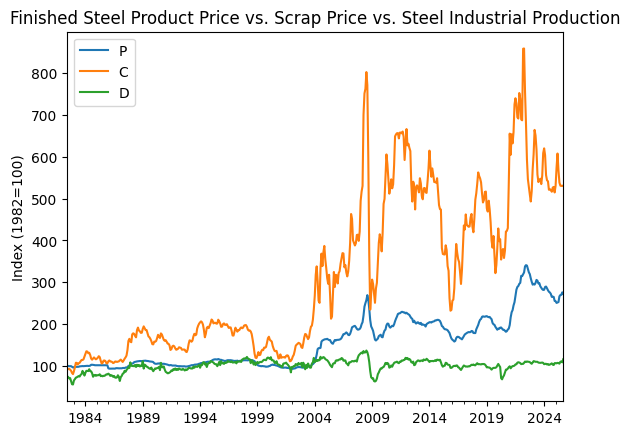

✓ Data loaded successfully: (520, 3) observations
Date range: 1982-06-01 00:00:00 to 2025-09-01 00:00:00

Data summary:
                P           C           D
count  520.000000  520.000000  520.000000
mean   156.732848  315.815242  100.391806
std     63.143044  190.527190   13.437843
min     92.500000   80.000000   55.160000
25%    101.200000  152.125000   93.878675
50%    116.300000  224.600000  102.977650
75%    198.275000  496.925000  109.398475
max    340.699000  859.242000  136.372100


In [ ]:
# Load data
data = TwoStageCapacityAndProcurementPlanning.load_data_from_fredapi(
    API_KEY, 
    steel_demand_identifier='IPG3311A2S', 
    scrap_price_identifier='WPU1012', 
    steel_price_identifier='WPU101704',
    plot_data=True)

print(f"✓ Data loaded successfully: {data.shape} observations")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print("\nData summary:")
print(data.describe())

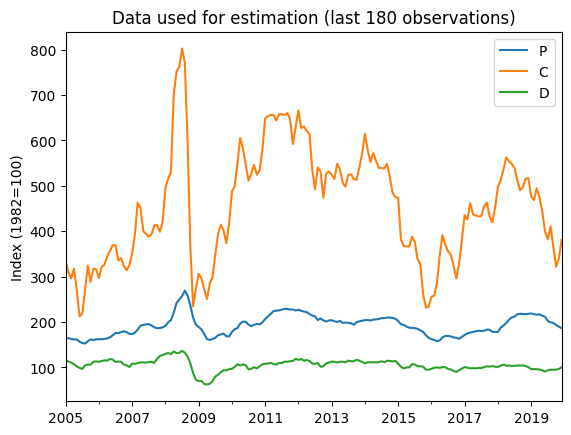

✓ Data subset created: (180, 3) observations
Subset date range: 2005-01-01 00:00:00 to 2019-12-01 00:00:00


In [26]:
data_subset = TwoStageCapacityAndProcurementPlanning.get_n_observations(
    data,
    n=180,
    p=2,
    last_observation='2019-12-01',
    plot_data=True)

print(f"✓ Data subset created: {data_subset.shape} observations")
print(f"Subset date range: {data_subset.index.min()} to {data_subset.index.max()}")

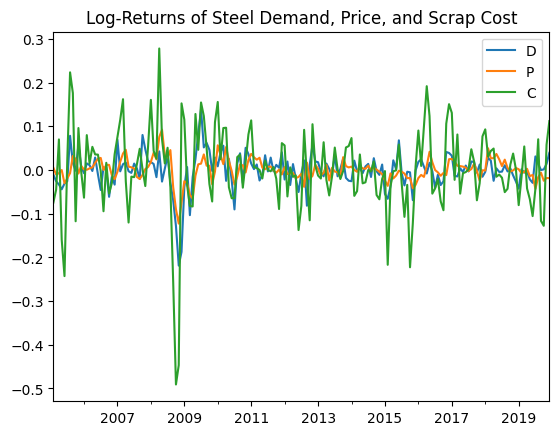

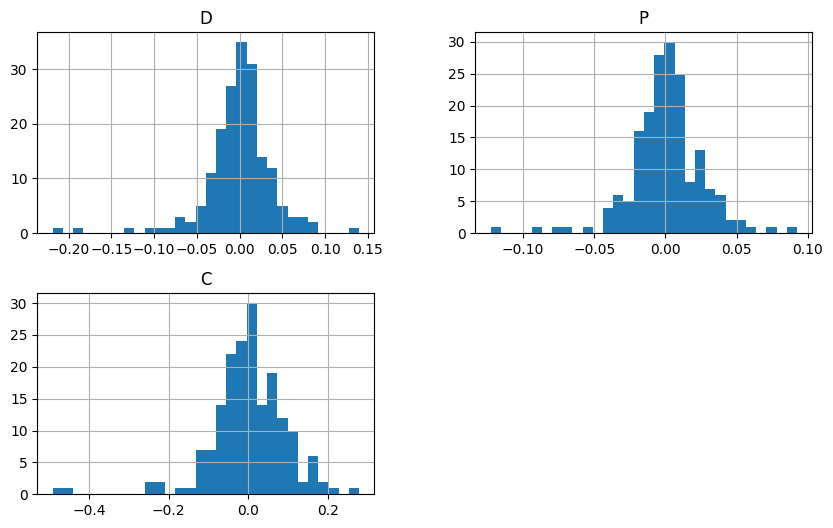

Log-Returns Statistics:
                 D         P         C
mean     -0.000739  0.000726  0.000742
std       0.040092  0.025572  0.096014
skew     -1.423401 -0.580622 -1.242416
kurtosis  7.631809  4.303891  5.943390
✓ Log returns computed: (179, 3) observations
Missing values: 0


In [5]:
Δlog = TwoStageCapacityAndProcurementPlanning.log_returns(
    data_subset,
    plot_data=True,
    print_stats=True)

print(f"✓ Log returns computed: {Δlog.shape} observations")
print(f"Missing values: {Δlog.isnull().sum().sum()}")

VAR MODEL ESTIMATION
• Computing log returns from provided data

----------------------------------------
DATA QUALITY CHECKS
----------------------------------------
⚠ D: 1 extreme values (|Δlog| > 20.0%)
   Extreme dates: [Timestamp('2008-11-01 00:00:00')]
✓ P: No extreme values detected
⚠ C: 8 extreme values (|Δlog| > 20.0%)
   Extreme dates: [Timestamp('2005-06-01 00:00:00'), Timestamp('2005-08-01 00:00:00'), Timestamp('2008-04-01 00:00:00')]...
✓ No suspicious correlations detected

• Using specified lag order: p=2

• Fitting VAR(2) model...
✓ VAR(2) model fitted successfully
  Effective sample size: 177
  AIC: -20.41
  BIC: -20.04
  Log-likelihood: 1074.06

MODEL VALIDATION TESTS

----------------------------------------
RESIDUAL CORRELATION ANALYSIS
----------------------------------------
Residual Correlation Matrix:
          D         P         C
D  1.000000  0.172483  0.463215
P  0.172483  1.000000  0.488007
C  0.463215  0.488007  1.000000

Economic Interpretation:
• Demand-

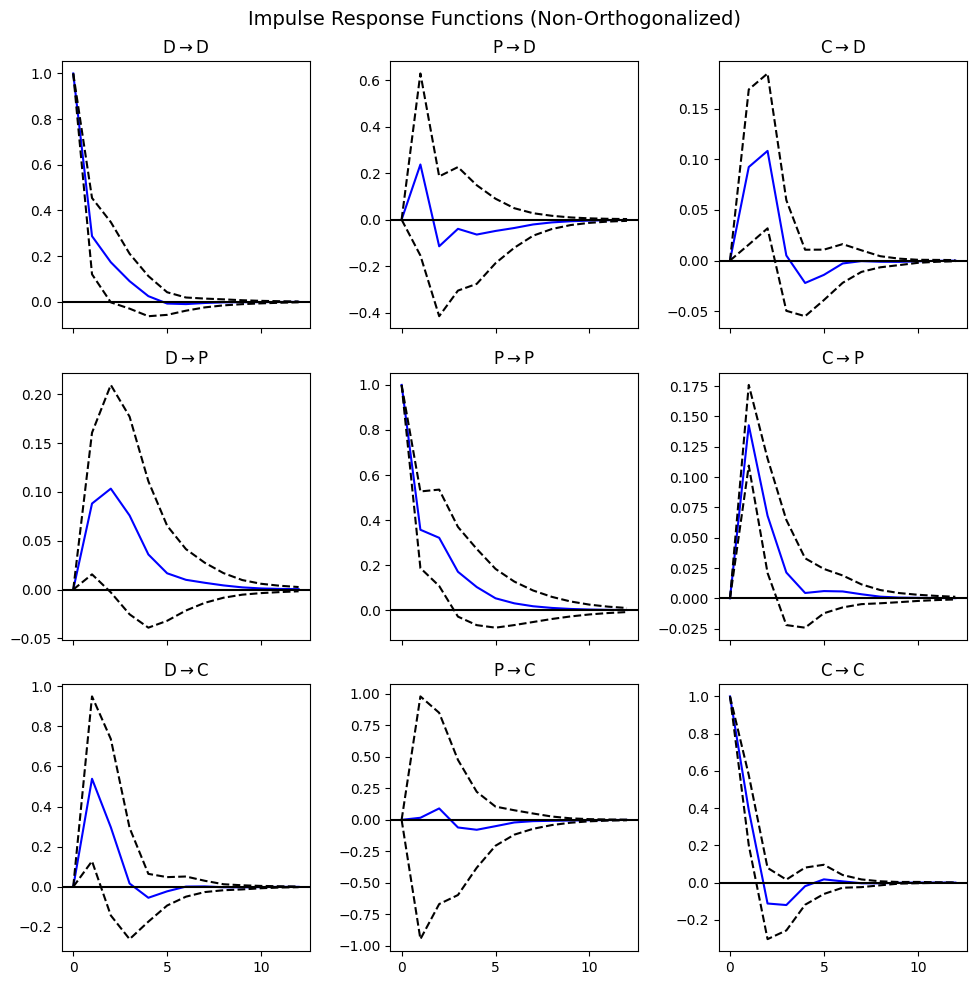

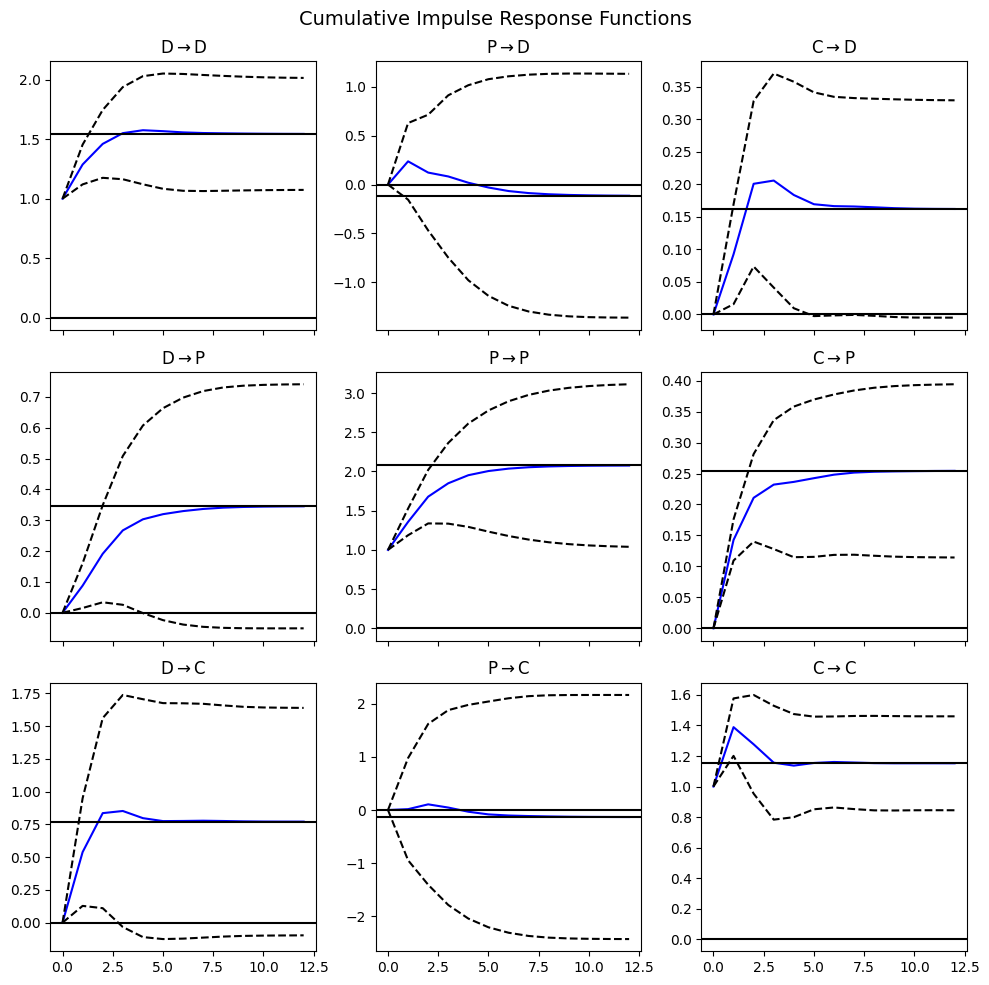

✓ IRF plots generated
  Note: Non-orthogonalized IRFs allow for correlated shocks
  Economic interpretation depends on contemporaneous correlations

----------------------------------------
STABILITY ANALYSIS
----------------------------------------
Eigenvalues of VAR(1) rep
0.4736889285433879
0.4736889285433879
0.5556113593576595
0.4421493838329046
0.04273435642456714
0.31949585297236804

STABILITY CONCLUSION:
✓ SYSTEM IS STABLE
  Evidence:
  - All eigenvalues inside unit circle
  - System returns to equilibrium after shocks
  - IRF plots should show convergence to zero
  ✓ Safe to proceed with scenario generation and optimization

----------------------------------------
SIMULATION VALIDATION
----------------------------------------
Generating 5000 simulations over 24 periods...
✓ Simulation completed. Shape: (5000, 24, 3)

Historical vs Simulated Correlations:
Historical correlation matrix:
          D         P         C
D  1.000000  0.452025  0.528024
P  0.452025  1.000000  0.5037

In [27]:
var_model = TwoStageCapacityAndProcurementPlanning.fit_VAR_model(
    data=data_subset,
    p=2,  # Let the function select optimal lag order
    # NOTE: Testing options can be adjusted as needed, the objective is to ensure model follows real economy dynamics
    testing=['stability', 'irf', 'corr', 'sim_stats', 'residual_tests'],
    method='bic',
    print_warnings=True
)

SHOCK DISTRIBUTION ANALYSIS

D Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0343
Skew: -0.146 (normal = 0)
Kurt: 1.207 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0061
Shapiro-Wilk p-value: 0.0439

Recommendation: t
Parameters: {'df': 6}
Reason: Non-normal but unclear pattern - conservative t-distribution

P Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0149
Skew: 0.429 (normal = 0)
Kurt: 2.465 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0000
Shapiro-Wilk p-value: 0.0001

Recommendation: t
Parameters: {'df': 6}
Reason: Non-normal but unclear pattern - conservative t-distribution

C Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0842
Skew: -0.371 (normal = 0)
Kurt: 3.267 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0000
Shapiro-Wilk p-value: 0.0000

Recommendation: t
Parameters: {'df': 10}
Reason: Non-normal but unclear pattern 

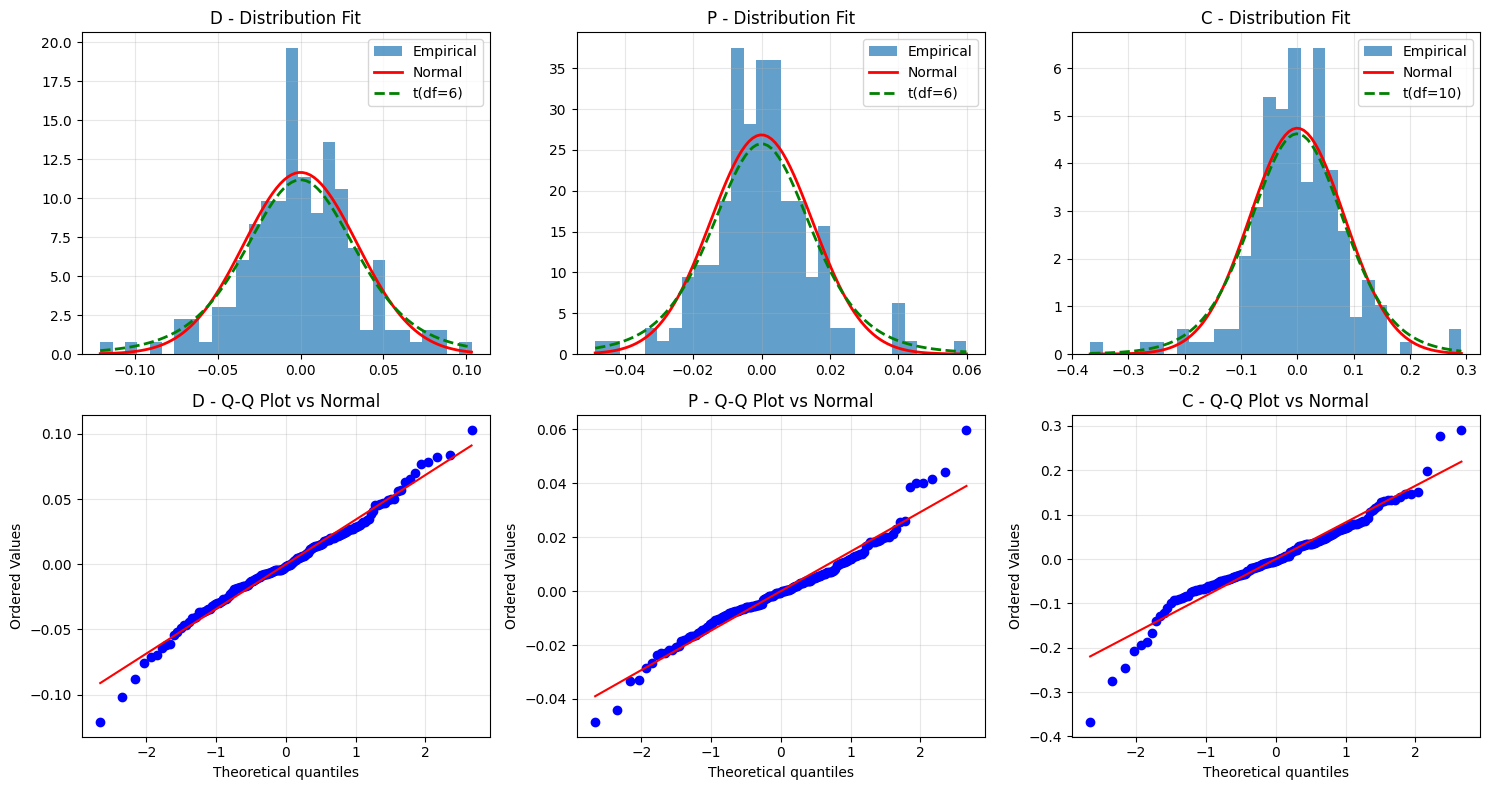

In [28]:
shock_distribution_analysis_results = TwoStageCapacityAndProcurementPlanning.analyze_shock_distributions(var_model)

In [29]:
scenario_returns, prob = TwoStageCapacityAndProcurementPlanning.generate_future_returns_scenarios(
    var_model=var_model, 
    simulation_start_date=data_subset.index.max().strftime('%Y-%m'),
    horizon=24,
    n_scenarios=1000,
    seed=42,
    shock_distribution='t',
    distribution_params={'df':7})

Setting up t distribution for shocks...
  Using multivariate t-distribution with df=7
    Tail behavior: Moderate tails

Generating VAR scenarios...
  Horizon: 24 periods
  Number of scenarios: 1000
  VAR lag order: 2
  Variables: ['D', 'P', 'C'] (assumed order)
  Shock distribution: t
  Initial conditions shape: (2, 3)
• Simulating scenarios...
  Progress: 10% (100/1000)
  Progress: 20% (200/1000)
  Progress: 30% (300/1000)
  Progress: 40% (400/1000)
  Progress: 50% (500/1000)
  Progress: 60% (600/1000)
  Progress: 70% (700/1000)
  Progress: 80% (800/1000)
  Progress: 90% (900/1000)
  Progress: 100% (1000/1000)
✓ Scenario simulation completed
• Formatting output DataFrame...
• Creating scenario probabilities...
• Validating generated scenarios...

SCENARIO GENERATION SUMMARY
Generated scenarios: 1000
Time horizon: 24 periods
Date range: 2020-01 to 2021-12
Output shape: (24000, 5)
Shock distribution: t
Distribution parameters: {'df': 7}

Scenario probabilities:
  Each scenario probabil

In [30]:
real_prices = {
    'P': 800,    # €/ton steel price
    'C': 400,    # €/ton scrap cost  
    'D': 50_000   # tons/month demand
}
scenario_levels, info = TwoStageCapacityAndProcurementPlanning.reconstruct_levels_from_returns(
    scenario_returns=scenario_returns,
    historical_data=data_subset,
    anchor_date=None,
    real_prices=real_prices
)

print(f"Steel prices range: €{scenario_levels['P'].min():.0f} - €{scenario_levels['P'].max():.0f}/ton")
print(f"Demand range: {scenario_levels['D'].min():,.0f} - {scenario_levels['D'].max():,.0f} tons/month")

LEVEL RECONSTRUCTION FROM RETURNS
Input validation completed:
  Scenarios: 1000
  Time periods: 24
  Total rows: 24000
  Date range: 2020-01 to 2021-12
Using last historical date as anchor: 2019-12-01

Initial levels from 2019-12-01:
  D: 100.2263
  P: 186.2000
  C: 381.2000

Setting up real price conversion...
  D: 100.2263 (index) -> 50000.00 (tons/month) [factor: 498.8711]
  P: 186.2000 (index) -> 800.00 (€/ton) [factor: 4.2965]
  C: 381.2000 (index) -> 400.00 (€/ton) [factor: 1.0493]

Reconstructing levels...
  Processing variable D...
    Applied conversion factor: 498.8711
    Level statistics - Min: 16400.56, Max: 195505.54, Mean: 54018.69
  Processing variable P...
    Applied conversion factor: 4.2965
    Level statistics - Min: 354.53, Max: 1983.29, Mean: 827.42
  Processing variable C...
    Applied conversion factor: 1.0493
    Level statistics - Min: 43.39, Max: 5003.48, Mean: 471.49

Final validation...
  ✓ No missing values in final output

RECONSTRUCTION SUMMARY
Success

SCENARIO EVOLUTION VISUALIZATION
Input validation completed:
  Total scenarios available: 1000
  Scenarios to display: 50
  Historical months to show: 180

Selecting 50 representative scenarios...
  Selected 25 high-probability scenarios
  Selected 25 representative scenarios
  Total probability coverage: 5.0%

Date ranges:
  Historical: 2005-01 to 2019-12 (180 months)
  Scenarios: 2020-01 to 2021-12 (24 months)

Detected scenarios in real units - converting historical data for consistency
Using anchor date: 2019-12-01 (last historical observation)
  D: index 100.23 -> real 51524 [factor: 514.0764]
  P: index 186.20 -> real 807 [factor: 4.3348]
  C: index 381.20 -> real 422 [factor: 1.1064]

Processing future trajectory for backtesting...
  Future trajectory: 24 months

Computing probability-weighted line thickness...
  Probability range: 0.0010 to 0.0010
  Line width: 1.0 (equal probabilities)

Generating plots...
  Processing D variable...
    Plotted 50 scenario trajectories
  Proce

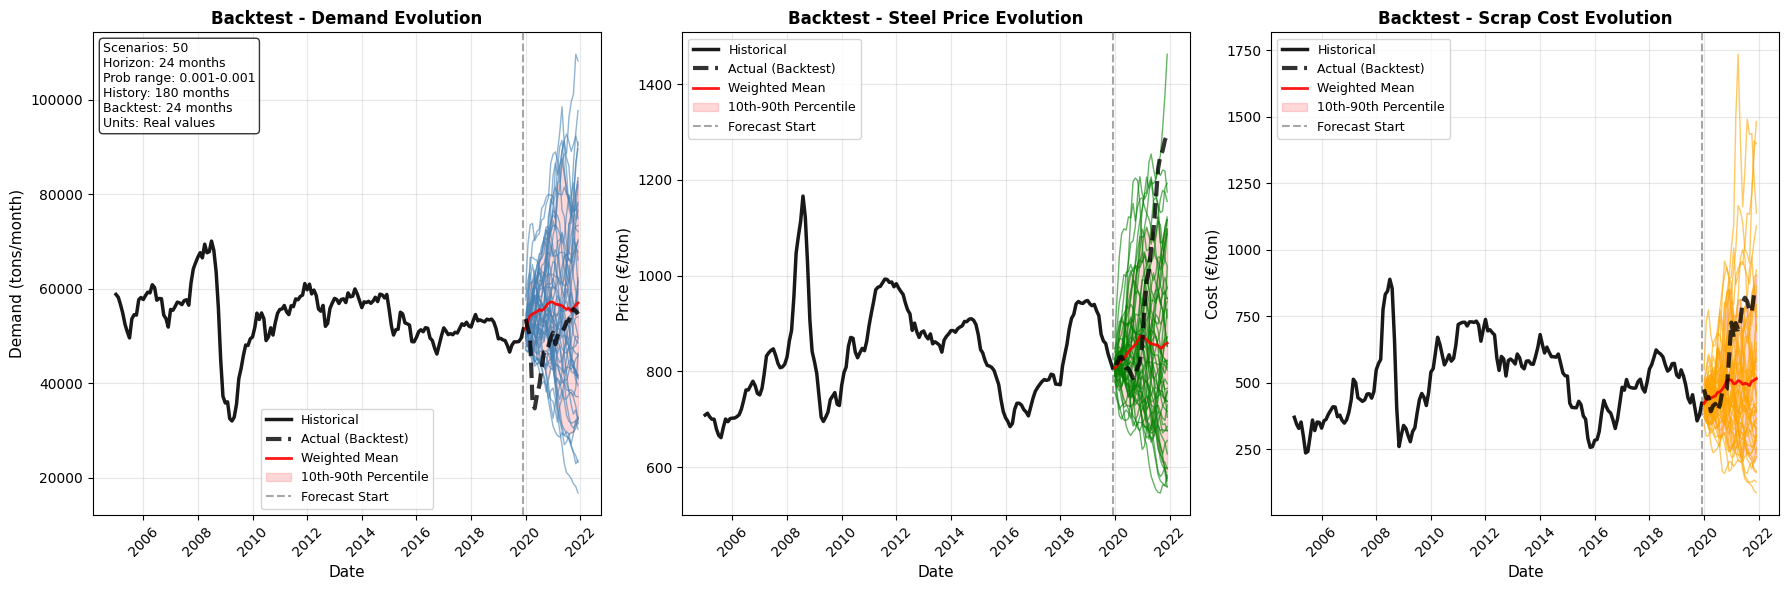

In [10]:
# Backtesting with actual trajectory
actual_future = data.loc['2020-01-01':'2021-12-01']
fig, axes = TwoStageCapacityAndProcurementPlanning.plot_scenarios_evolution(
    scenarios=scenario_levels,
    historical_data=data_subset,
    max_history=180,
    max_number_of_scenarios=50,
    prob=prob,
    future_trajectory=actual_future,
    title_prefix="Backtest - "
)

In [31]:
# With stress scenarios and diagnostics
scenarios_red, prob_red = TwoStageCapacityAndProcurementPlanning.reduce_scenarios_kmedoids(
    scenarios=scenario_levels,
    prob=prob,
    n_scenario_clusters=100,
    stress_pct=0.01
)

SCENARIO REDUCTION VIA K-MEDOIDS CLUSTERING
Input validation completed:
  Original scenarios: 1000
  Target scenarios: 100
  Stress percentage: 1.0%
  Reduction ratio: 10.0%

Building feature matrix for clustering...
  Feature matrix shape: (1000, 72)
  Features per scenario: 72 (3 variables × 24 time periods)

Standardizing features...
  Standardization completed
  Feature means: [ 0. -0. -0. -0.  0.]... (showing first 5)
  Feature stds:  [1. 1. 1. 1. 1.]... (showing first 5)

Identifying stress scenarios...
  Stress scenarios: 1 (1.0% of 100)
  Regular scenarios: 99
  Stress scenarios identified: ['s549']
  Stress scenario distances: [46.314]

Performing K-Medoids clustering...
  Data points to cluster: 999
  Target clusters: 99
  ✓ Clustering completed successfully
  Medoid scenarios: ['s75', 's548', 's757', 's485', 's970', 's695', 's990', 's141', 's196', 's367']...
  Cluster sizes: min=1, max=30, mean=10.1

Combining selected scenarios...
  Regular scenario medoids: 99
  Stress sce

SCENARIO EVOLUTION VISUALIZATION
Input validation completed:
  Total scenarios available: 100
  Scenarios to display: 50
  Historical months to show: 180

Selecting 50 representative scenarios...
  Selected 25 high-probability scenarios
  Selected 25 representative scenarios
  Total probability coverage: 72.7%

Date ranges:
  Historical: 2005-01 to 2019-12 (180 months)
  Scenarios: 2020-01 to 2021-12 (24 months)

Detected scenarios in real units - converting historical data for consistency
Using anchor date: 2019-12-01 (last historical observation)
  D: index 100.23 -> real 51232 [factor: 511.1645]
  P: index 186.20 -> real 806 [factor: 4.3286]
  C: index 381.20 -> real 433 [factor: 1.1369]

Processing future trajectory for backtesting...
  Future trajectory: 24 months

Computing probability-weighted line thickness...
  Probability range: 0.0010 to 0.0297
  Line width range: 0.3 to 2.5

Generating plots...
  Processing D variable...
    Plotted 50 scenario trajectories
  Processing P v

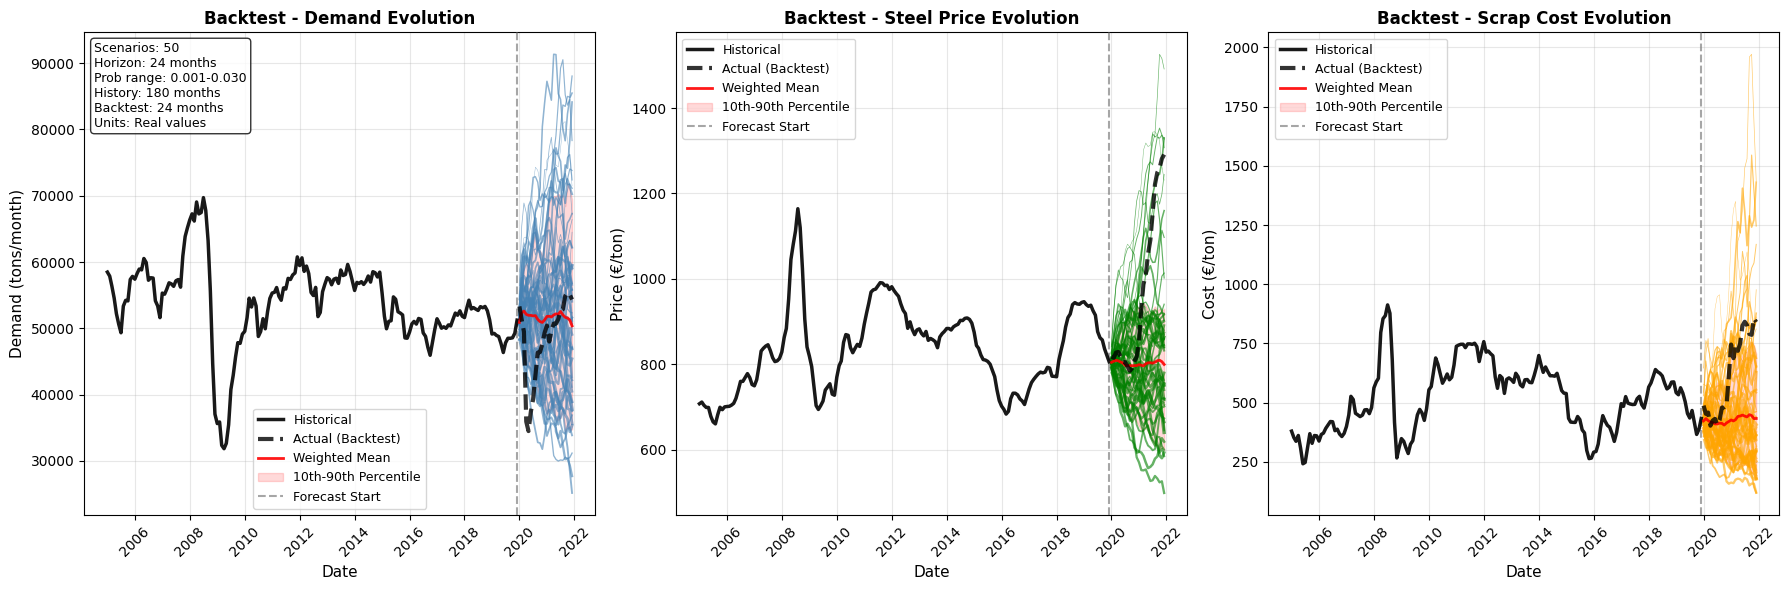

In [32]:
fig, axes = TwoStageCapacityAndProcurementPlanning.plot_scenarios_evolution(
    scenarios=scenarios_red,
    historical_data=data_subset,
    max_history=180,
    max_number_of_scenarios=50,
    prob=prob_red,
    future_trajectory=actual_future,
    title_prefix="Backtest - "
)

In [33]:
decisions = TwoStageCapacityAndProcurementPlanning.optimize_capacity_and_procurement(
    scenarios=scenarios_red,
    prob=prob_red,
    alpha=1.01,  # scrap-to-product ratio
    c_var=250.0, # variable production cost €/ton
    c_cap_base=10.0, # fixed capacity cost €/ton capacity
    c_cap_flex=30.0, # flexible capacity cost €/ton capacity
    delta_base=5.0, # base scrap procurement premium €/ton
    delta_spot=15.0, # spot scrap procurement premium €/ton
    pen_unmet=10.0, # penalty cost for unmet demand €/ton
    gamma_cap=0.3, # capacity adjustment cost factor
    gamma_scrap=0.8, # scrap procurement adjustment cost factor
    solver="highs"
)

print("Optimal capacity decisions:")
decisions

TWO-STAGE STOCHASTIC PROGRAMMING OPTIMIZATION
Validating inputs...
✓ Input validation completed
  Time periods: 24
  Scenarios: 100
  Total probability: 1.000000
Building parameter dictionaries...
✓ Parameter dictionaries built
  Average demand: 61056.2
  Average price: €915.1/ton
  Average cost: €646.2/ton
Building optimization model...
  Sets defined: T=24, S=100
  Variables defined: 14424 total
Adding constraints...
✓ Constraints added:
  Demand balance: 2400 constraints
  Capacity and operational: 12000 constraints
  Recourse bounds: 4800 constraints
Building objective function...
✓ Objective function built (maximize expected profit)

Solving with highs solver...
✓ Optimization completed successfully
  Termination condition: optimal
  Solution status: ok
  Optimal objective value: €128,191,283
Extracting optimal decisions...
✓ Results extracted successfully
  Decision variables: (24, 2)
  Date range: 2020-01-01 00:00:00 to 2021-12-01 00:00:00

OPTIMIZATION SUMMARY
Model statistics:

,Cap_base,Q_base
Date,,
2020-01-01,51526.553504,52041.819040
2020-02-01,53528.193400,54063.475334
2020-03-01,53592.631854,54128.558173
2020-04-01,54591.446290,55137.360753
2020-05-01,53916.700194,54455.867196
2020-06-01,53665.164918,54201.816567
2020-07-01,53657.494327,54194.069270
2020-08-01,54331.646999,54874.963469
2020-09-01,55073.802848,55450.633454


PROFIT DISTRIBUTION ANALYSIS OVER TIME
Validating inputs...
✓ Input validation completed
  Time periods: 24
  Scenarios: 100
  Date range: 2020-01 to 2021-12

Calculating profits for all scenario-period combinations...
  Progress: 5.0% (120/2400)
  Progress: 10.0% (240/2400)
  Progress: 15.0% (360/2400)
  Progress: 20.0% (480/2400)
  Progress: 25.0% (600/2400)
  Progress: 30.0% (720/2400)
  Progress: 35.0% (840/2400)
  Progress: 40.0% (960/2400)
  Progress: 45.0% (1080/2400)
  Progress: 50.0% (1200/2400)
  Progress: 55.0% (1320/2400)
  Progress: 60.0% (1440/2400)
  Progress: 65.0% (1560/2400)
  Progress: 70.0% (1680/2400)
  Progress: 75.0% (1800/2400)
  Progress: 80.0% (1920/2400)
  Progress: 85.0% (2040/2400)
  Progress: 90.0% (2160/2400)
  Progress: 95.0% (2280/2400)
  Progress: 100.0% (2400/2400)
✓ Profit calculations completed: 2400 results

Processing profit results...
  Profit matrix shape: (24, 100)
  Probability alignment: 100 scenarios
Computing monthly statistics...
✓ Monthly

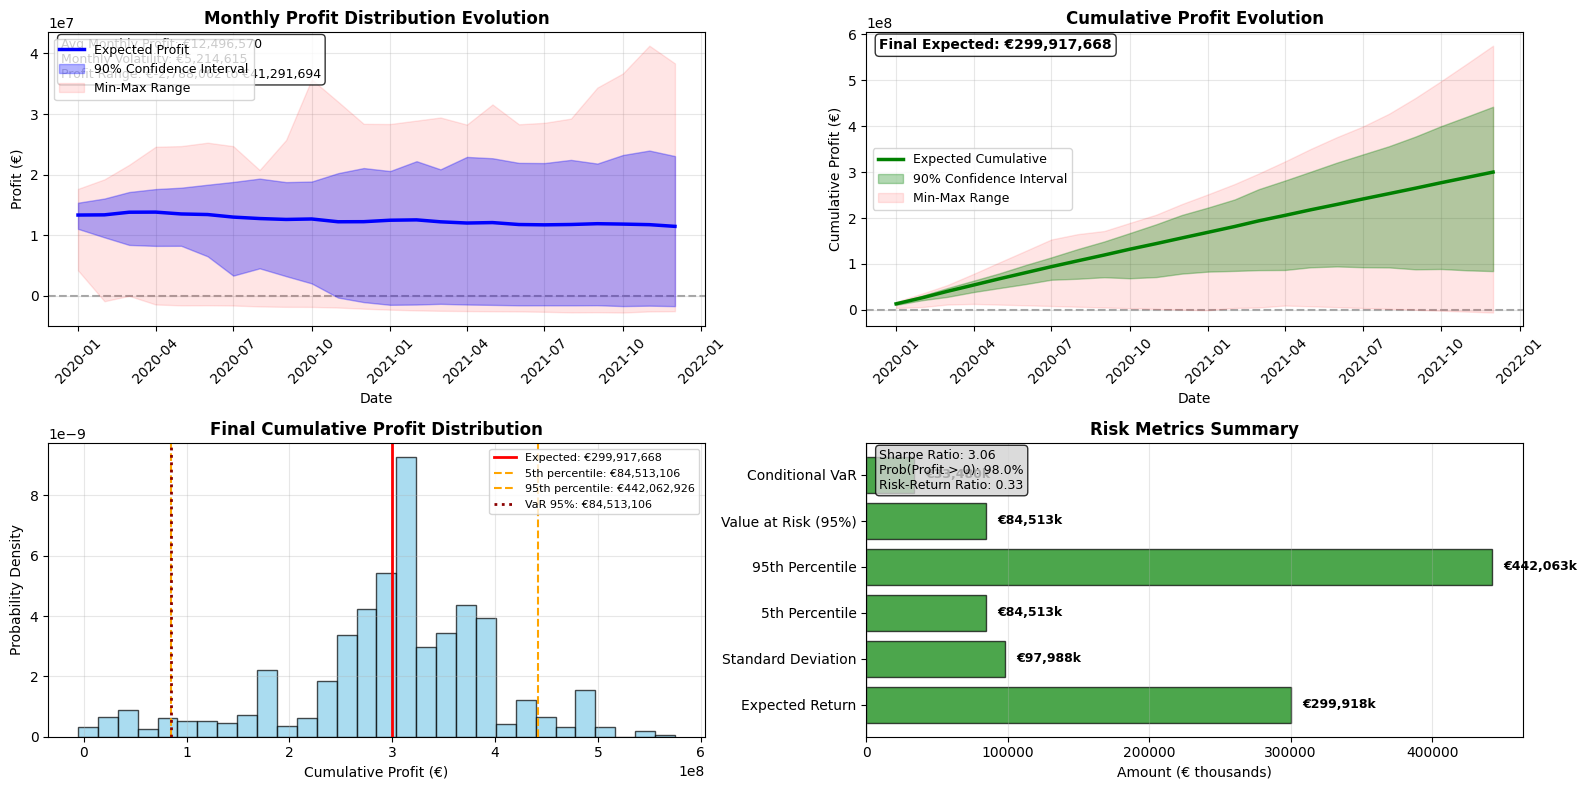


PROFIT DISTRIBUTION ANALYSIS SUMMARY
Analysis period: 2020-01 to 2021-12
Number of scenarios: 100
Confidence interval: 90%

Monthly Profit Statistics:
  Average expected monthly profit: €12,496,570
  Monthly profit volatility (avg std): €5,214,615
  Best month (expected): 2020-04 (€13,801,818)
  Worst month (expected): 2021-12 (€11,448,347)

Cumulative Profit Statistics:
  Expected cumulative profit: €299,917,668
  Cumulative profit standard deviation: €97,987,785
  5th percentile: €84,513,106
  95th percentile: €442,062,926
  Value at Risk (95%): €84,513,106
  Conditional Value at Risk: €33,479,735

Risk Assessment:
  Probability of overall loss: 2.0%
  Probability of exceeding 110% of expected profit: 29.0%
  Risk-adjusted return (Sharpe-like ratio): 3.061
  ✓ Strong risk-adjusted returns

✓ Profit distribution analysis completed successfully
  Returns: Dictionary with monthly_profits, monthly_stats, cumulative_profits, etc.
Expected total profit: €299,917,668


In [35]:
import warnings
import pandas as pd

# Suppress specific pandas warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', message='.*DataFrame.stack.*')

# After optimization
profit_analysis = TwoStageCapacityAndProcurementPlanning.plot_profit_distribution_over_time(
    decisions=decisions,
    scenarios=scenarios_red,
    prob=prob_red,
    alpha=1.01,  # scrap-to-product ratio
    c_var=100.0, # variable production cost €/ton
    c_cap_base=10.0,
    c_cap_flex=25.0,
    delta_base=5.0,
    delta_spot=15.0,
    pen_unmet=10.0,
    gamma_cap=0.3,
    gamma_scrap=0.8,
    confidence_levels=[0.05, 0.95],  # 90% CI
)

print(f"Expected total profit: €{profit_analysis['cumulative_stats']['expected_cumulative']:,.0f}")

BACKTESTING SIMULATION
Validating inputs...
✓ Input validation completed
  Simulation period: 2020-01-01 00:00:00 to 2021-12-01 00:00:00
  Number of periods: 24

Converting actual data to real units...
  D: index 104.28 -> real 50000 [factor: 479.4875]
  P: index 189.00 -> real 800 [factor: 4.2328]
  C: index 428.50 -> real 400 [factor: 0.9335]

Running monthly simulations...
  Simulating 2020-01... Profit: €9,024,525
  Simulating 2020-02... Profit: €9,878,906
  Simulating 2020-03... Profit: €9,849,941
  Simulating 2020-04... Profit: €8,505,785
  Simulating 2020-05... Profit: €7,215,291
  Simulating 2020-06... Profit: €7,244,381
  Simulating 2020-07... Profit: €8,403,083
  Simulating 2020-08... Profit: €8,178,447
  Simulating 2020-09... Profit: €6,574,361
  Simulating 2020-10... Profit: €6,833,704
  Simulating 2020-11... Profit: €7,481,914
  Simulating 2020-12... Profit: €3,525,647
  Simulating 2021-01... Profit: €7,547
  Simulating 2021-02... Profit: €5,648,644
  Simulating 2021-03...

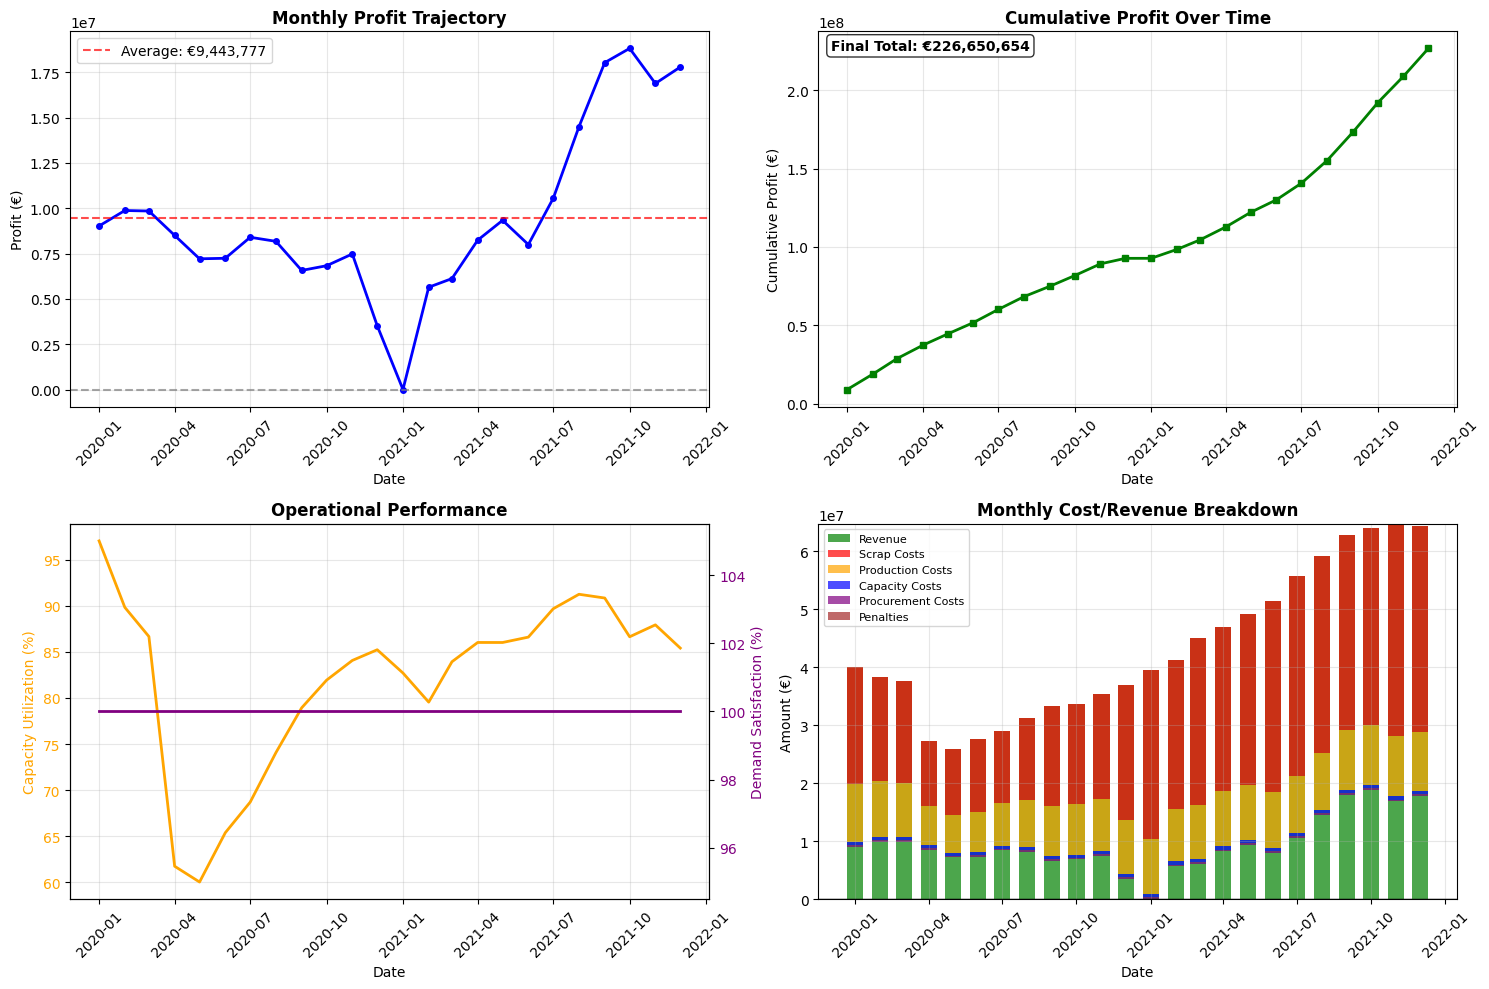


BACKTESTING SUMMARY
Simulation period: 2020-01 to 2021-12
Number of periods: 24

Financial Performance:
  Total profit: €226,650,654
  Average monthly profit: €9,443,777
  Profit volatility (std): €4,658,927
  Best month: 2021-10 (€18,817,819)
  Worst month: 2021-01 (€7,547)

Operational Performance:
  Average capacity utilization: 82.1%
  Average demand satisfaction: 100.0%
  Total unmet demand: 0 tons/month
  Flexible capacity used: 0.0% of months
  Spot procurement used: 8.3% of months

Cost Analysis:
  Total revenue: €1,040,608,639
  Total costs: €813,957,985
  Profit margin: 21.8%

✓ Backtesting simulation completed successfully
  Returns: Dictionary with monthly_profits, cumulative_profits, operational_metrics, summary_stats, cost_breakdown
Total profit: €226,650,654


In [36]:
# Run backtesting simulation
actual_future = data.loc['2020-01-01':'2021-12-01']
backtest_results = TwoStageCapacityAndProcurementPlanning.backtesting_simulation(
    decisions=decisions,
    actual_future_data=actual_future,
    alpha=1.01,
    c_var=200.0,
    c_cap_base=10.0,
    c_cap_flex=35.0,
    delta_base=5.0,
    delta_spot=15.0,
    pen_unmet=10.0,
    gamma_cap=0.3,
    gamma_scrap=0.8,
    real_prices={'P': 800, 'C': 400, 'D': 50000}
)

print(f"Total profit: €{backtest_results['summary_stats']['total_profit']:,.0f}")